In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
import gc
warnings.filterwarnings(action='ignore')

pip install 'aif360[inFairness]'


In [2]:
ml_ds = openml.datasets.get_dataset(43904)
df, * _ = ml_ds.get_data()
print(ml_ds.description[:500])
target = "bar"
list_of_disparities = ["fnr_disparity","fpr_disparity"]

Law School Admissions (Binarized) 
 Survey among students attending law school in the U.S. in 1991. 
 The dataset was obtained from the R-package fairml. 
 The response variable has been changed to a binary version: Whether ugpa is greater than 3.
 The race1 variables has been binarized to labels white and non-white.


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['lsat'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Lsat Distribution', fontsize=16)
plt.xlabel('Lsat', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [3]:
protected_attributes = ["race","fam_inc","lsat"]
def categorize_age(age):
    if age<60:
        return '0'
    if age>=60:
        return '1'
def categorize_lsat(lsat):
    if lsat<35:
        return '0'
    if lsat>=35:
        return '1'
df["age"] = df["age"].apply(categorize_age)
# df["lsat"] = df["lsat"].apply(categorize_lsat)
percentile_50 = np.percentile(df['lsat'], 50)
df['lsat'] = np.where(df['lsat'] >= percentile_50, '<50%', '>50%')
df.rename(columns={ 'race1':'race'}, inplace=True)
df['race'].replace('black','other',inplace=True)
df['race'].replace('hisp','other',inplace=True)
df['race'].replace('asian','other',inplace=True)
gc.collect()

566

In [22]:
df["lsat"].value_counts(normalize=True) * 100

<50%    53.350962
>50%    46.649038
Name: lsat, dtype: float64

In [ ]:
def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(3, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [4]:
categorical_attributes = get_categorical_attributes(df)
df[target] = df[target].astype(int)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and col != target and col not in protected_attributes:
        df_num[col] = scaler.fit_transform(df_num[[col]])
df_num["fam_inc"] = df_num["fam_inc"].astype(int)

['age', 'lsat', 'gender', 'race', 'cluster', 'fulltime']
Attribute: age
{'0': 0, '1': 1}
Attribute: lsat
{'<50%': 0, '>50%': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: race
{'other': 0, 'white': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}


In [ ]:
corr = df_num.corr()
below_main_diagonal = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = pd.isna(below_main_diagonal) 
plt.figure(figsize=(15, 10))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap="Purples",
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max()
            )

In [5]:
'''
Top 3 protected attributes: "race","age","lsat". Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["race/fam_inc"] = df_intersect["race"].astype(str) + " " +  df_intersect["fam_inc"].astype(str)
df_intersect["race/lsat"] = df_intersect["race"].astype(str) + " " + df_intersect["lsat"].astype(str)
df_intersect["lsat/fam_inc"] = df_intersect["lsat"].astype(str) + " " + df_intersect["fam_inc"].astype(str)

df_intersect.drop(["race", "lsat", "fam_inc"], axis=1, inplace=True)

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
# scaler = MinMaxScaler()
# 
# for col in df_num_int.columns:
#     if col not in categorical_attributes and col != target and col not in protected_attributes:
#         df_num_int[col] = scaler.fit_transform(df_num_int[[col]])
protected_attributes_int = ["race/fam_inc","race/lsat","lsat/fam_inc"]

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other <50%': 0, 'other >50%': 1, 'white <50%': 2, 'white >50%': 3}
Attribute: lsat/fam_inc
{'<50% 1': 0, '<50% 2': 1, '<50% 3': 2, '<50% 4': 3, '<50% 5': 4, '>50% 1': 5, '>50% 2': 6, '>50% 3': 7, '>50% 4': 8, '>50% 5': 9}


In [9]:
priv_orig, unpriv_orig= get_priv_and_unpriv_groups(protected_attribute=protected_attributes,data=df_num)
priv, unpriv= get_priv_and_unpriv_groups(protected_attribute=protected_attributes_int,data=df_num_int)

In [10]:
del df, df_intersect

In [ ]:
plot_attributes(df_num_int, protected_attributes_int)

---------- Model name:  RandomForest ----------

Accuracy score training:
0.9464
Accuracy score test:
0.8887
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.51      0.27      0.35       467
           1       0.91      0.97      0.94      3693

    accuracy                           0.89      4160
   macro avg       0.71      0.62      0.65      4160
weighted avg       0.87      0.89      0.87      4160



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0           race               0      0.76  0.84  0.52  0.46  0.17  0.48   
1           race               1      0.91  0.99  0.13  0.56  0.08  0.87   
2        fam_inc               1      0.72  0.83  0.33  0.63  0.19  0.67   
3        fam_inc               2      0.87  0.95  0.29  0.59  0.09  0.71   
4        fam_inc               3      0.87  0.96  0.34  0.45  0.10  0.66   
5        fam_inc               4      0.91  0.98  0.21  0.42  0.08  0.79   
6        fam_inc               5      0.89  0.97  0.07  0.82  0.08  0.93   
7           lsat               0      0.94  0.99  0.06  0.72  0.05  0.94   
8           lsat               1      0.83  0.93  0.34  0.47  0.14  0.66   

    fnr   npv  precision   ppr  pprev  prev  
0  0.16  0.54       0.83  0.12   0.75  0.73  
1  0.01  0.44       0.92  0.88   0.98  0.92  
2  0.17  0.37       0.81  0.02   0.80  0.77  
3  0.05  0.41       0.91  0.09   0.92  0.89  
4  0.04  0.55       0.90  0.35   0.92  0.87  
5  0.02  0.58       0.92  0.45   0.97  0.91  
6  0.03  0.18       0.92  0.08   0.97  0.91  
7  0.01  0.28       0.95  0.56   0.99  0.95  
8  0.07  0.53       0.86  0.44   0.89  0.82

Majority class for:  race  is: 1
Majority class for:  fam_inc  is: 4
Majority class for:  lsat  is: 0
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0           race               0           2.29          10.84           0.82   
1           race               1           1.00           1.00           1.00   
2        fam_inc               1           2.47          10.61           1.51   
3        fam_inc               2           1.15           3.45           1.42   
4        fam_inc               3           1.26           2.73           1.08   
5        fam_inc               4           1.00           1.00           1.00   
6        fam_inc               5           1.07           1.84           1.95   
7           lsat               0           1.00           1.00           1.00   
8           lsat               1           2.82           7.64           0.65   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           0.55           1.23           0.14             0.76   
1           1.00           1.00           1.00             1.00   
2           0.84           0.63           0.04             0.82   
3           0.90           0.70           0.21             0.95   
4           0.84           0.94           0.78             0.95   
5           1.00           1.00           1.00             1.00   
6           1.18           0.31           0.19             1.00   
7           1.00           1.00           1.00             1.00   
8           0.71           1.91           0.79             0.90   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.90           4.13           0.85  
1                 1.00           1.00           1.00  
2                 0.88           1.58           0.85  
3                 0.99           1.37           0.96  
4                 0.98           1.61           0.97  
5                 1.00           1.00           1.00  
6                 0.99           0.33           0.99  
7                 1.00           1.00           1.00  
8                 0.91           5.43           0.94

         fnr_disparity  fpr_disparity
race           10.8400           0.55
fam_inc         4.6575           0.94
lsat            7.6400           0.71
Overall average for fnr_disparity:  7.712
Overall average for fpr_disparity:  0.733


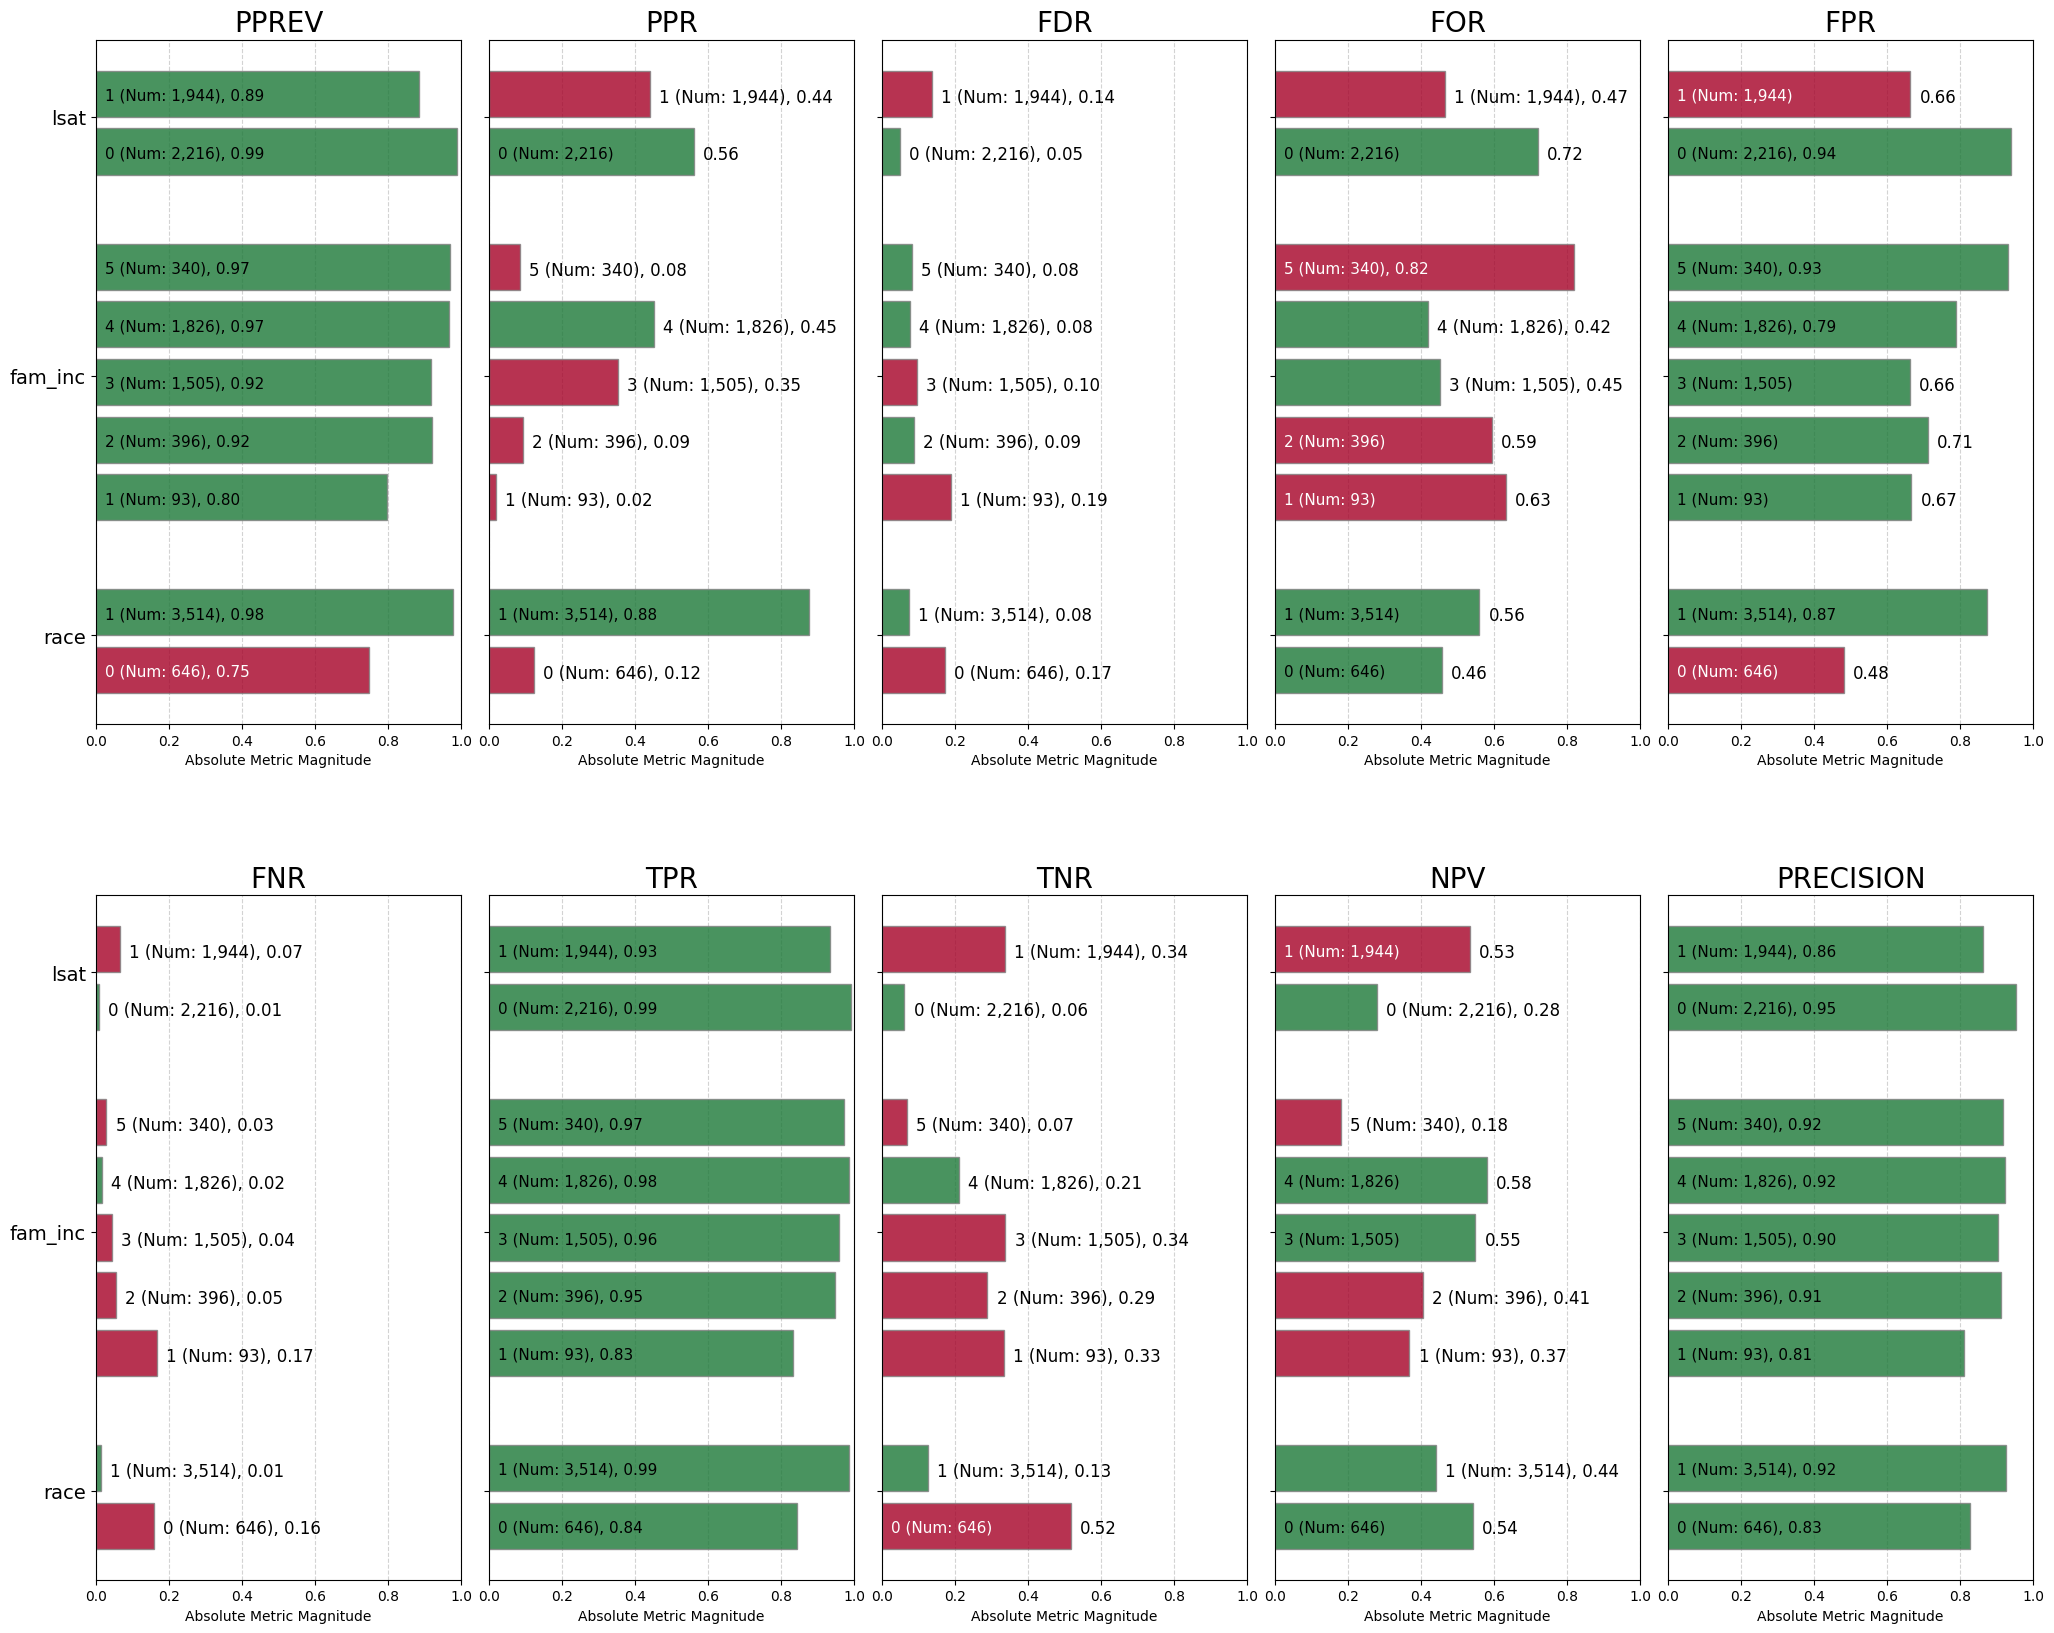

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1        fam_inc               False           True   
1         0      binary 0/1           lsat               False           True   
2         0      binary 0/1           race               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True       False   
1       False       False       False       False        True       False   
2       False       False        True       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False            True   
1       False              True         False          False           False   
2        True              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [14]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes,target)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['RandomForest'], target, protected_attributes, list_of_disparities, priv_orig,display_disp=True)

---------- Model name:  RandomForest ----------

Accuracy score training:
0.9459
Accuracy score test:
0.8875
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.50      0.27      0.35       467
           1       0.91      0.97      0.94      3693

    accuracy                           0.89      4160
   macro avg       0.71      0.62      0.64      4160
weighted avg       0.87      0.89      0.87      4160



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.52  0.62  0.29  0.75  0.33  0.71   
1    race/fam_inc               1      0.75  0.84  0.41  0.59  0.16  0.59   
2    race/fam_inc               2      0.75  0.79  0.65  0.42  0.16  0.35   
3    race/fam_inc               3      0.80  0.92  0.43  0.34  0.17  0.57   
4    race/fam_inc               4      0.67  0.77  0.20  0.83  0.19  0.80   
5    race/fam_inc               5      0.83  0.95  0.14  0.67  0.14  0.86   
6    race/fam_inc               6      0.92  0.98  0.17  0.62  0.06  0.83   
7    race/fam_inc               7      0.90  0.98  0.11  0.59  0.09  0.89   
8    race/fam_inc               8      0.92  0.99  0.15  0.47  0.07  0.85   
9    race/fam_inc               9      0.92  0.99  0.08  0.60  0.07  0.92   
10      race/lsat               0      0.89  0.96  0.07  0.88  0.08  0.93   
11      race/lsat               1      0.69  0.76  0.55  0.46  0.23  0.45   
12      race/lsat               2      0.95  0.99  0.06  0.68  0.05  0.94   
13      race/lsat               3      0.87  0.97  0.16  0.51  0.12  0.84   
14   lsat/fam_inc               0      0.85  0.96  0.00  1.00  0.12  1.00   
15   lsat/fam_inc               1      0.96  0.98  0.00  1.00  0.02  1.00   
16   lsat/fam_inc               2      0.94  0.99  0.05  0.80  0.05  0.95   
17   lsat/fam_inc               3      0.95  0.99  0.09  0.55  0.05  0.91   
18   lsat/fam_inc               4      0.94  1.00  0.00  1.00  0.05  1.00   
19   lsat/fam_inc               5      0.61  0.73  0.28  0.72  0.27  0.72   
20   lsat/fam_inc               6      0.79  0.90  0.33  0.55  0.15  0.67   
21   lsat/fam_inc               7      0.81  0.92  0.40  0.43  0.14  0.60   
22   lsat/fam_inc               8      0.86  0.97  0.29  0.39  0.12  0.71   
23   lsat/fam_inc               9      0.83  0.94  0.17  0.70  0.13  0.83   

     fnr   npv  precision   ppr  pprev  prev  
0   0.38  0.25       0.67  0.01   0.65  0.70  
1   0.16  0.41       0.84  0.03   0.79  0.79  
2   0.21  0.58       0.84  0.05   0.66  0.69  
3   0.08  0.66       0.83  0.04   0.84  0.75  
4   0.23  0.17       0.81  0.01   0.78  0.81  
5   0.05  0.33       0.86  0.01   0.94  0.85  
6   0.02  0.38       0.94  0.07   0.97  0.93  
7   0.02  0.41       0.91  0.31   0.97  0.90  
8   0.01  0.53       0.93  0.41   0.98  0.92  
9   0.01  0.40       0.93  0.08   0.98  0.92  
10  0.04  0.12       0.92  0.05   0.96  0.92  
11  0.24  0.54       0.77  0.08   0.65  0.66  
12  0.01  0.32       0.95  0.52   0.99  0.95  
13  0.03  0.49       0.88  0.36   0.96  0.87  
14  0.04  0.00       0.88  0.01   0.96  0.89  
15  0.02  0.00       0.98  0.05   0.98  0.98  
16  0.01  0.20       0.95  0.18   0.99  0.95  
17  0.01  0.45       0.95  0.27   0.99  0.95  
18  0.00  0.00       0.95  0.05   1.00  0.95  
19  0.27  0.28       0.73  0.01   0.73  0.73  
20  0.10  0.45       0.85  0.05   0.86  0.80  
21  0.08  0.57       0.86  0.17   0.86  0.79  
22  0.03  0.61       0.88  0.18   0.93  0.85  
23  0.06  0.30       0.87  0.03   0.92  0.86

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           4.98          33.60   
1    race/fam_inc               1           2.32          13.92   
2    race/fam_inc               2           2.46          18.40   
3    race/fam_inc               3           2.54           6.79   
4    race/fam_inc               4           2.85          20.36   
5    race/fam_inc               5           2.04           4.48   
6    race/fam_inc               6           0.87           1.81   
7    race/fam_inc               7           1.31           1.52   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.07           0.93   
10      race/lsat               0           1.74           6.16   
11      race/lsat               1           5.09          36.09   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           2.55           3.82   
14   lsat/fam_inc               0           2.37           7.11   
15   lsat/fam_inc               1           0.35           3.84   
16   lsat/fam_inc               2           1.08           2.02   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           1.07           0.85   
19   lsat/fam_inc               5           5.57          46.22   
20   lsat/fam_inc               6           3.13          16.77   
21   lsat/fam_inc               7           2.98          13.32   
22   lsat/fam_inc               8           2.41           5.68   
23   lsat/fam_inc               9           2.62          10.86   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.59           0.84           0.47           0.02   
1            1.25           0.70           0.77           0.06   
2            0.88           0.42           1.10           0.11   
3            0.73           0.67           1.24           0.09   
4            1.76           0.94           0.32           0.01   
5            1.41           1.01           0.63           0.03   
6            1.32           0.98           0.71           0.16   
7            1.26           1.05           0.77           0.75   
8            1.00           1.00           1.00           1.00   
9            1.27           1.08           0.76           0.19   
10           1.28           0.99           0.40           0.09   
11           0.67           0.47           1.71           0.15   
12           1.00           1.00           1.00           1.00   
13           0.74           0.89           1.56           0.70   
14           1.83           1.10           0.00           0.02   
15           1.83           1.10           0.00           0.17   
16           1.47           1.04           0.44           0.66   
17           1.00           1.00           1.00           1.00   
18           1.83           1.10           0.00           0.20   
19           1.32           0.79           0.61           0.04   
20           1.01           0.73           0.99           0.17   
21           0.79           0.66           1.25           0.63   
22           0.71           0.78           1.34           0.65   
23           1.28           0.91           0.66           0.11   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.67                 0.71           1.91           0.63  
1              0.81                 0.91           2.72           0.85  
2              0.67                 0.90           4.32           0.80  
3              0.85                 0.89           2.89           0.93  
4              0.80                 0.87           1.34           0.78  
5              0.96                 0.93           0.95           0.96  
6              0.99                 1.01           1.11           0.99  
7              1.00                 0.98           0.73           0.99  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc      11.312222       0.854444
race/lsat         15.356667       0.783333
lsat/fam_inc      11.852222       0.912222
Overall average for fnr_disparity:  12.840
Overall average for fpr_disparity:  0.850


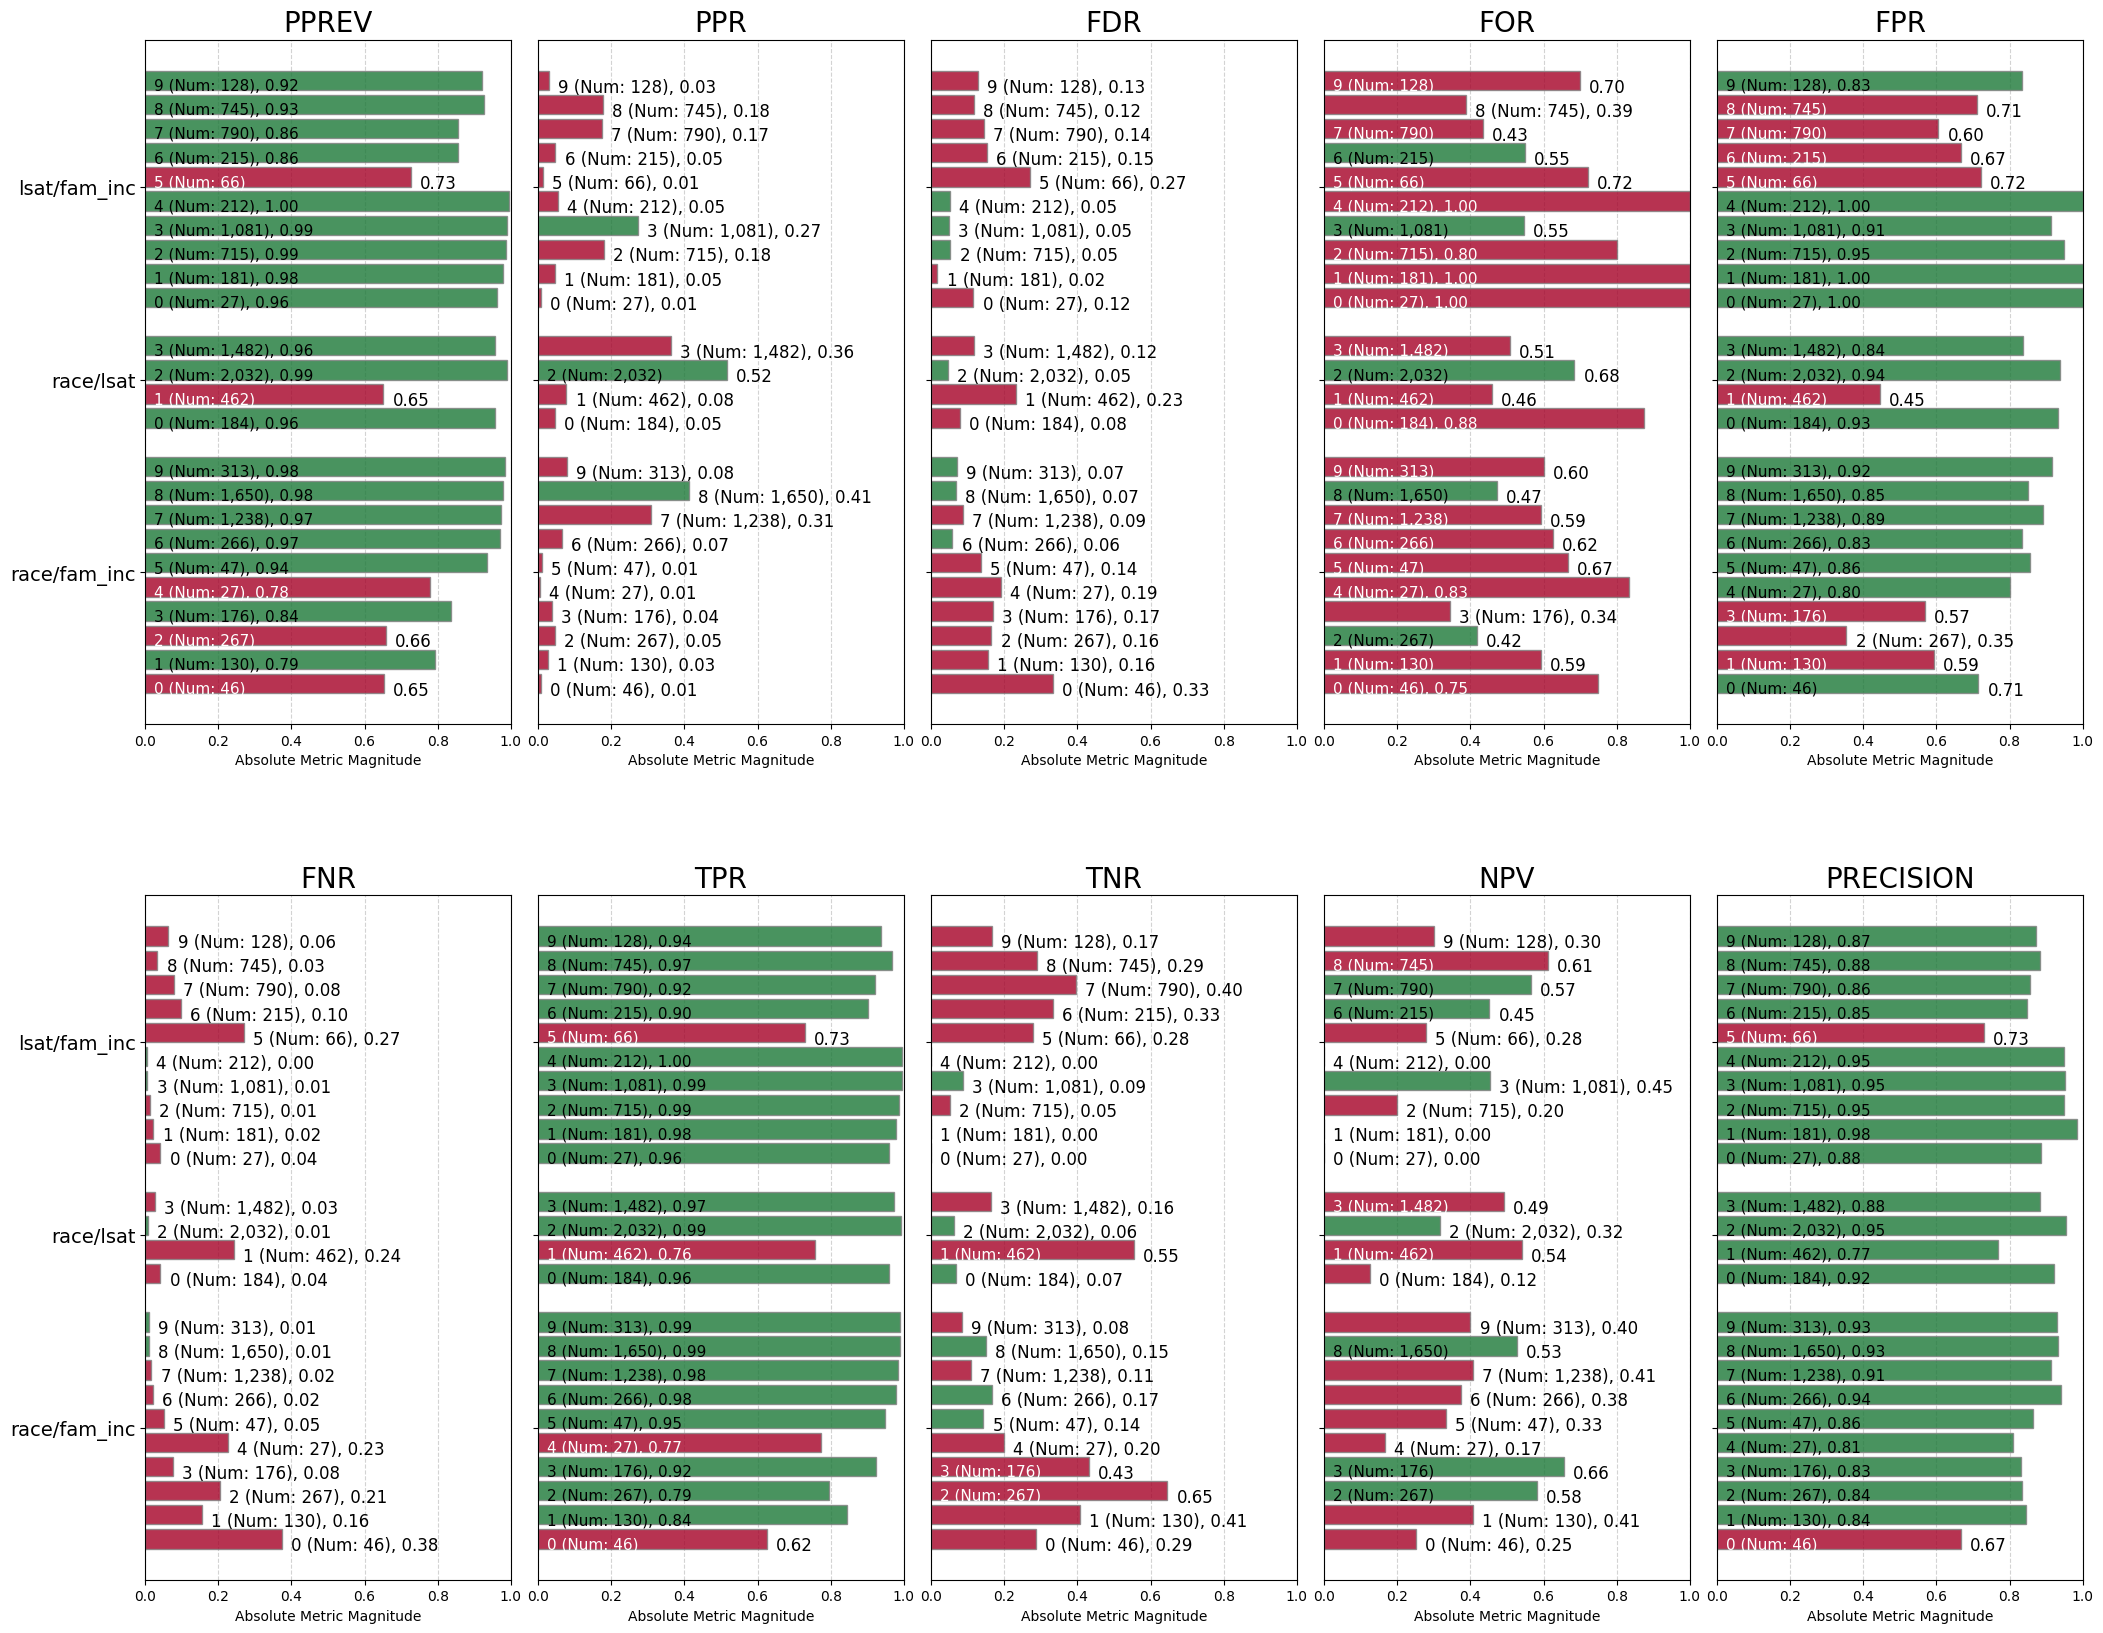

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False          False   
1         0      binary 0/1   race/fam_inc               False          False   
2         0      binary 0/1      race/lsat               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   
1       False             False         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [12]:

"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int, protected_attributes_int,target)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['RandomForest'], target, protected_attributes_int,list_of_disparities, priv,display_disp=True)


---------- Model name:  RandomForest ----------

Accuracy score training:
0.9877
Accuracy score test:
0.9680
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85       460
           1       0.98      0.99      0.98      3700

    accuracy                           0.97      4160
   macro avg       0.93      0.90      0.92      4160
weighted avg       0.97      0.97      0.97      4160



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.63  0.71  0.36  0.71  0.22  0.64   
1    race/fam_inc               1      0.83  0.90  0.35  0.65  0.10  0.65   
2    race/fam_inc               2      1.00  1.00  1.00  0.00  0.00  0.00   
3    race/fam_inc               3      1.00  1.00  1.00  0.00  0.00  0.00   
4    race/fam_inc               4      0.78  0.86  0.40  0.60  0.14  0.60   
5    race/fam_inc               5      0.91  0.98  0.40  0.33  0.07  0.60   
6    race/fam_inc               6      0.97  0.99  0.69  0.21  0.02  0.31   
7    race/fam_inc               7      0.97  0.99  0.84  0.04  0.02  0.16   
8    race/fam_inc               8      0.98  1.00  0.84  0.02  0.02  0.16   
9    race/fam_inc               9      0.97  0.98  0.85  0.29  0.01  0.15   
10      race/lsat               0      0.98  0.99  0.83  0.29  0.01  0.17   
11      race/lsat               1      0.91  0.95  0.67  0.35  0.05  0.33   
12      race/lsat               2      0.97  1.00  0.77  0.04  0.03  0.23   
13      race/lsat               3      0.98  0.99  0.92  0.08  0.01  0.08   
14   lsat/fam_inc               0      0.85  0.96  0.25  0.50  0.12  0.75   
15   lsat/fam_inc               1      0.98  0.98  0.89  0.27  0.01  0.11   
16   lsat/fam_inc               2      0.96  0.99  0.72  0.06  0.04  0.28   
17   lsat/fam_inc               3      0.97  1.00  0.79  0.02  0.03  0.21   
18   lsat/fam_inc               4      1.00  1.00  0.94  0.00  0.01  0.06   
19   lsat/fam_inc               5      0.74  0.81  0.42  0.67  0.14  0.58   
20   lsat/fam_inc               6      0.88  0.94  0.38  0.55  0.08  0.62   
21   lsat/fam_inc               7      0.99  1.00  0.97  0.02  0.00  0.03   
22   lsat/fam_inc               8      0.99  1.00  0.96  0.03  0.00  0.04   
23   lsat/fam_inc               9      0.88  0.92  0.38  0.77  0.04  0.62   

     fnr   npv  precision   ppr  pprev  prev  
0   0.29  0.29       0.78  0.01   0.70  0.76  
1   0.10  0.35       0.90  0.03   0.87  0.87  
2   0.00  1.00       1.00  0.06   0.91  0.91  
3   0.00  1.00       1.00  0.04   0.95  0.95  
4   0.14  0.40       0.86  0.01   0.81  0.81  
5   0.02  0.67       0.93  0.01   0.94  0.89  
6   0.01  0.79       0.98  0.07   0.95  0.94  
7   0.01  0.96       0.98  0.29   0.88  0.86  
8   0.00  0.98       0.98  0.40   0.90  0.89  
9   0.02  0.71       0.99  0.08   0.92  0.94  
10  0.01  0.71       0.99  0.05   0.96  0.97  
11  0.05  0.65       0.95  0.11   0.87  0.87  
12  0.00  0.96       0.97  0.49   0.91  0.89  
13  0.01  0.92       0.99  0.35   0.89  0.89  
14  0.04  0.50       0.88  0.01   0.93  0.85  
15  0.02  0.73       0.99  0.05   0.94  0.95  
16  0.01  0.94       0.96  0.17   0.91  0.88  
17  0.00  0.98       0.97  0.26   0.91  0.89  
18  0.00  1.00       0.99  0.05   0.92  0.92  
19  0.19  0.33       0.86  0.01   0.77  0.82  
20  0.06  0.45       0.92  0.05   0.91  0.89  
21  0.00  0.98       1.00  0.18   0.87  0.87  
22  0.00  0.97       1.00  0.18   0.90  0.90  
23  0.08  0.23       0.96  0.03   0.90  0.94

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0          11.24         104.64   
1    race/fam_inc               1           5.00          35.65   
2    race/fam_inc               2           0.00           0.00   
3    race/fam_inc               3           0.00           0.00   
4    race/fam_inc               4           7.01          49.94   
5    race/fam_inc               5           3.50           8.72   
6    race/fam_inc               6           1.02           4.40   
7    race/fam_inc               7           1.27           2.05   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           0.53           8.75   
10      race/lsat               0           0.19           2.53   
11      race/lsat               1           1.71          12.31   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           0.34           2.22   
14   lsat/fam_inc               0           4.54          20.87   
15   lsat/fam_inc               1           0.22           8.37   
16   lsat/fam_inc               2           1.40           3.06   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           0.19           0.00   
19   lsat/fam_inc               5           5.19          88.89   
20   lsat/fam_inc               6           2.91          27.64   
21   lsat/fam_inc               7           0.17           1.40   
22   lsat/fam_inc               8           0.17           1.43   
23   lsat/fam_inc               9           1.65          40.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           28.57           4.06           0.29           0.02   
1           25.88           4.13           0.36           0.08   
2            0.00           0.00           1.03           0.16   
3            0.00           0.00           1.03           0.11   
4           24.00           3.83           0.41           0.01   
5           13.33           3.83           0.68           0.03   
6            8.57           1.99           0.81           0.17   
7            1.63           1.03           0.98           0.73   
8            1.00           1.00           1.00           1.00   
9           11.67           0.96           0.73           0.19   
10           6.64           0.72           0.75           0.10   
11           8.25           1.43           0.67           0.22   
12           1.00           1.00           1.00           1.00   
13           1.87           0.34           0.96           0.72   
14          24.25           3.49           0.51           0.03   
15          13.23           0.52           0.74           0.17   
16           2.90           1.28           0.96           0.66   
17           1.00           1.00           1.00           1.00   
18           0.00           0.27           1.02           0.20   
19          32.33           2.71           0.34           0.05   
20          26.68           2.91           0.46           0.20   
21           0.92           0.13           1.00           0.70   
22           1.37           0.19           0.99           0.68   
23          37.31           2.91           0.24           0.12   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.77                 0.80           0.43           0.72  
1              0.96                 0.92           0.42           0.91  
2              1.00                 1.02           1.19           1.00  
3              1.06                 1.02           1.19           1.00  
4              0.90                 0.88           0.47           0.87  
5              1.04                 0.95           0.47           0.98  
6              1.05                 1.00           0.82           0.99  
7              0.98                 0.99           1.00           1.00  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc      23.794444       2.203333
race/lsat          5.686667       0.830000
lsat/fam_inc      21.295556       1.601111
Overall average for fnr_disparity:  16.926
Overall average for fpr_disparity:  1.545


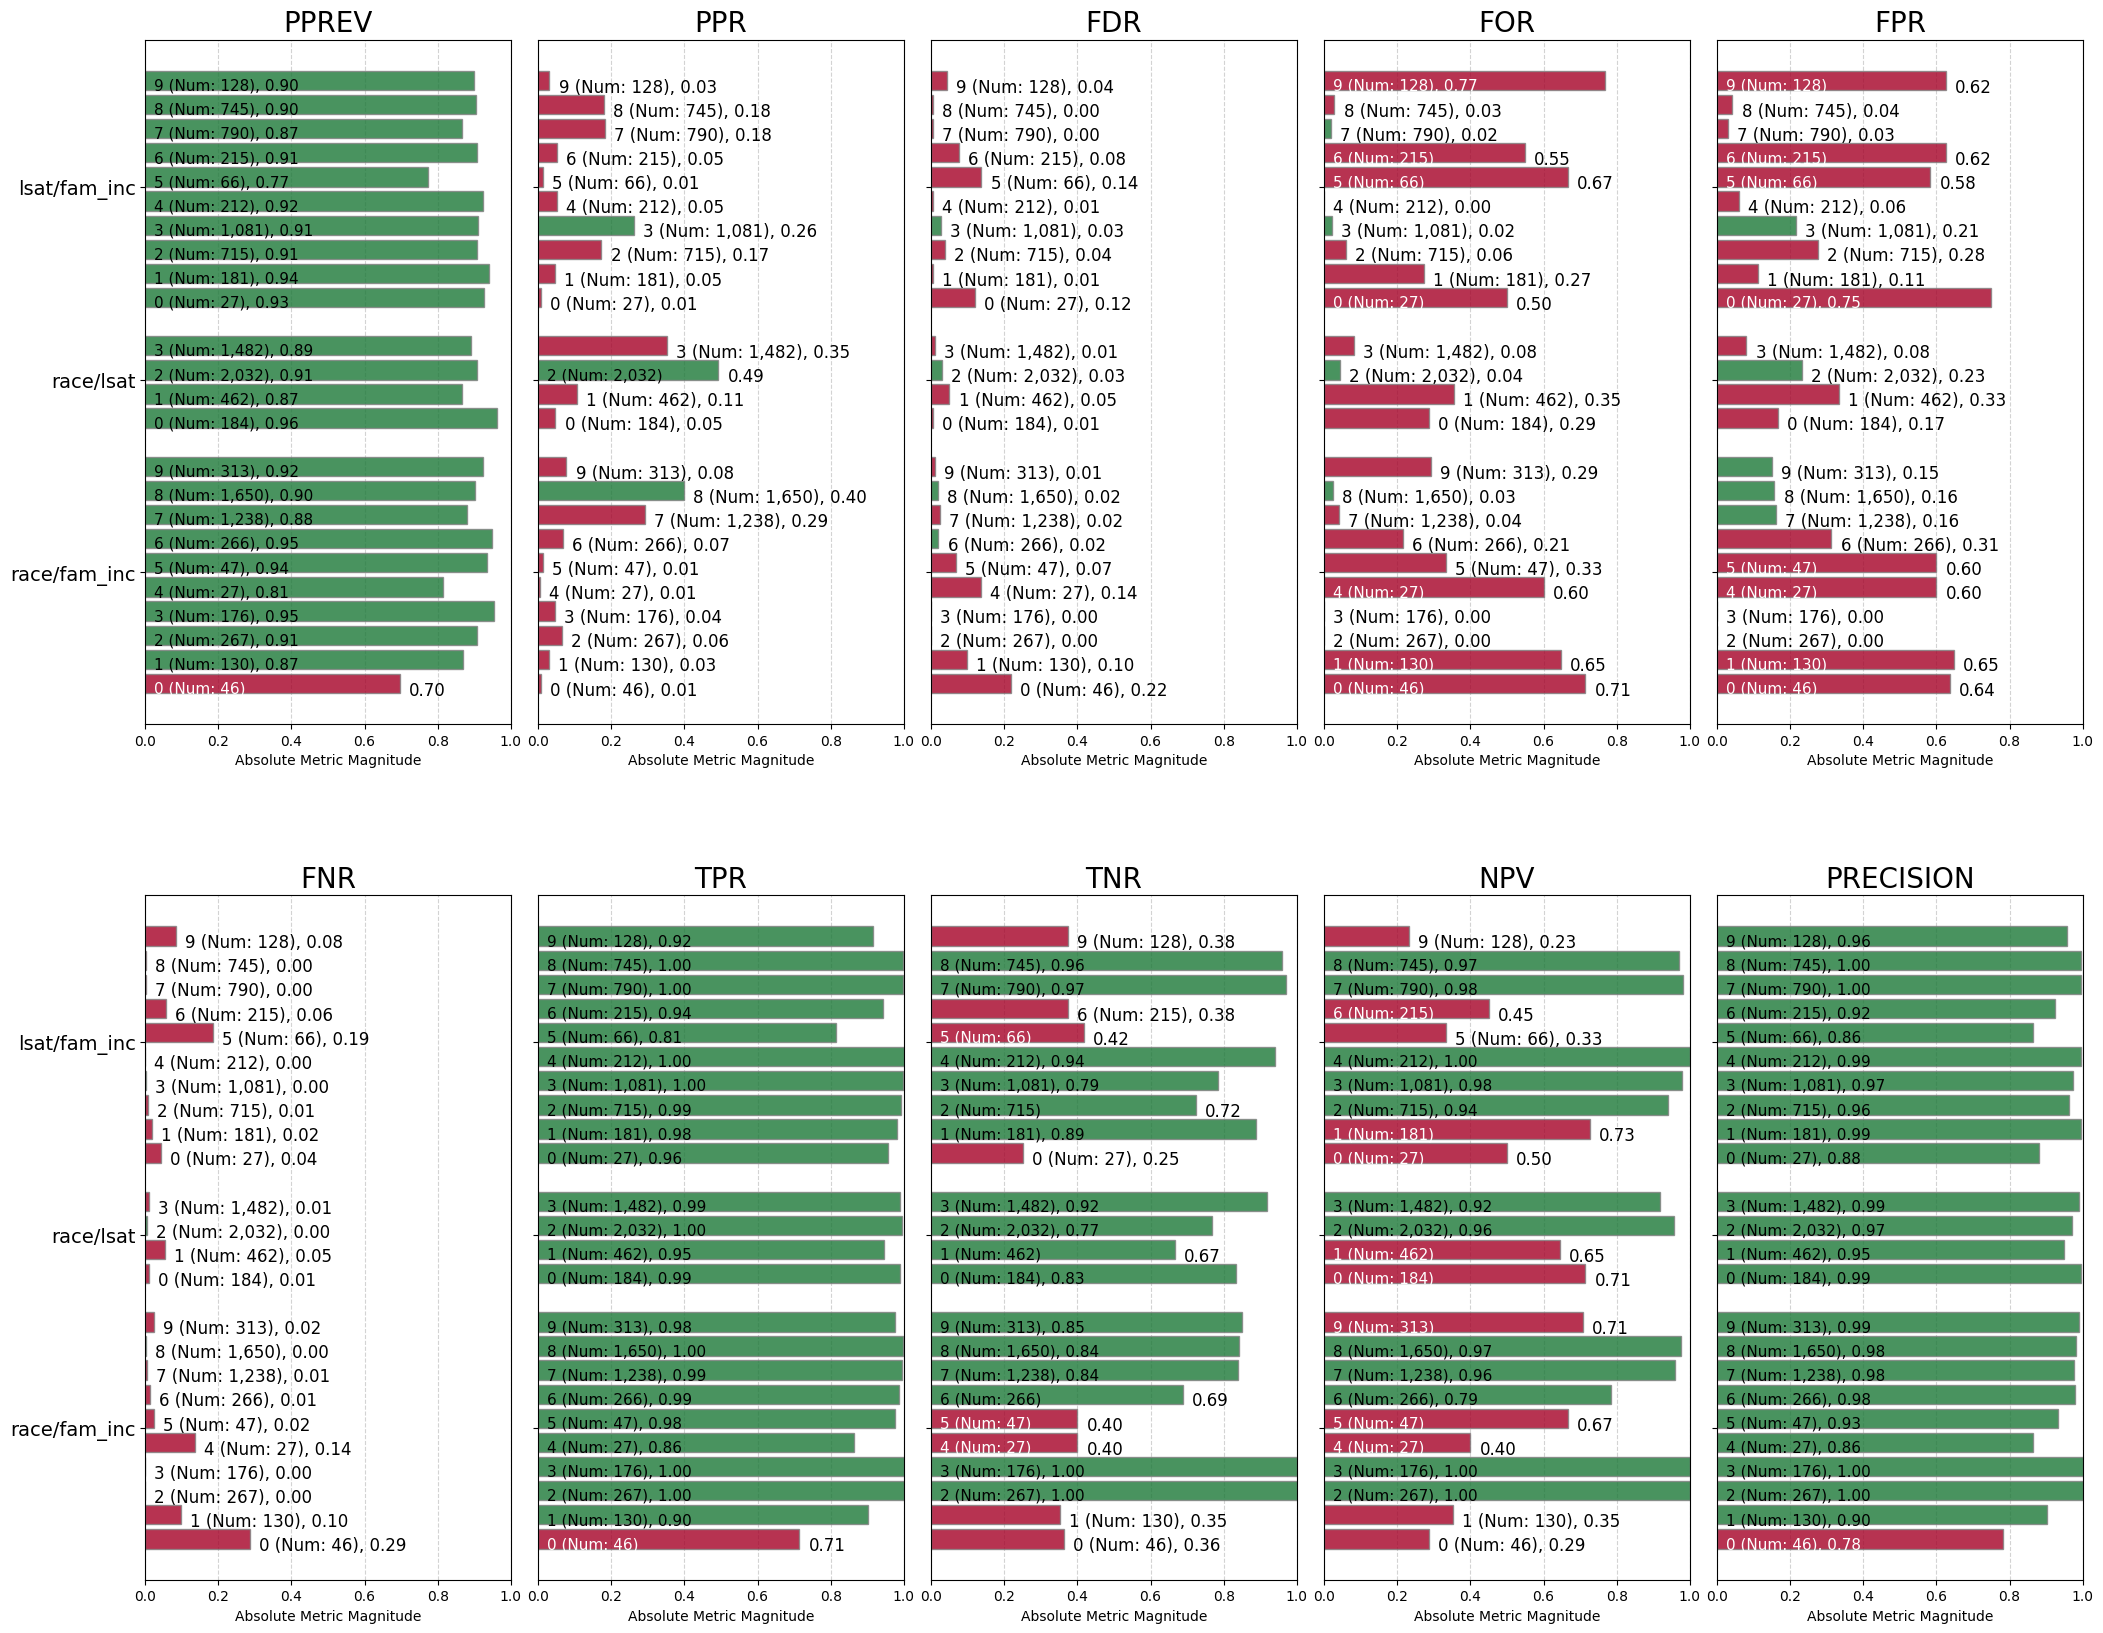

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False          False   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False       False       False   
2       False       False       False       False        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False             False         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [17]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = prep_massaging(df_num_int, protected_attributes_int, target)
#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_to_transform,protected_attributes_int,target)
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["RandomForest"],target,protected_attributes_int,list_of_disparities, priv, display_disp=True)

# compare disparities to the original dataset
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed, protected_attributes_int)

[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 9 size: 1541


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 1541


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 9 size: 907


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 907


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 8 size: 8199


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 8199


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 8 size: 5660


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 5660


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 7 size: 6131


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 6131


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 7 size: 4744


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 4744


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 2 size: 1338


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 1338


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 2 size: 1061


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 1061


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 3 size: 980


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 980


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 3 size: 853


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 853


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 5 size: 209


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 209


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 5 size: 181


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 181


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 6 size: 1413


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 1413


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 6 size: 998


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 998


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 4 size: 152


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 152


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 4 size: 137


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 137


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 1 size: 625


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 625


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 1 size: 477


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 477


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 0 size: 212


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 212


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 0 size: 160


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 160


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 2 size: 7122


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 7122


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 2 size: 4098


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 4098


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 3 size: 5368


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 5368


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 3 size: 4994


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 4994


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 1 size: 1777


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 1777


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 1 size: 1701


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 1701


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 0 size: 911


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 911


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 0 size: 299


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 299


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 4 size: 394


INFO:methods.preprocessing.PrevalenceSampling:Original group 4 size: 394


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 4 size: 390


INFO:methods.preprocessing.PrevalenceSampling:Final group 4 size: 390


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 2 size: 1588


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 1588


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 2 size: 1568


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 1568


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 3 size: 2019


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 2019


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 3 size: 1985


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 1985


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 8 size: 2602


INFO:methods.preprocessing.PrevalenceSampling:Original group 8 size: 2602


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 8 size: 2584


INFO:methods.preprocessing.PrevalenceSampling:Final group 8 size: 2584


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 7 size: 2772


INFO:methods.preprocessing.PrevalenceSampling:Original group 7 size: 2772


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 7 size: 2682


INFO:methods.preprocessing.PrevalenceSampling:Final group 7 size: 2682


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 5 size: 204


INFO:methods.preprocessing.PrevalenceSampling:Original group 5 size: 204


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 5 size: 199


INFO:methods.preprocessing.PrevalenceSampling:Final group 5 size: 199


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 6 size: 775


INFO:methods.preprocessing.PrevalenceSampling:Original group 6 size: 775


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 6 size: 671


INFO:methods.preprocessing.PrevalenceSampling:Final group 6 size: 671


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 1 size: 320


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 320


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 1 size: 315


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 315


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 9 size: 342


INFO:methods.preprocessing.PrevalenceSampling:Original group 9 size: 342


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 9 size: 335


INFO:methods.preprocessing.PrevalenceSampling:Final group 9 size: 335


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Original group 0 size: 76


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 76


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Final group 0 size: 74


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 74


[INFO] 2024-11-20 20:15:37 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  RandomForest ----------

Accuracy score training:
0.9498
Accuracy score test:
0.8903
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.45      0.22      0.29       225
           1       0.91      0.97      0.94      1936

    accuracy                           0.89      2161
   macro avg       0.68      0.59      0.62      2161
weighted avg       0.87      0.89      0.87      2161



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.79  0.95  0.00  1.00  0.17  1.00   
1    race/fam_inc               1      0.88  0.98  0.00  1.00  0.11  1.00   
2    race/fam_inc               2      0.85  0.94  0.06  0.91  0.10  0.94   
3    race/fam_inc               3      0.88  0.96  0.10  0.80  0.08  0.90   
4    race/fam_inc               4      1.00  1.00  1.00  0.00  0.00  0.00   
5    race/fam_inc               5      0.74  0.88  0.00  1.00  0.18  1.00   
6    race/fam_inc               6      0.88  0.96  0.24  0.56  0.09  0.76   
7    race/fam_inc               7      0.90  0.98  0.19  0.43  0.09  0.81   
8    race/fam_inc               8      0.90  0.97  0.30  0.49  0.08  0.70   
9    race/fam_inc               9      0.91  0.98  0.23  0.50  0.07  0.77   
10      race/lsat               0      0.91  1.00  0.20  0.00  0.09  0.80   
11      race/lsat               1      0.86  0.95  0.09  0.84  0.10  0.91   
12      race/lsat               2      0.89  0.97  0.29  0.47  0.08  0.71   
13      race/lsat               3      0.90  0.97  0.20  0.54  0.08  0.80   
14   lsat/fam_inc               0      0.67  1.00  0.00   NaN  0.33  1.00   
15   lsat/fam_inc               1      0.88  0.96  0.22  0.60  0.09  0.78   
16   lsat/fam_inc               2      0.90  0.98  0.24  0.42  0.08  0.76   
17   lsat/fam_inc               3      0.89  0.96  0.34  0.46  0.08  0.66   
18   lsat/fam_inc               4      0.91  0.98  0.33  0.40  0.07  0.67   
19   lsat/fam_inc               5      0.79  0.89  0.00  1.00  0.13  1.00   
20   lsat/fam_inc               6      0.88  0.98  0.13  0.60  0.10  0.87   
21   lsat/fam_inc               7      0.88  0.97  0.12  0.68  0.09  0.88   
22   lsat/fam_inc               8      0.90  0.97  0.23  0.58  0.08  0.77   
23   lsat/fam_inc               9      0.93  0.98  0.33  0.33  0.06  0.67   

     fnr   npv  precision   ppr  pprev  prev  
0   0.05  0.00       0.83  0.01   0.96  0.83  
1   0.02  0.00       0.89  0.03   0.98  0.89  
2   0.06  0.09       0.90  0.08   0.94  0.90  
3   0.04  0.20       0.92  0.05   0.96  0.91  
4   0.00  1.00       1.00  0.01   0.89  0.89  
5   0.12  0.00       0.82  0.01   0.90  0.84  
6   0.04  0.44       0.91  0.07   0.94  0.89  
7   0.02  0.57       0.91  0.31   0.96  0.90  
8   0.03  0.51       0.92  0.36   0.94  0.90  
9   0.02  0.50       0.93  0.07   0.96  0.91  
10  0.00  1.00       0.91  0.02   0.98  0.89  
11  0.05  0.16       0.90  0.16   0.95  0.90  
12  0.03  0.53       0.92  0.37   0.94  0.89  
13  0.03  0.46       0.92  0.45   0.96  0.90  
14  0.00   NaN       0.67  0.01   1.00  0.67  
15  0.04  0.40       0.91  0.04   0.94  0.89  
16  0.02  0.58       0.92  0.13   0.96  0.90  
17  0.04  0.54       0.92  0.17   0.93  0.88  
18  0.02  0.60       0.93  0.04   0.95  0.90  
19  0.11  0.00       0.87  0.02   0.91  0.88  
20  0.02  0.40       0.90  0.07   0.96  0.89  
21  0.03  0.32       0.91  0.25   0.96  0.90  
22  0.03  0.42       0.92  0.24   0.95  0.91  
23  0.02  0.67       0.94  0.03   0.96  0.91

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 3
Majority class for:  lsat/fam_inc  is: 7
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           2.25           1.46   
1    race/fam_inc               1           1.43           0.51   
2    race/fam_inc               2           1.24           1.82   
3    race/fam_inc               3           1.09           1.15   
4    race/fam_inc               4           0.00           0.00   
5    race/fam_inc               5           2.31           3.38   
6    race/fam_inc               6           1.14           1.05   
7    race/fam_inc               7           1.13           0.50   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           0.94           0.68   
10      race/lsat               0           1.10           0.00   
11      race/lsat               1           1.17           2.00   
12      race/lsat               2           1.03           1.27   
13      race/lsat               3           1.00           1.00   
14   lsat/fam_inc               0           3.55           0.00   
15   lsat/fam_inc               1           0.98           1.36   
16   lsat/fam_inc               2           0.86           0.64   
17   lsat/fam_inc               3           0.88           1.27   
18   lsat/fam_inc               4           0.73           0.78   
19   lsat/fam_inc               5           1.37           3.42   
20   lsat/fam_inc               6           1.03           0.79   
21   lsat/fam_inc               7           1.00           1.00   
22   lsat/fam_inc               8           0.80           1.04   
23   lsat/fam_inc               9           0.65           0.52   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            2.04           1.44           0.00           0.03   
1            2.04           1.44           0.00           0.09   
2            1.86           1.35           0.18           0.23   
3            1.63           1.29           0.39           0.15   
4            0.00           0.00           1.96           0.02   
5            2.04           1.44           0.00           0.04   
6            1.13           1.10           0.87           0.20   
7            0.89           1.16           1.11           0.85   
8            1.00           1.00           1.00           1.00   
9            1.02           1.11           0.98           0.19   
10           0.00           1.00           2.16           0.05   
11           1.57           1.14           0.34           0.36   
12           0.87           0.89           1.15           0.82   
13           1.00           1.00           1.00           1.00   
14            NaN           1.14            NaN           0.02   
15           0.88           0.89           1.26           0.15   
16           0.61           0.87           1.83           0.52   
17           0.68           0.75           1.68           0.67   
18           0.59           0.76           1.89           0.17   
19           1.47           1.14           0.00           0.07   
20           0.88           0.99           1.26           0.26   
21           1.00           1.00           1.00           1.00   
22           0.85           0.88           1.33           0.94   
23           0.49           0.76           2.10           0.13   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.02                 0.90           0.00           0.98  
1              1.05                 0.96           0.00           1.02  
2              1.00                 0.98           0.19           0.97  
3              1.02                 0.99           0.33           0.99  
4              0.95                 1.08           3.28           1.04  
5              0.96                 0.89           0.00           0.92  
6              1.01                 0.99           0.77           1.00  
7              1.03                 0.99           0.63           1.02  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc       1.172222       1.147778
race/lsat          1.000000       1.046667
lsat/fam_inc       1.061111       0.936667
Overall average for fnr_disparity:  1.078
Overall average for fpr_disparity:  1.044


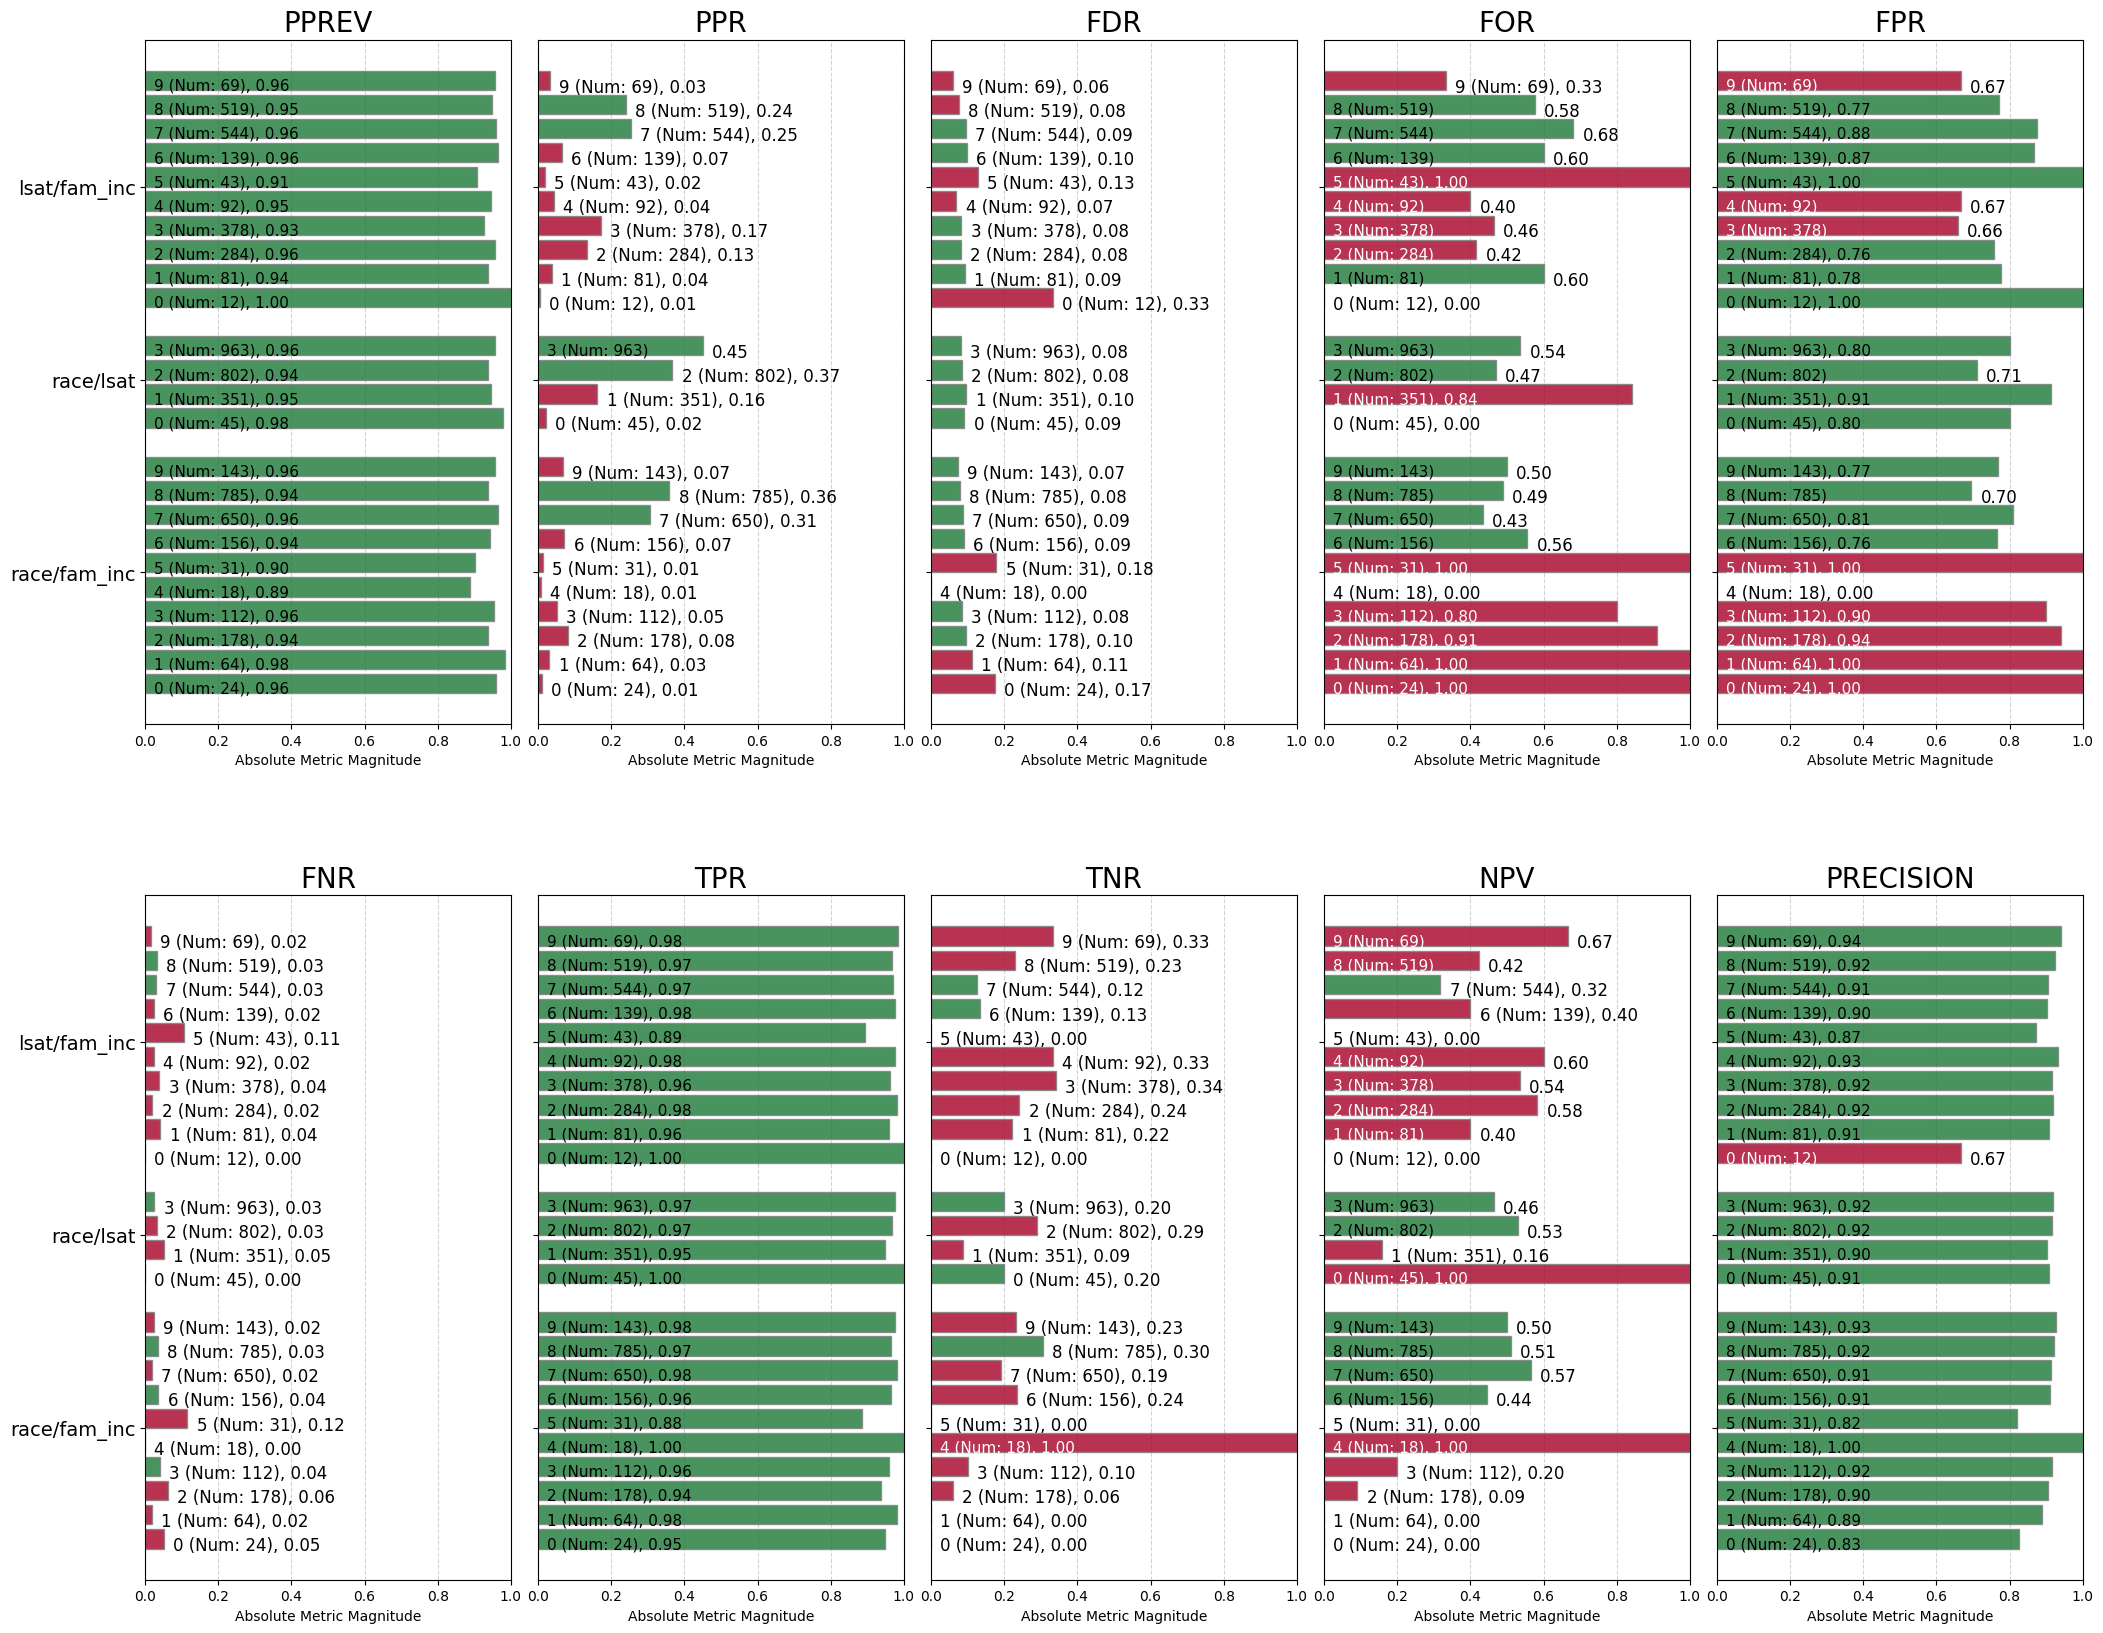

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False        True       False   
2        True        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   
1       False              True         False          False           False   
2       False              True          True          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [22]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps = prep_prev_sampling(data_to_transform, protected_attributes_int, target)
#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps,protected_attributes_int,target)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["RandomForest"],target,protected_attributes_int,list_of_disparities, priv,display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_transformed_ps, protected_attributes_int)

---------- Model name:  RandomForest ----------

Accuracy score training:
0.9326
Accuracy score test:
0.8841
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.47      0.24      0.32       467
           1       0.91      0.97      0.94      3693

    accuracy                           0.88      4160
   macro avg       0.69      0.60      0.63      4160
weighted avg       0.86      0.88      0.87      4160



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.63  0.72  0.43  0.60  0.26  0.57   
1    race/fam_inc               1      0.76  0.85  0.41  0.58  0.15  0.59   
2    race/fam_inc               2      0.73  0.79  0.57  0.45  0.19  0.43   
3    race/fam_inc               3      0.78  0.90  0.43  0.41  0.17  0.57   
4    race/fam_inc               4      0.74  0.86  0.20  0.75  0.17  0.80   
5    race/fam_inc               5      0.89  1.00  0.29  0.00  0.11  0.71   
6    race/fam_inc               6      0.92  0.97  0.22  0.64  0.05  0.78   
7    race/fam_inc               7      0.89  0.98  0.08  0.71  0.09  0.92   
8    race/fam_inc               8      0.92  0.99  0.11  0.58  0.07  0.89   
9    race/fam_inc               9      0.92  0.99  0.04  0.75  0.07  0.96   
10      race/lsat               0      0.89  0.97  0.00  1.00  0.08  1.00   
11      race/lsat               1      0.68  0.76  0.54  0.46  0.24  0.46   
12      race/lsat               2      0.95  0.99  0.01  0.93  0.05  0.99   
13      race/lsat               3      0.86  0.97  0.15  0.57  0.12  0.85   
14   lsat/fam_inc               0      0.85  0.96  0.00  1.00  0.12  1.00   
15   lsat/fam_inc               1      0.96  0.97  0.00  1.00  0.02  1.00   
16   lsat/fam_inc               2      0.93  0.99  0.00  1.00  0.06  1.00   
17   lsat/fam_inc               3      0.95  1.00  0.02  0.67  0.05  0.98   
18   lsat/fam_inc               4      0.94  0.99  0.00  1.00  0.05  1.00   
19   lsat/fam_inc               5      0.73  0.83  0.44  0.50  0.20  0.56   
20   lsat/fam_inc               6      0.80  0.90  0.36  0.53  0.15  0.64   
21   lsat/fam_inc               7      0.80  0.92  0.35  0.48  0.16  0.65   
22   lsat/fam_inc               8      0.85  0.95  0.28  0.48  0.12  0.72   
23   lsat/fam_inc               9      0.84  0.96  0.11  0.67  0.13  0.89   

     fnr   npv  precision   ppr  pprev  prev  
0   0.28  0.40       0.74  0.01   0.67  0.70  
1   0.15  0.42       0.85  0.03   0.80  0.79  
2   0.21  0.55       0.81  0.05   0.68  0.69  
3   0.10  0.59       0.83  0.04   0.82  0.75  
4   0.14  0.25       0.83  0.01   0.85  0.81  
5   0.00  1.00       0.89  0.01   0.96  0.85  
6   0.03  0.36       0.95  0.07   0.96  0.93  
7   0.02  0.29       0.91  0.31   0.97  0.90  
8   0.01  0.42       0.93  0.41   0.98  0.92  
9   0.01  0.25       0.93  0.08   0.99  0.92  
10  0.03  0.00       0.92  0.05   0.97  0.92  
11  0.24  0.54       0.76  0.08   0.66  0.66  
12  0.01  0.07       0.95  0.52   0.99  0.95  
13  0.03  0.43       0.88  0.36   0.95  0.87  
14  0.04  0.00       0.88  0.01   0.96  0.89  
15  0.03  0.00       0.98  0.04   0.97  0.98  
16  0.01  0.00       0.94  0.18   0.99  0.95  
17  0.00  0.33       0.95  0.28   1.00  0.95  
18  0.01  0.00       0.95  0.05   0.99  0.95  
19  0.17  0.50       0.80  0.01   0.76  0.73  
20  0.10  0.47       0.85  0.05   0.85  0.80  
21  0.08  0.52       0.84  0.17   0.86  0.79  
22  0.05  0.52       0.88  0.17   0.92  0.85  
23  0.04  0.33       0.87  0.03   0.95  0.86

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           3.69          22.54   
1    race/fam_inc               1           2.20          11.67   
2    race/fam_inc               2           2.75          16.46   
3    race/fam_inc               3           2.48           7.89   
4    race/fam_inc               4           2.49          10.93   
5    race/fam_inc               5           1.59           0.00   
6    race/fam_inc               6           0.79           2.26   
7    race/fam_inc               7           1.30           1.58   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.07           0.83   
10      race/lsat               0           1.74           4.40   
11      race/lsat               1           4.98          35.61   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           2.47           4.40   
14   lsat/fam_inc               0           2.22          21.33   
15   lsat/fam_inc               1           0.33          14.38   
16   lsat/fam_inc               2           1.06           6.06   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           1.01           5.09   
19   lsat/fam_inc               5           3.85          85.33   
20   lsat/fam_inc               6           2.84          50.31   
21   lsat/fam_inc               7           2.99          42.39   
22   lsat/fam_inc               8           2.31          24.34   
23   lsat/fam_inc               9           2.52          18.62   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.04           0.64           0.94           0.02   
1            1.00           0.67           1.00           0.06   
2            0.78           0.48           1.30           0.11   
3            0.71           0.64           1.40           0.09   
4            1.30           0.90           0.59           0.01   
5            0.00           0.80           2.36           0.03   
6            1.11           0.87           0.86           0.16   
7            1.23           1.04           0.68           0.75   
8            1.00           1.00           1.00           1.00   
9            1.30           1.08           0.59           0.19   
10           1.08           1.01           0.00           0.09   
11           0.50           0.47           7.49           0.15   
12           1.00           1.00           1.00           1.00   
13           0.61           0.86           6.06           0.70   
14           1.50           1.02           0.00           0.02   
15           1.50           1.02           0.00           0.16   
16           1.50           1.02           0.00           0.66   
17           1.00           1.00           1.00           1.00   
18           1.50           1.02           0.00           0.19   
19           0.75           0.57           1.50           0.05   
20           0.80           0.65           1.41           0.17   
21           0.72           0.67           1.56           0.63   
22           0.73           0.73           1.55           0.63   
23           1.00           0.90           1.00           0.11   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.69                 0.80           3.89           0.73  
1              0.82                 0.91           3.70           0.87  
2              0.70                 0.87           5.20           0.80  
3              0.83                 0.89           3.92           0.91  
4              0.87                 0.89           1.81           0.87  
5              0.98                 0.96           2.59           1.01  
6              0.98                 1.02           2.02           0.98  
7              0.99                 0.98           0.69           0.99  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc       8.240000       0.791111
race/lsat         14.803333       0.780000
lsat/fam_inc      29.761111       0.844444
Overall average for fnr_disparity:  17.601
Overall average for fpr_disparity:  0.805


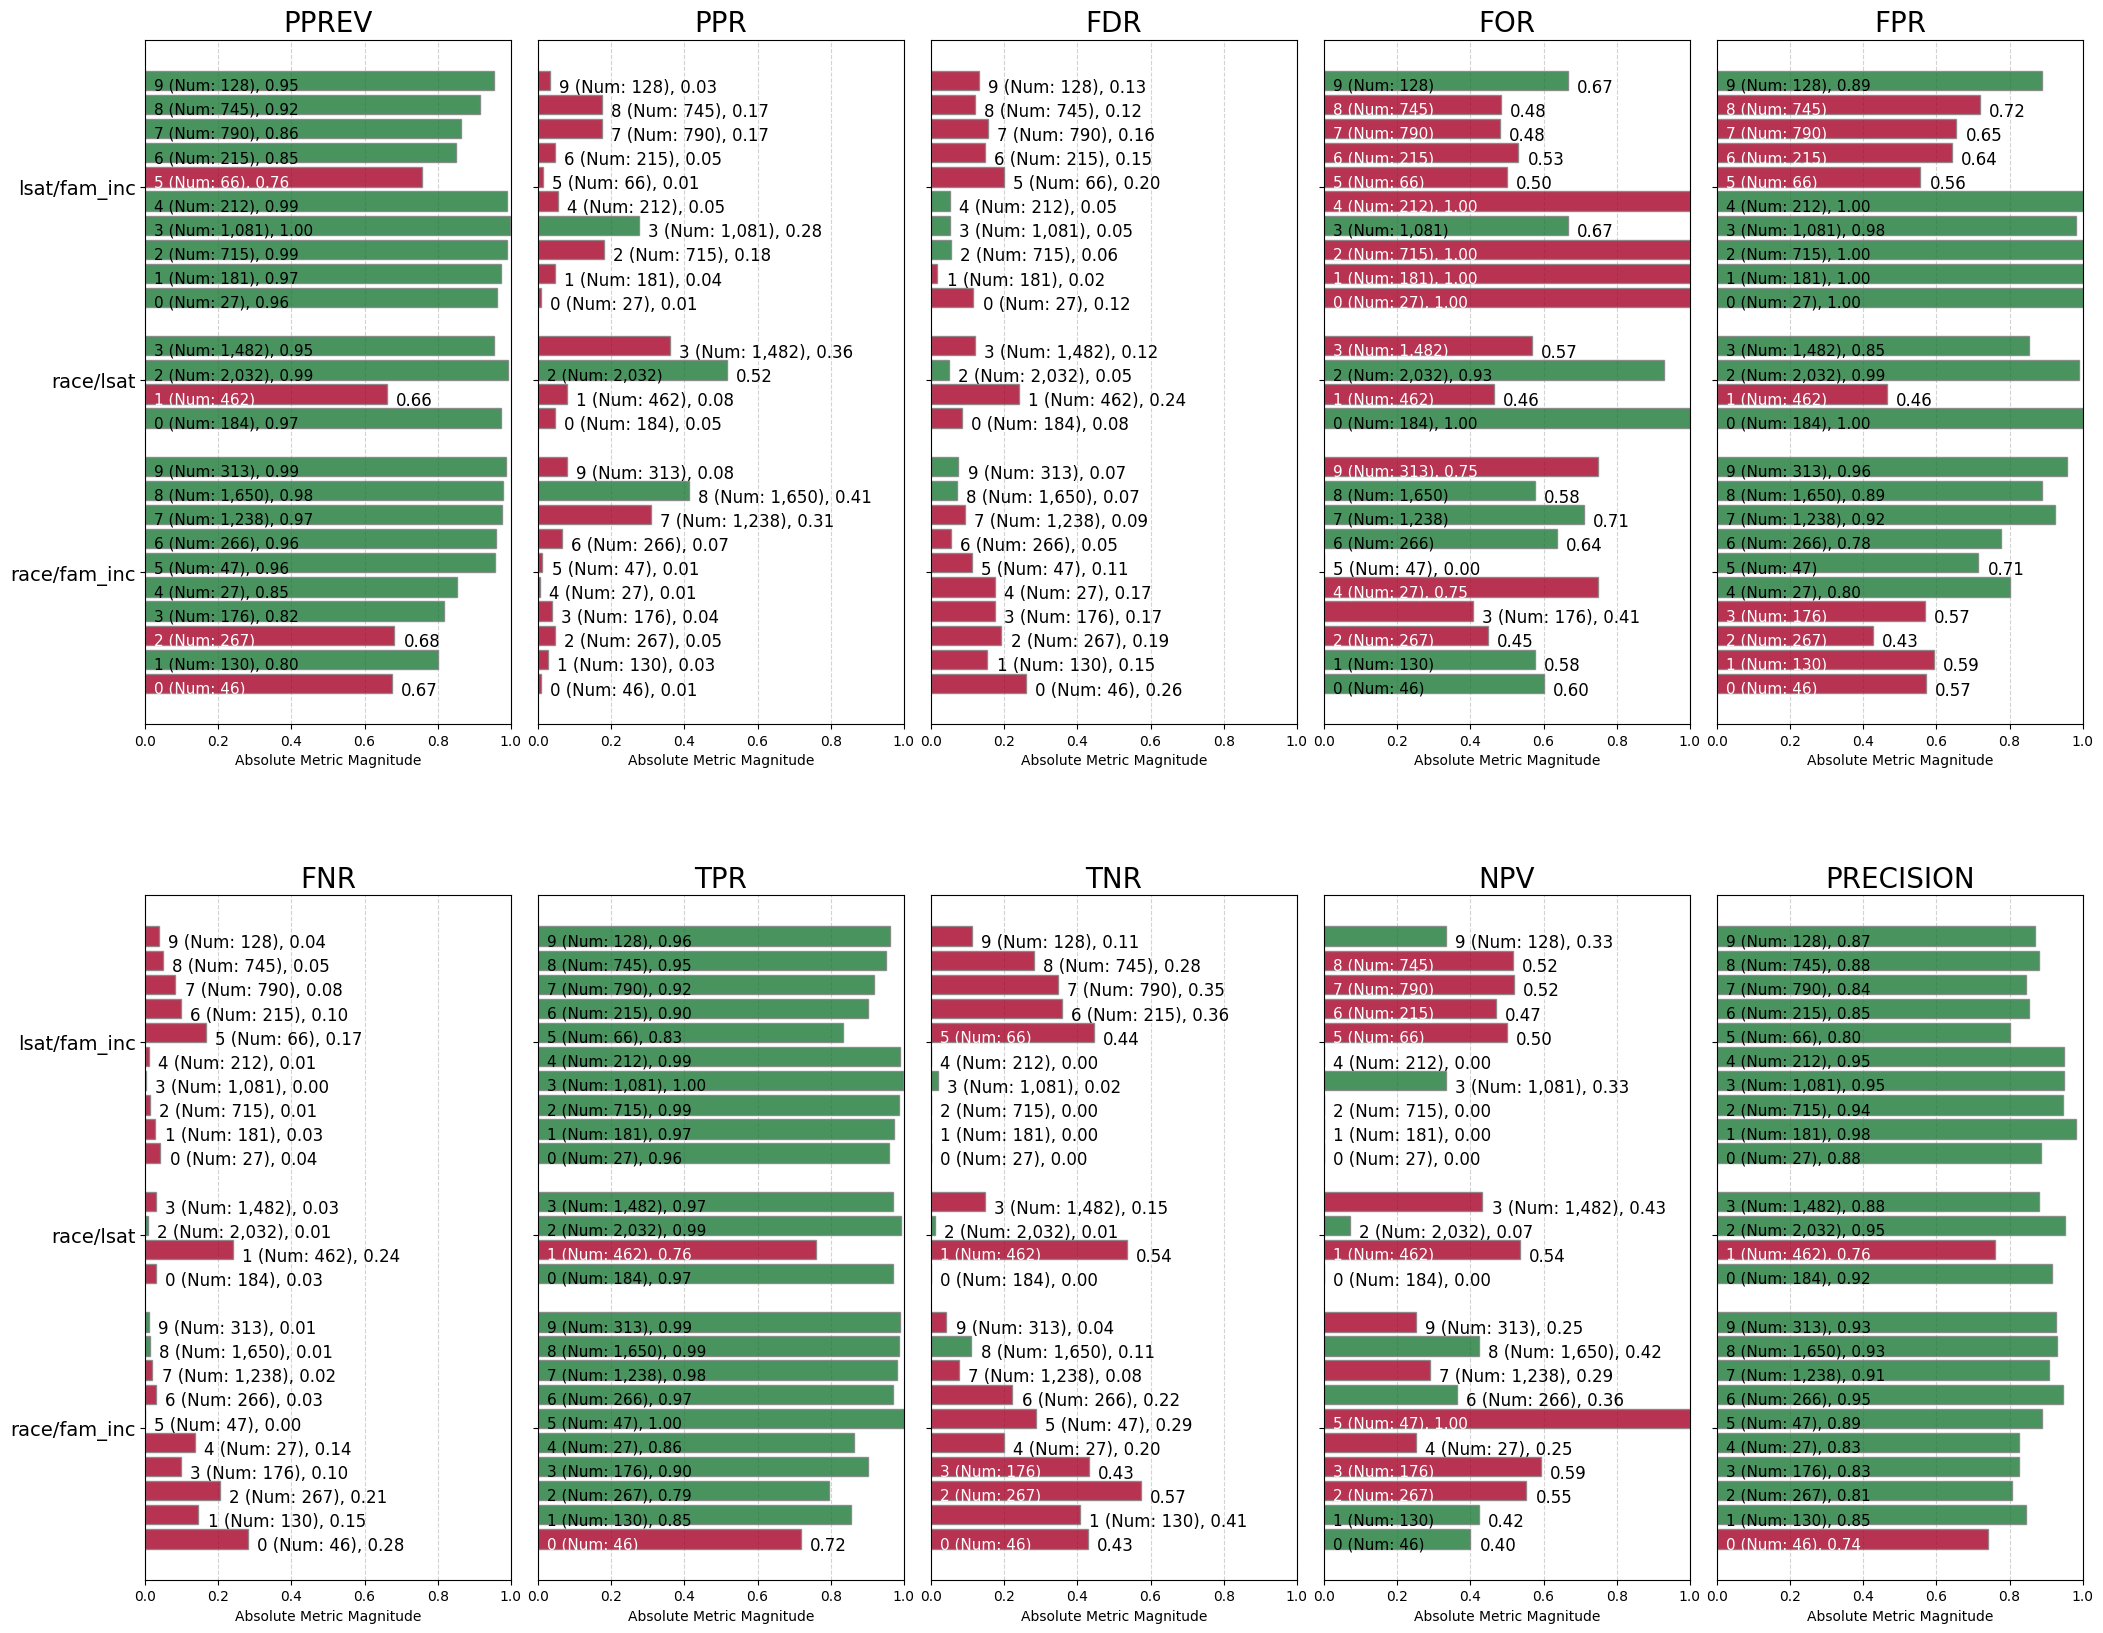

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False          False   
1         0      binary 0/1   race/fam_inc               False          False   
2         0      binary 0/1      race/lsat               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False             False         False          False           False   
2       False             False         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [23]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''
df_num_int["ugpagt3"] = df_num_int["ugpagt3"].astype(int)
data_to_transform = prep_data_repairer(df_num_int, protected_attributes_int, target)
#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_to_transform,protected_attributes_int,target)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["RandomForest"],target,protected_attributes_int,list_of_disparities, priv,display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)

[INFO] 2024-11-20 20:16:52 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:16:52 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Flipped 539 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 539 instances.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Flipped 619 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 619 instances.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 20:16:53 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 20:16:54 methods.preprocessing.LabelFlipping - Flipped 950 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 950 instances.


[INFO] 2024-11-20 20:16:54 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  RandomForest ----------

Accuracy score training:
0.9978
Accuracy score test:
0.9885
----------------------------------------

Classification report for model: RandomForestClassifier(max_depth=14, n_estimators=500, random_state=7) : 
               precision    recall  f1-score   support

           0       0.74      0.37      0.49        63
           1       0.99      1.00      0.99      4097

    accuracy                           0.99      4160
   macro avg       0.87      0.68      0.74      4160
weighted avg       0.99      0.99      0.99      4160



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      1.00  1.00   NaN   NaN  0.00   NaN   
1    race/fam_inc               1      0.99  1.00  0.67  0.00  0.01  0.33   
2    race/fam_inc               2      0.96  1.00  0.27  0.20  0.04  0.73   
3    race/fam_inc               3      0.98  1.00  0.62  0.00  0.02  0.38   
4    race/fam_inc               4      0.89  0.96  0.33  0.50  0.08  0.67   
5    race/fam_inc               5      0.98  1.00  0.00   NaN  0.02  1.00   
6    race/fam_inc               6      1.00  1.00  0.50  0.00  0.00  0.50   
7    race/fam_inc               7      1.00  1.00  0.00   NaN  0.00  1.00   
8    race/fam_inc               8      0.99  1.00  0.38  0.25  0.01  0.62   
9    race/fam_inc               9      0.99  0.99  0.50  0.75  0.00  0.50   
10      race/lsat               0      0.98  1.00  0.25  0.00  0.02  0.75   
11      race/lsat               1      0.97  1.00  0.44  0.15  0.03  0.56   
12      race/lsat               2      0.99  1.00  0.32  0.18  0.01  0.68   
13      race/lsat               3      0.99  1.00  0.33  0.67  0.00  0.67   
14   lsat/fam_inc               0      1.00  1.00   NaN   NaN  0.00   NaN   
15   lsat/fam_inc               1      1.00  1.00  1.00  0.00  0.00  0.00   
16   lsat/fam_inc               2      0.99  1.00  0.00   NaN  0.01  1.00   
17   lsat/fam_inc               3      0.98  1.00  0.35  0.20  0.01  0.65   
18   lsat/fam_inc               4      1.00  1.00  0.50  0.00  0.00  0.50   
19   lsat/fam_inc               5      0.98  1.00  0.00   NaN  0.02  1.00   
20   lsat/fam_inc               6      0.99  1.00  0.50  0.00  0.01  0.50   
21   lsat/fam_inc               7      0.99  1.00  0.29  0.20  0.01  0.71   
22   lsat/fam_inc               8      0.99  1.00  0.67  0.14  0.00  0.33   
23   lsat/fam_inc               9      0.95  0.97  0.33  0.80  0.02  0.67   

     fnr   npv  precision   ppr  pprev  prev  
0   0.00   NaN       1.00  0.01   1.00  1.00  
1   0.00  1.00       0.99  0.03   0.98  0.98  
2   0.00  0.80       0.96  0.06   0.98  0.94  
3   0.00  1.00       0.98  0.04   0.97  0.95  
4   0.04  0.50       0.92  0.01   0.93  0.89  
5   0.00   NaN       0.98  0.01   1.00  0.98  
6   0.00  1.00       1.00  0.06   1.00  0.99  
7   0.00   NaN       1.00  0.30   1.00  1.00  
8   0.00  0.75       0.99  0.40   0.99  0.99  
9   0.01  0.25       1.00  0.07   0.99  0.99  
10  0.00  1.00       0.98  0.04   0.99  0.98  
11  0.00  0.85       0.97  0.11   0.97  0.95  
12  0.00  0.82       0.99  0.49   0.99  0.99  
13  0.00  0.33       1.00  0.36   1.00  1.00  
14  0.00   NaN       1.00  0.01   1.00  1.00  
15  0.00  1.00       1.00  0.04   0.99  0.99  
16  0.00   NaN       0.99  0.17   1.00  0.99  
17  0.00  0.80       0.99  0.26   0.99  0.98  
18  0.00  1.00       1.00  0.05   1.00  0.99  
19  0.00   NaN       0.98  0.02   1.00  0.98  
20  0.00  1.00       0.99  0.05   0.99  0.98  
21  0.00  0.80       0.99  0.19   0.99  0.98  
22  0.00  0.86       1.00  0.18   0.99  0.99  
23  0.03  0.20       0.98  0.03   0.96  0.98

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           0.00           0.00   
1    race/fam_inc               1           0.85           0.00   
2    race/fam_inc               2           4.58           2.15   
3    race/fam_inc               3           1.92           0.00   
4    race/fam_inc               4           8.74          22.58   
5    race/fam_inc               5           2.32           0.00   
6    race/fam_inc               6           0.41           0.00   
7    race/fam_inc               7           0.44           0.00   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           0.35           5.23   
10      race/lsat               0           1.74           0.00   
11      race/lsat               1           3.32           4.59   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           0.29           2.72   
14   lsat/fam_inc               0           0.00           0.00   
15   lsat/fam_inc               1           0.00           0.00   
16   lsat/fam_inc               2           0.60           0.00   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           0.34           0.00   
19   lsat/fam_inc               5           1.08           0.00   
20   lsat/fam_inc               6           0.67           0.00   
21   lsat/fam_inc               7           0.91           0.68   
22   lsat/fam_inc               8           0.29           0.72   
23   lsat/fam_inc               9           1.16          16.93   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0             NaN            NaN            NaN           0.03   
1            0.00           0.53           1.33           0.08   
2            0.80           1.17           1.07           0.16   
3            0.00           0.60           1.33           0.10   
4            2.00           1.07           0.67           0.02   
5             NaN           1.60            NaN           0.03   
6            0.00           0.80           1.33           0.16   
7             NaN           1.60            NaN           0.76   
8            1.00           1.00           1.00           1.00   
9            3.00           0.80           0.33           0.19   
10           0.00           1.11           1.22           0.09   
11           0.85           0.83           1.03           0.22   
12           1.00           1.00           1.00           1.00   
13           3.67           0.98           0.41           0.73   
14            NaN            NaN            NaN           0.03   
15           0.00           0.00           1.25           0.17   
16            NaN           1.53            NaN           0.67   
17           1.00           1.00           1.00           1.00   
18           0.00           0.77           1.25           0.20   
19            NaN           1.53            NaN           0.06   
20           0.00           0.77           1.25           0.20   
21           1.00           1.10           1.00           0.73   
22           0.71           0.51           1.07           0.69   
23           4.00           1.02           0.25           0.11   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.01                 1.01            NaN           1.00  
1              0.99                 1.00           1.78           1.00  
2              0.99                 0.97           0.71           1.00  
3              0.98                 0.99           1.67           1.00  
4              0.93                 0.93           0.89           0.96  
5              1.01                 0.99           0.00           1.00  
6              1.00                 1.01           1.33           1.00  
7              1.01                 1.01           0.00           1.00  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc       3.328889       1.021250
race/lsat          2.436667       0.973333
lsat/fam_inc       2.036667       0.903750
Overall average for fnr_disparity:  2.601
Overall average for fpr_disparity:  0.966


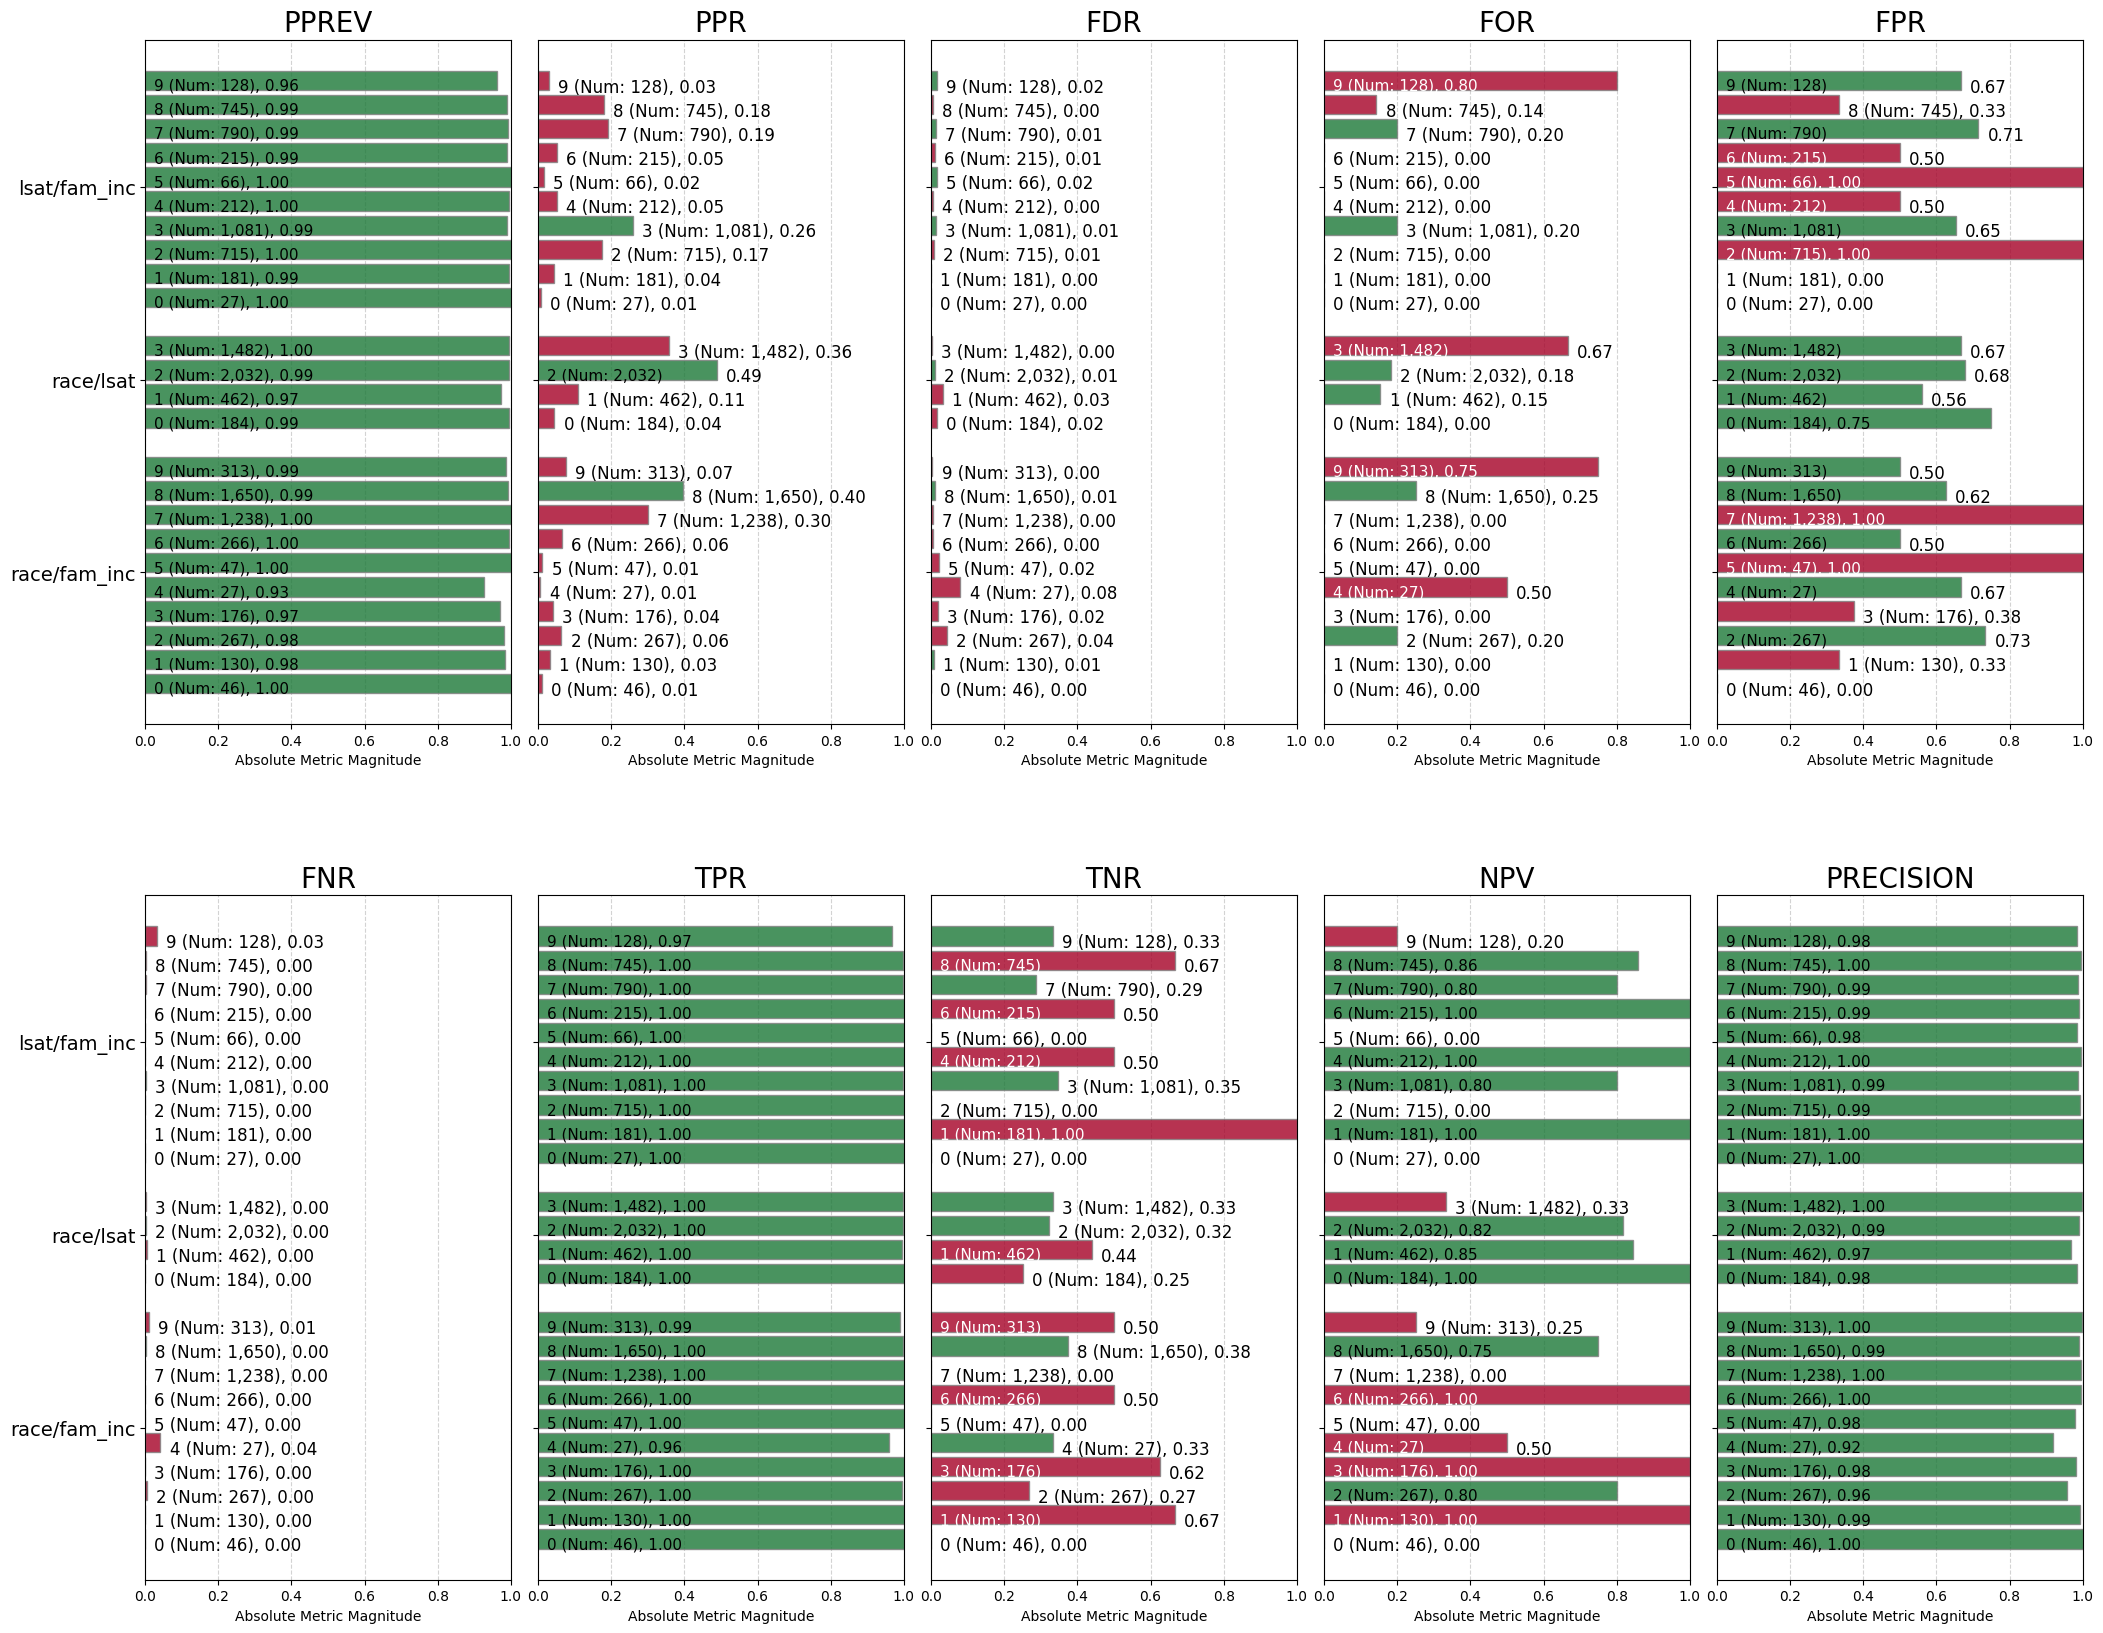

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False        True       False   
2       False        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1       False              True         False          False           False   
2       False              True         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

alt.VConcatChart(...)

1757

<Figure size 640x480 with 0 Axes>

In [24]:
'''
4. Label flipping
'''

#transform data
data_to_transform = prep_label_flipping(df_num_int, protected_attributes_int, target)

#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_to_transform,
                                                                             protected_attributes_int,target)

#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["RandomForest"], target,
                                              protected_attributes_int, list_of_disparities, priv, display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_lf, protected_attributes_int)
gc.collect()

In [33]:
'''
In-processing: Fair learn classifier 
'''
data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, "lsat/fam_inc", models[0], metrics_dict,target)
#calc metrics
df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, list_of_disparities, priv,display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_transformed_fl, protected_attributes_int)

[INFO] 2024-11-20 20:25:54 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-11-20 20:25:54 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-11-20 20:25:54 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.ensemble.RandomForestClassifier
Accuracy score training:
0.1097
Accuracy score test:
0.1123
Classification report for model: sklearn.ensemble.RandomForestClassifier : 
               precision    recall  f1-score   support

           0       0.11      1.00      0.20       467
           1       0.00      0.00      0.00      3693

    accuracy                           0.11      4160
   macro avg       0.06      0.50      0.10      4160
weighted avg       0.01      0.11      0.02      4160



attribute_name attribute_value  accuracy  tpr  tnr   for  fdr  fpr  fnr  \
0    race/fam_inc               0      0.30  0.0  1.0  0.70  NaN  0.0  1.0   
1    race/fam_inc               1      0.21  0.0  1.0  0.79  NaN  0.0  1.0   
2    race/fam_inc               2      0.31  0.0  1.0  0.69  NaN  0.0  1.0   
3    race/fam_inc               3      0.25  0.0  1.0  0.75  NaN  0.0  1.0   
4    race/fam_inc               4      0.19  0.0  1.0  0.81  NaN  0.0  1.0   
5    race/fam_inc               5      0.15  0.0  1.0  0.85  NaN  0.0  1.0   
6    race/fam_inc               6      0.07  0.0  1.0  0.93  NaN  0.0  1.0   
7    race/fam_inc               7      0.10  0.0  1.0  0.90  NaN  0.0  1.0   
8    race/fam_inc               8      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
9    race/fam_inc               9      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
10      race/lsat               0      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
11      race/lsat               1      0.34  0.0  1.0  0.66  NaN  0.0  1.0   
12      race/lsat               2      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
13      race/lsat               3      0.13  0.0  1.0  0.87  NaN  0.0  1.0   
14   lsat/fam_inc               0      0.11  0.0  1.0  0.89  NaN  0.0  1.0   
15   lsat/fam_inc               1      0.02  0.0  1.0  0.98  NaN  0.0  1.0   
16   lsat/fam_inc               2      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
17   lsat/fam_inc               3      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
18   lsat/fam_inc               4      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
19   lsat/fam_inc               5      0.27  0.0  1.0  0.73  NaN  0.0  1.0   
20   lsat/fam_inc               6      0.20  0.0  1.0  0.80  NaN  0.0  1.0   
21   lsat/fam_inc               7      0.21  0.0  1.0  0.79  NaN  0.0  1.0   
22   lsat/fam_inc               8      0.15  0.0  1.0  0.85  NaN  0.0  1.0   
23   lsat/fam_inc               9      0.14  0.0  1.0  0.86  NaN  0.0  1.0   

     npv  precision  ppr  pprev  prev  
0   0.30        NaN  NaN    0.0  0.70  
1   0.21        NaN  NaN    0.0  0.79  
2   0.31        NaN  NaN    0.0  0.69  
3   0.25        NaN  NaN    0.0  0.75  
4   0.19        NaN  NaN    0.0  0.81  
5   0.15        NaN  NaN    0.0  0.85  
6   0.07        NaN  NaN    0.0  0.93  
7   0.10        NaN  NaN    0.0  0.90  
8   0.08        NaN  NaN    0.0  0.92  
9   0.08        NaN  NaN    0.0  0.92  
10  0.08        NaN  NaN    0.0  0.92  
11  0.34        NaN  NaN    0.0  0.66  
12  0.05        NaN  NaN    0.0  0.95  
13  0.13        NaN  NaN    0.0  0.87  
14  0.11        NaN  NaN    0.0  0.89  
15  0.02        NaN  NaN    0.0  0.98  
16  0.05        NaN  NaN    0.0  0.95  
17  0.05        NaN  NaN    0.0  0.95  
18  0.05        NaN  NaN    0.0  0.95  
19  0.27        NaN  NaN    0.0  0.73  
20  0.20        NaN  NaN    0.0  0.80  
21  0.21        NaN  NaN    0.0  0.79  
22  0.15        NaN  NaN    0.0  0.85  
23  0.14        NaN  NaN    0.0  0.86

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3


AttributeError: 'bool' object has no attribute 'astype'

Accuracy score test:
0.8868


attribute_name attribute_value  accuracy  tpr  tnr  for   fdr  fpr  fnr  \
0    race/fam_inc             0.0      0.56  1.0  0.0  NaN  0.44  1.0  0.0   
1    race/fam_inc             1.0      0.71  1.0  0.0  NaN  0.29  1.0  0.0   
2    race/fam_inc             2.0      0.68  1.0  0.0  NaN  0.32  1.0  0.0   
3    race/fam_inc             3.0      0.80  1.0  0.0  NaN  0.20  1.0  0.0   
4    race/fam_inc             4.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
5    race/fam_inc             5.0      0.90  1.0  0.0  NaN  0.10  1.0  0.0   
6    race/fam_inc             6.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
7    race/fam_inc             7.0      0.91  1.0  0.0  NaN  0.09  1.0  0.0   
8    race/fam_inc             8.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
9    race/fam_inc             9.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
10      race/lsat             0.0      0.90  1.0  0.0  NaN  0.10  1.0  0.0   
11      race/lsat             1.0      0.64  1.0  0.0  NaN  0.36  1.0  0.0   
12      race/lsat             2.0      0.96  1.0  0.0  NaN  0.04  1.0  0.0   
13      race/lsat             3.0      0.88  1.0  0.0  NaN  0.12  1.0  0.0   
14   lsat/fam_inc             0.0      0.89  1.0  0.0  NaN  0.11  1.0  0.0   
15   lsat/fam_inc             1.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
16   lsat/fam_inc             2.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
17   lsat/fam_inc             3.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
18   lsat/fam_inc             4.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
19   lsat/fam_inc             5.0      0.59  1.0  0.0  NaN  0.41  1.0  0.0   
20   lsat/fam_inc             6.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
21   lsat/fam_inc             7.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
22   lsat/fam_inc             8.0      0.87  1.0  0.0  NaN  0.13  1.0  0.0   
23   lsat/fam_inc             9.0      0.84  1.0  0.0  NaN  0.16  1.0  0.0   

    npv  precision   ppr  pprev  prev  
0   NaN       0.56  0.01    1.0  0.56  
1   NaN       0.71  0.03    1.0  0.71  
2   NaN       0.68  0.07    1.0  0.68  
3   NaN       0.80  0.05    1.0  0.80  
4   NaN       0.78  0.01    1.0  0.78  
5   NaN       0.90  0.01    1.0  0.90  
6   NaN       0.93  0.07    1.0  0.93  
7   NaN       0.91  0.30    1.0  0.91  
8   NaN       0.93  0.38    1.0  0.93  
9   NaN       0.93  0.08    1.0  0.93  
10  NaN       0.90  0.05    1.0  0.90  
11  NaN       0.64  0.12    1.0  0.64  
12  NaN       0.96  0.48    1.0  0.96  
13  NaN       0.88  0.35    1.0  0.88  
14  NaN       0.89  0.01    1.0  0.89  
15  NaN       0.95  0.05    1.0  0.95  
16  NaN       0.95  0.18    1.0  0.95  
17  NaN       0.95  0.25    1.0  0.95  
18  NaN       0.95  0.05    1.0  0.95  
19  NaN       0.59  0.01    1.0  0.59  
20  NaN       0.78  0.05    1.0  0.78  
21  NaN       0.78  0.20    1.0  0.78  
22  NaN       0.87  0.18    1.0  0.87  
23  NaN       0.84  0.03    1.0  0.84

Majority class for:  race/fam_inc  is: 8.0
Majority class for:  race/lsat  is: 2.0
Majority class for:  lsat/fam_inc  is: 3.0
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc             0.0           6.27            NaN   
1    race/fam_inc             1.0           4.13            NaN   
2    race/fam_inc             2.0           4.63            NaN   
3    race/fam_inc             3.0           2.90            NaN   
4    race/fam_inc             4.0           3.09            NaN   
5    race/fam_inc             5.0           1.43            NaN   
6    race/fam_inc             6.0           0.97            NaN   
7    race/fam_inc             7.0           1.32            NaN   
8    race/fam_inc             8.0           1.00            NaN   
9    race/fam_inc             9.0           1.05            NaN   
10      race/lsat             0.0           2.20            NaN   
11      race/lsat             1.0           8.22            NaN   
12      race/lsat             2.0           1.00            NaN   
13      race/lsat             3.0           2.81            NaN   
14   lsat/fam_inc             0.0           2.16            NaN   
15   lsat/fam_inc             1.0           0.92            NaN   
16   lsat/fam_inc             2.0           0.88            NaN   
17   lsat/fam_inc             3.0           1.00            NaN   
18   lsat/fam_inc             4.0           0.96            NaN   
19   lsat/fam_inc             5.0           7.97            NaN   
20   lsat/fam_inc             6.0           4.20            NaN   
21   lsat/fam_inc             7.0           4.20            NaN   
22   lsat/fam_inc             8.0           2.58            NaN   
23   lsat/fam_inc             9.0           3.09            NaN   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0             NaN            1.0            NaN           0.03   
1             NaN            1.0            NaN           0.08   
2             NaN            1.0            NaN           0.19   
3             NaN            1.0            NaN           0.13   
4             NaN            1.0            NaN           0.02   
5             NaN            1.0            NaN           0.02   
6             NaN            1.0            NaN           0.18   
7             NaN            1.0            NaN           0.80   
8             NaN            1.0            NaN           1.00   
9             NaN            1.0            NaN           0.20   
10            NaN            1.0            NaN           0.11   
11            NaN            1.0            NaN           0.25   
12            NaN            1.0            NaN           1.00   
13            NaN            1.0            NaN           0.74   
14            NaN            1.0            NaN           0.03   
15            NaN            1.0            NaN           0.18   
16            NaN            1.0            NaN           0.71   
17            NaN            1.0            NaN           1.00   
18            NaN            1.0            NaN           0.22   
19            NaN            1.0            NaN           0.04   
20            NaN            1.0            NaN           0.21   
21            NaN            1.0            NaN           0.80   
22            NaN            1.0            NaN           0.72   
23            NaN            1.0            NaN           0.12   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0               1.0                 0.60            NaN            1.0  
1               1.0                 0.76            NaN            1.0  
2               1.0                 0.73            NaN            1.0  
3               1.0                 0.86            NaN            1.0  
4               1.0                 0.84            NaN            1.0  
5               1.0                 0.97            NaN            1.0  
6               1.0                 1.00            NaN            1.0  
7               1.0                 0.98            NaN            1.0  
8               1.0

              fnr_disparity  fpr_disparity
race/fam_inc            NaN            1.0
race/lsat               NaN            1.0
lsat/fam_inc            NaN            1.0
Overall average for fnr_disparity:  nan
Overall average for fpr_disparity:  1.000


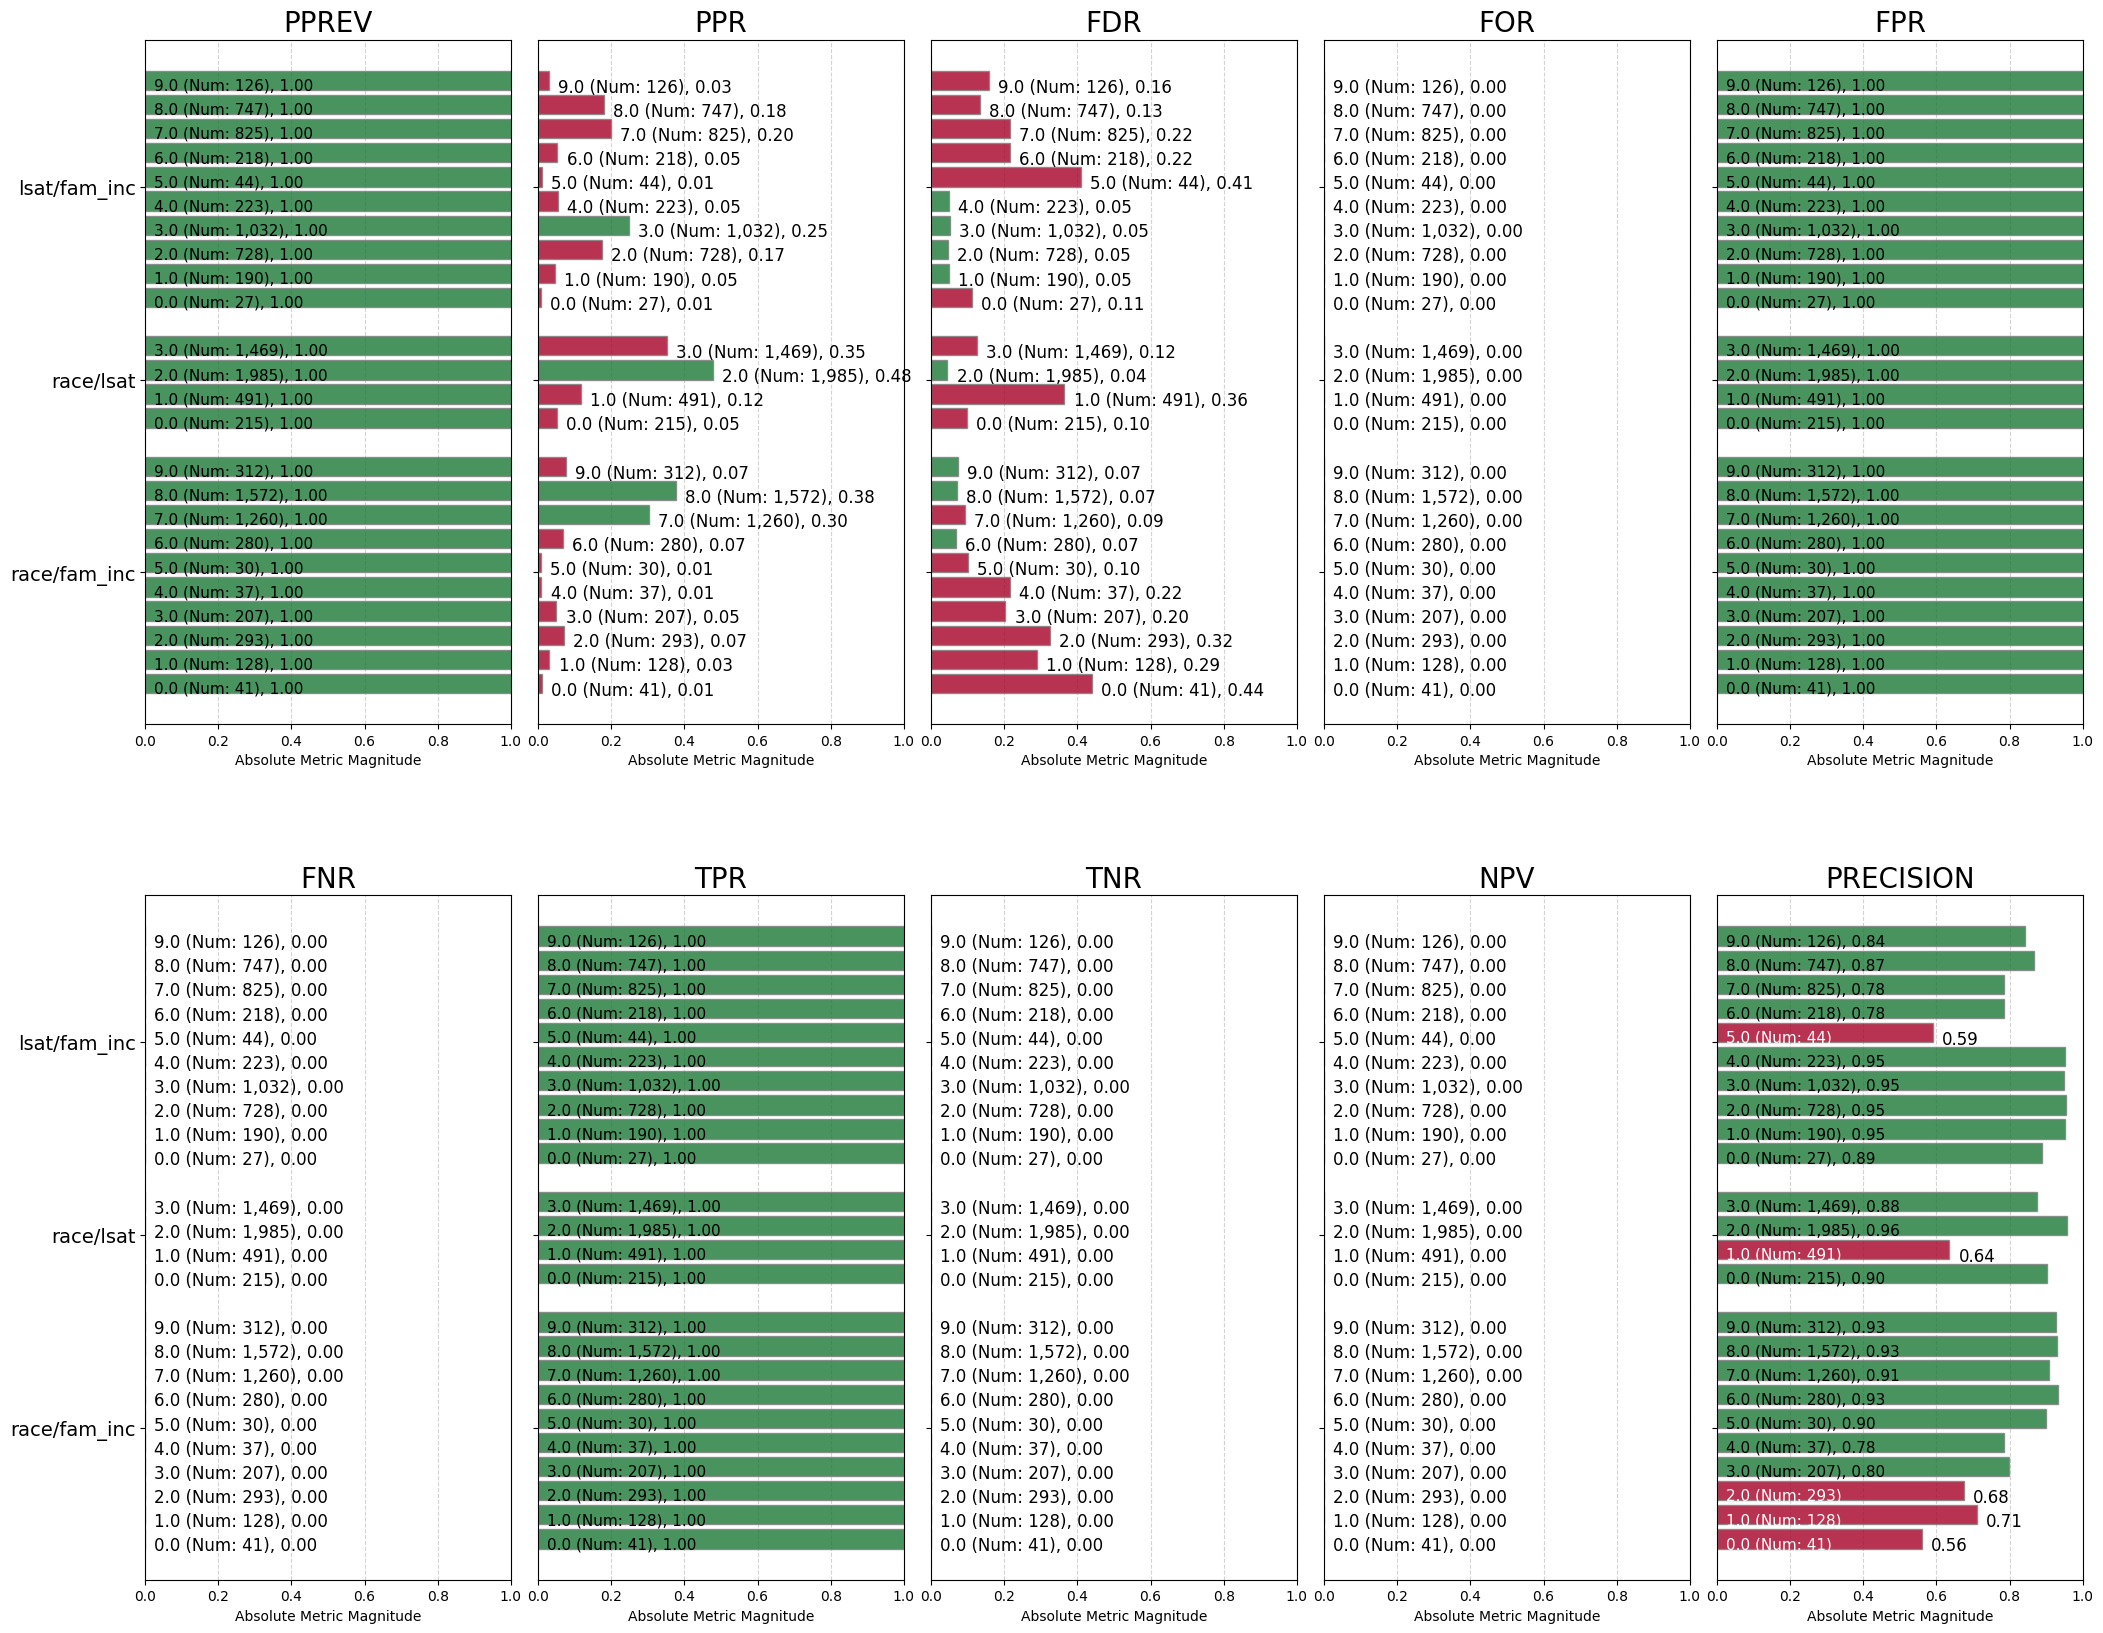

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True         NaN         NaN        True         NaN   
1       False        True         NaN         NaN        True         NaN   
2       False        True         NaN         NaN        True         NaN   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0         NaN             False         False            NaN            True   
1         NaN             False         False            NaN            True   
2         NaN             False         False            NaN            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

<Figure size 640x480 with 0 Axes>

In [11]:
"""Gerry fair"""""

maj_1 = get_majority_classes(df_num_int["race/fam_inc"])[0]
maj_2 = get_majority_classes(df_num_int["race/lsat"])[0]
maj_3 = get_majority_classes(df_num_int["lsat/fam_inc"])[0]
maj_classes = [[maj_1],[maj_2],[maj_3]]

x_test_gf,y_test_gf,y_test_pred_gf = in_process_gerryfair(df_num_int,target, protected_attributes_int, maj_classes, len(df_num_int)-len(x_test_int))
df_test_transformed_gf =calc_fairness_report(x_test_gf, y_test_gf, y_test_pred_gf,target,protected_attributes_int, list_of_disparities, priv,display_disp=True)

---------- Model name:  LogisticRegression ----------

Accuracy score test corrected:
0.7156


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.50  0.53  0.43  0.71  0.32  0.57   
1    race/fam_inc               1      0.67  0.70  0.56  0.67  0.14  0.44   
2    race/fam_inc               2      0.71  0.70  0.74  0.48  0.14  0.26   
3    race/fam_inc               3      0.71  0.74  0.61  0.56  0.15  0.39   
4    race/fam_inc               4      0.74  0.68  1.00  0.58  0.00  0.00   
5    race/fam_inc               5      0.72  0.75  0.57  0.71  0.09  0.43   
6    race/fam_inc               6      0.77  0.77  0.78  0.81  0.02  0.22   
7    race/fam_inc               7      0.73  0.72  0.78  0.77  0.03  0.22   
8    race/fam_inc               8      0.71  0.71  0.74  0.82  0.03  0.26   
9    race/fam_inc               9      0.69  0.70  0.62  0.85  0.04  0.38   
10      race/lsat               0      0.74  0.75  0.60  0.82  0.05  0.40   
11      race/lsat               1      0.67  0.67  0.67  0.49  0.20  0.33   
12      race/lsat               2      0.72  0.72  0.79  0.88  0.01  0.21   
13      race/lsat               3      0.72  0.72  0.73  0.72  0.06  0.27   
14   lsat/fam_inc               0      0.63  0.62  0.67  0.82  0.06  0.33   
15   lsat/fam_inc               1      0.76  0.76  1.00  0.93  0.00  0.00   
16   lsat/fam_inc               2      0.72  0.72  0.82  0.86  0.01  0.18   
17   lsat/fam_inc               3      0.72  0.72  0.72  0.87  0.02  0.28   
18   lsat/fam_inc               4      0.71  0.71  0.73  0.88  0.02  0.27   
19   lsat/fam_inc               5      0.61  0.67  0.44  0.67  0.24  0.56   
20   lsat/fam_inc               6      0.71  0.73  0.62  0.64  0.11  0.38   
21   lsat/fam_inc               7      0.73  0.72  0.75  0.59  0.08  0.25   
22   lsat/fam_inc               8      0.70  0.70  0.70  0.70  0.07  0.30   
23   lsat/fam_inc               9      0.67  0.67  0.67  0.75  0.08  0.33   

     fnr   npv  precision   ppr  pprev  prev  
0   0.47  0.29       0.68  0.01   0.54  0.70  
1   0.30  0.33       0.86  0.03   0.65  0.79  
2   0.30  0.52       0.86  0.05   0.56  0.69  
3   0.26  0.44       0.85  0.04   0.65  0.75  
4   0.32  0.42       1.00  0.01   0.56  0.81  
5   0.25  0.29       0.91  0.01   0.70  0.85  
6   0.23  0.19       0.98  0.07   0.73  0.93  
7   0.28  0.23       0.97  0.30   0.67  0.90  
8   0.29  0.18       0.97  0.40   0.68  0.92  
9   0.30  0.15       0.96  0.08   0.67  0.92  
10  0.25  0.18       0.95  0.05   0.72  0.92  
11  0.33  0.51       0.80  0.09   0.55  0.66  
12  0.28  0.12       0.99  0.51   0.69  0.95  
13  0.28  0.28       0.94  0.35   0.66  0.87  
14  0.38  0.18       0.94  0.01   0.59  0.89  
15  0.24  0.07       1.00  0.05   0.75  0.98  
16  0.28  0.14       0.99  0.18   0.69  0.95  
17  0.28  0.13       0.98  0.27   0.70  0.95  
18  0.29  0.12       0.98  0.05   0.69  0.95  
19  0.33  0.33       0.76  0.02   0.64  0.73  
20  0.27  0.36       0.89  0.05   0.67  0.80  
21  0.28  0.41       0.92  0.18   0.63  0.79  
22  0.30  0.30       0.93  0.17   0.64  0.85  
23  0.33  0.25       0.92  0.03   0.62  0.86

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0          10.80           1.62   
1    race/fam_inc               1           4.82           1.04   
2    race/fam_inc               2           4.73           1.04   
3    race/fam_inc               3           4.99           0.89   
4    race/fam_inc               4           0.00           1.10   
5    race/fam_inc               5           3.07           0.86   
6    race/fam_inc               6           0.70           0.81   
7    race/fam_inc               7           1.05           0.95   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.44           1.04   
10      race/lsat               0           3.03           0.88   
11      race/lsat               1          13.63           1.17   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           3.70           1.00   
14   lsat/fam_inc               0           2.95           1.34   
15   lsat/fam_inc               1           0.00           0.86   
16   lsat/fam_inc               2           0.67           1.02   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           0.97           1.03   
19   lsat/fam_inc               5          11.22           1.19   
20   lsat/fam_inc               6           5.27           0.95   
21   lsat/fam_inc               7           3.82           0.99   
22   lsat/fam_inc               8           3.37           1.08   
23   lsat/fam_inc               9           3.53           1.17   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.87           2.20           1.63           0.02   
1            0.82           1.71           1.86           0.08   
2            0.58           0.99           2.97           0.13   
3            0.68           1.49           2.52           0.10   
4            0.71           0.00           2.38           0.01   
5            0.87           1.65           1.63           0.03   
6            0.98           0.86           1.11           0.17   
7            0.93           0.84           1.32           0.75   
8            1.00           1.00           1.00           1.00   
9            1.03           1.44           0.84           0.19   
10           0.94           1.87           1.43           0.09   
11           0.56           1.55           4.12           0.18   
12           1.00           1.00           1.00           1.00   
13           0.82           1.28           2.30           0.69   
14           0.94           1.19           1.45           0.02   
15           1.07           0.00           0.52           0.18   
16           0.98           0.64           1.14           0.65   
17           1.00           1.00           1.00           1.00   
18           1.00           0.97           0.97           0.19   
19           0.76           1.98           2.66           0.06   
20           0.73           1.36           2.88           0.19   
21           0.67           0.88           3.29           0.66   
22           0.80           1.06           2.36           0.63   
23           0.86           1.19           1.99           0.11   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.80                 0.70           0.58           0.75  
1              0.96                 0.88           0.75           0.98  
2              0.83                 0.89           1.01           0.98  
3              0.97                 0.88           0.83           1.05  
4              0.82                 1.03           1.35           0.96  
5              1.04                 0.94           0.77           1.06  
6              1.08                 1.01           1.05           1.08  
7              1.00                 1.00           1.06           1.02  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc       1.038889       1.242222
race/lsat          1.016667       1.566667
lsat/fam_inc       1.070000       1.030000
Overall average for fnr_disparity:  1.042
Overall average for fpr_disparity:  1.280


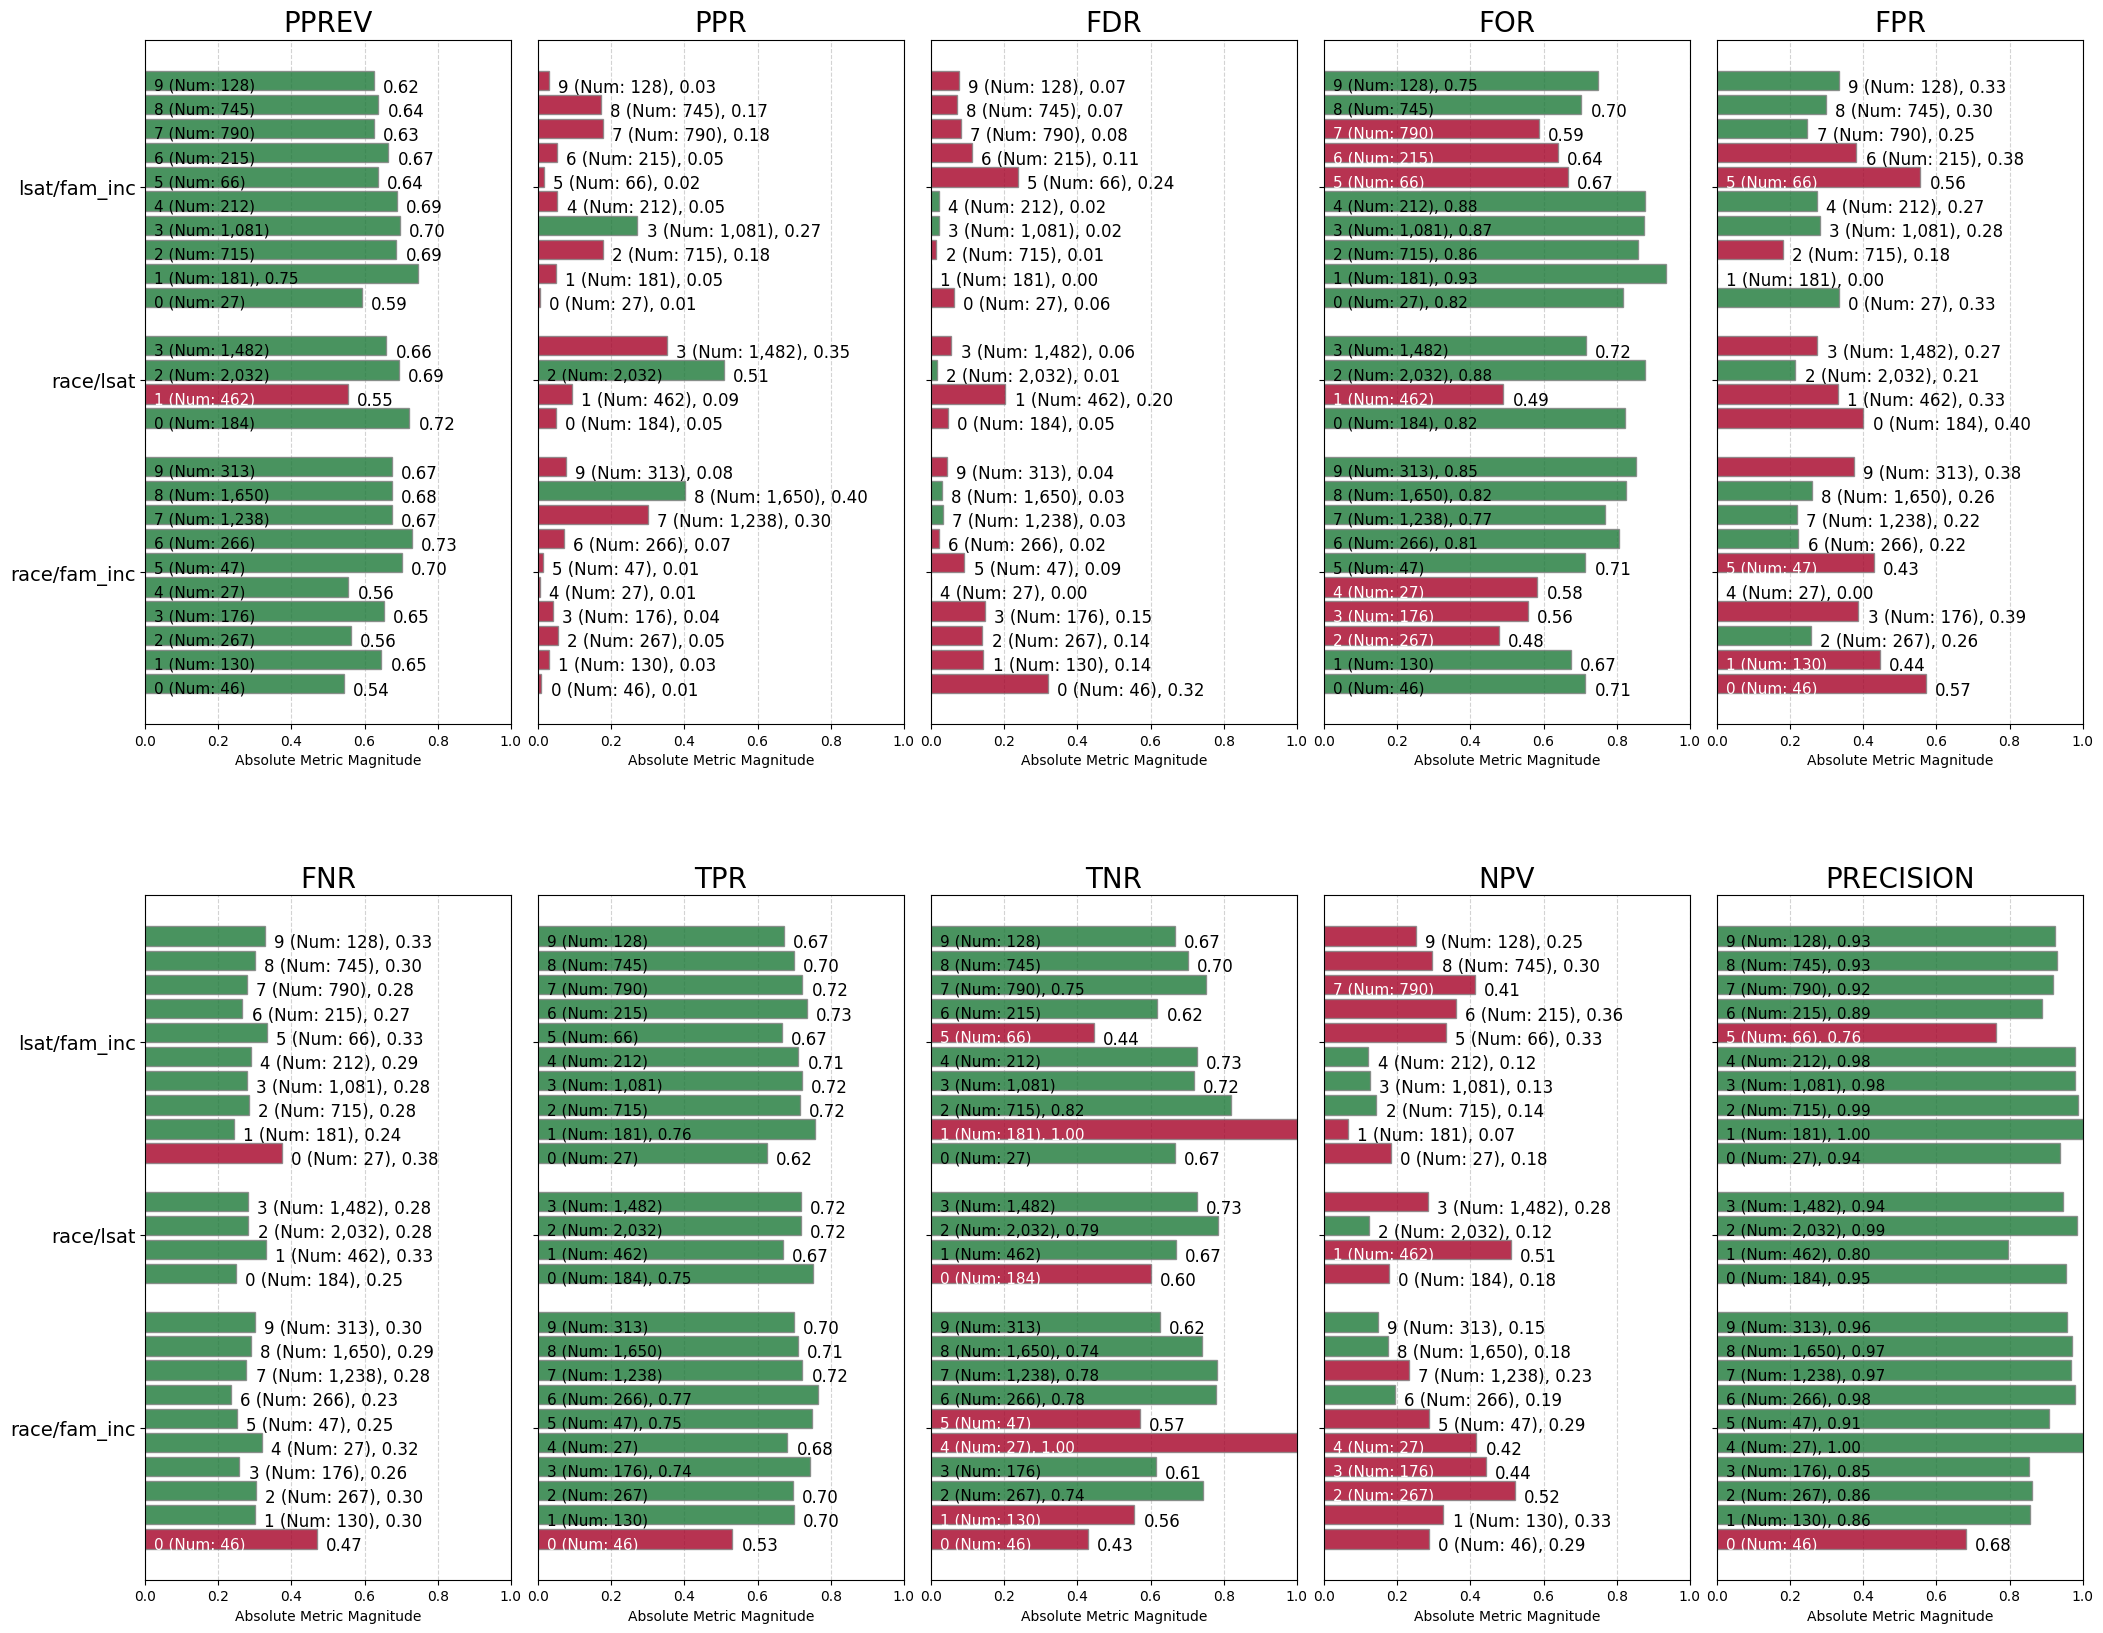

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False          False   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   
1       False       False       False       False       False       False   
2       False       False       False        True        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   
1       False             False         False          False           False   
2       False              True         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

112824

<Figure size 640x480 with 0 Axes>

In [27]:
df_test_fairlearn = post_process_group_threshold_fairlearn(df_num_int, protected_attributes_int, target,list_of_disparities, priv)
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_fairlearn, protected_attributes_int)
gc.collect()

---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:29 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.8531


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0      race/lsat               0      0.89  0.95  0.13  0.80  0.07  0.87   
1      race/lsat               1      0.68  0.93  0.18  0.41  0.31  0.82   
2      race/lsat               2      0.95  0.99  0.20  0.56  0.04  0.80   
3      race/lsat               3      0.88  0.97  0.26  0.42  0.10  0.74   

    fnr   npv  precision   ppr  pprev  prev  
0  0.05  0.20       0.93  0.04   0.95  0.92  
1  0.07  0.59       0.69  0.10   0.89  0.66  
2  0.01  0.44       0.96  0.50   0.98  0.95  
3  0.03  0.58       0.90  0.35   0.94  0.87

Majority class for:  race/lsat  is: 2
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0      race/lsat               0           1.90           3.66           1.44   
1      race/lsat               1           7.90           5.07           0.73   
2      race/lsat               2           1.00           1.00           1.00   
3      race/lsat               3           2.67           2.23           0.76   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.09           0.45           0.09             0.97   
1           1.02           1.33           0.21             0.91   
2           1.00           1.00           1.00             1.00   
3           0.93           1.30           0.70             0.96   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.96           0.65           0.97  
1                 0.72           0.91           0.95  
2                 1.00           1.00           1.00  
3                 0.93           1.27           0.98

              fnr_disparity  fpr_disparity
race/fam_inc            NaN            NaN
race/lsat          3.653333       1.013333
lsat/fam_inc            NaN            NaN
Overall average for fnr_disparity:  3.653
Overall average for fpr_disparity:  1.013


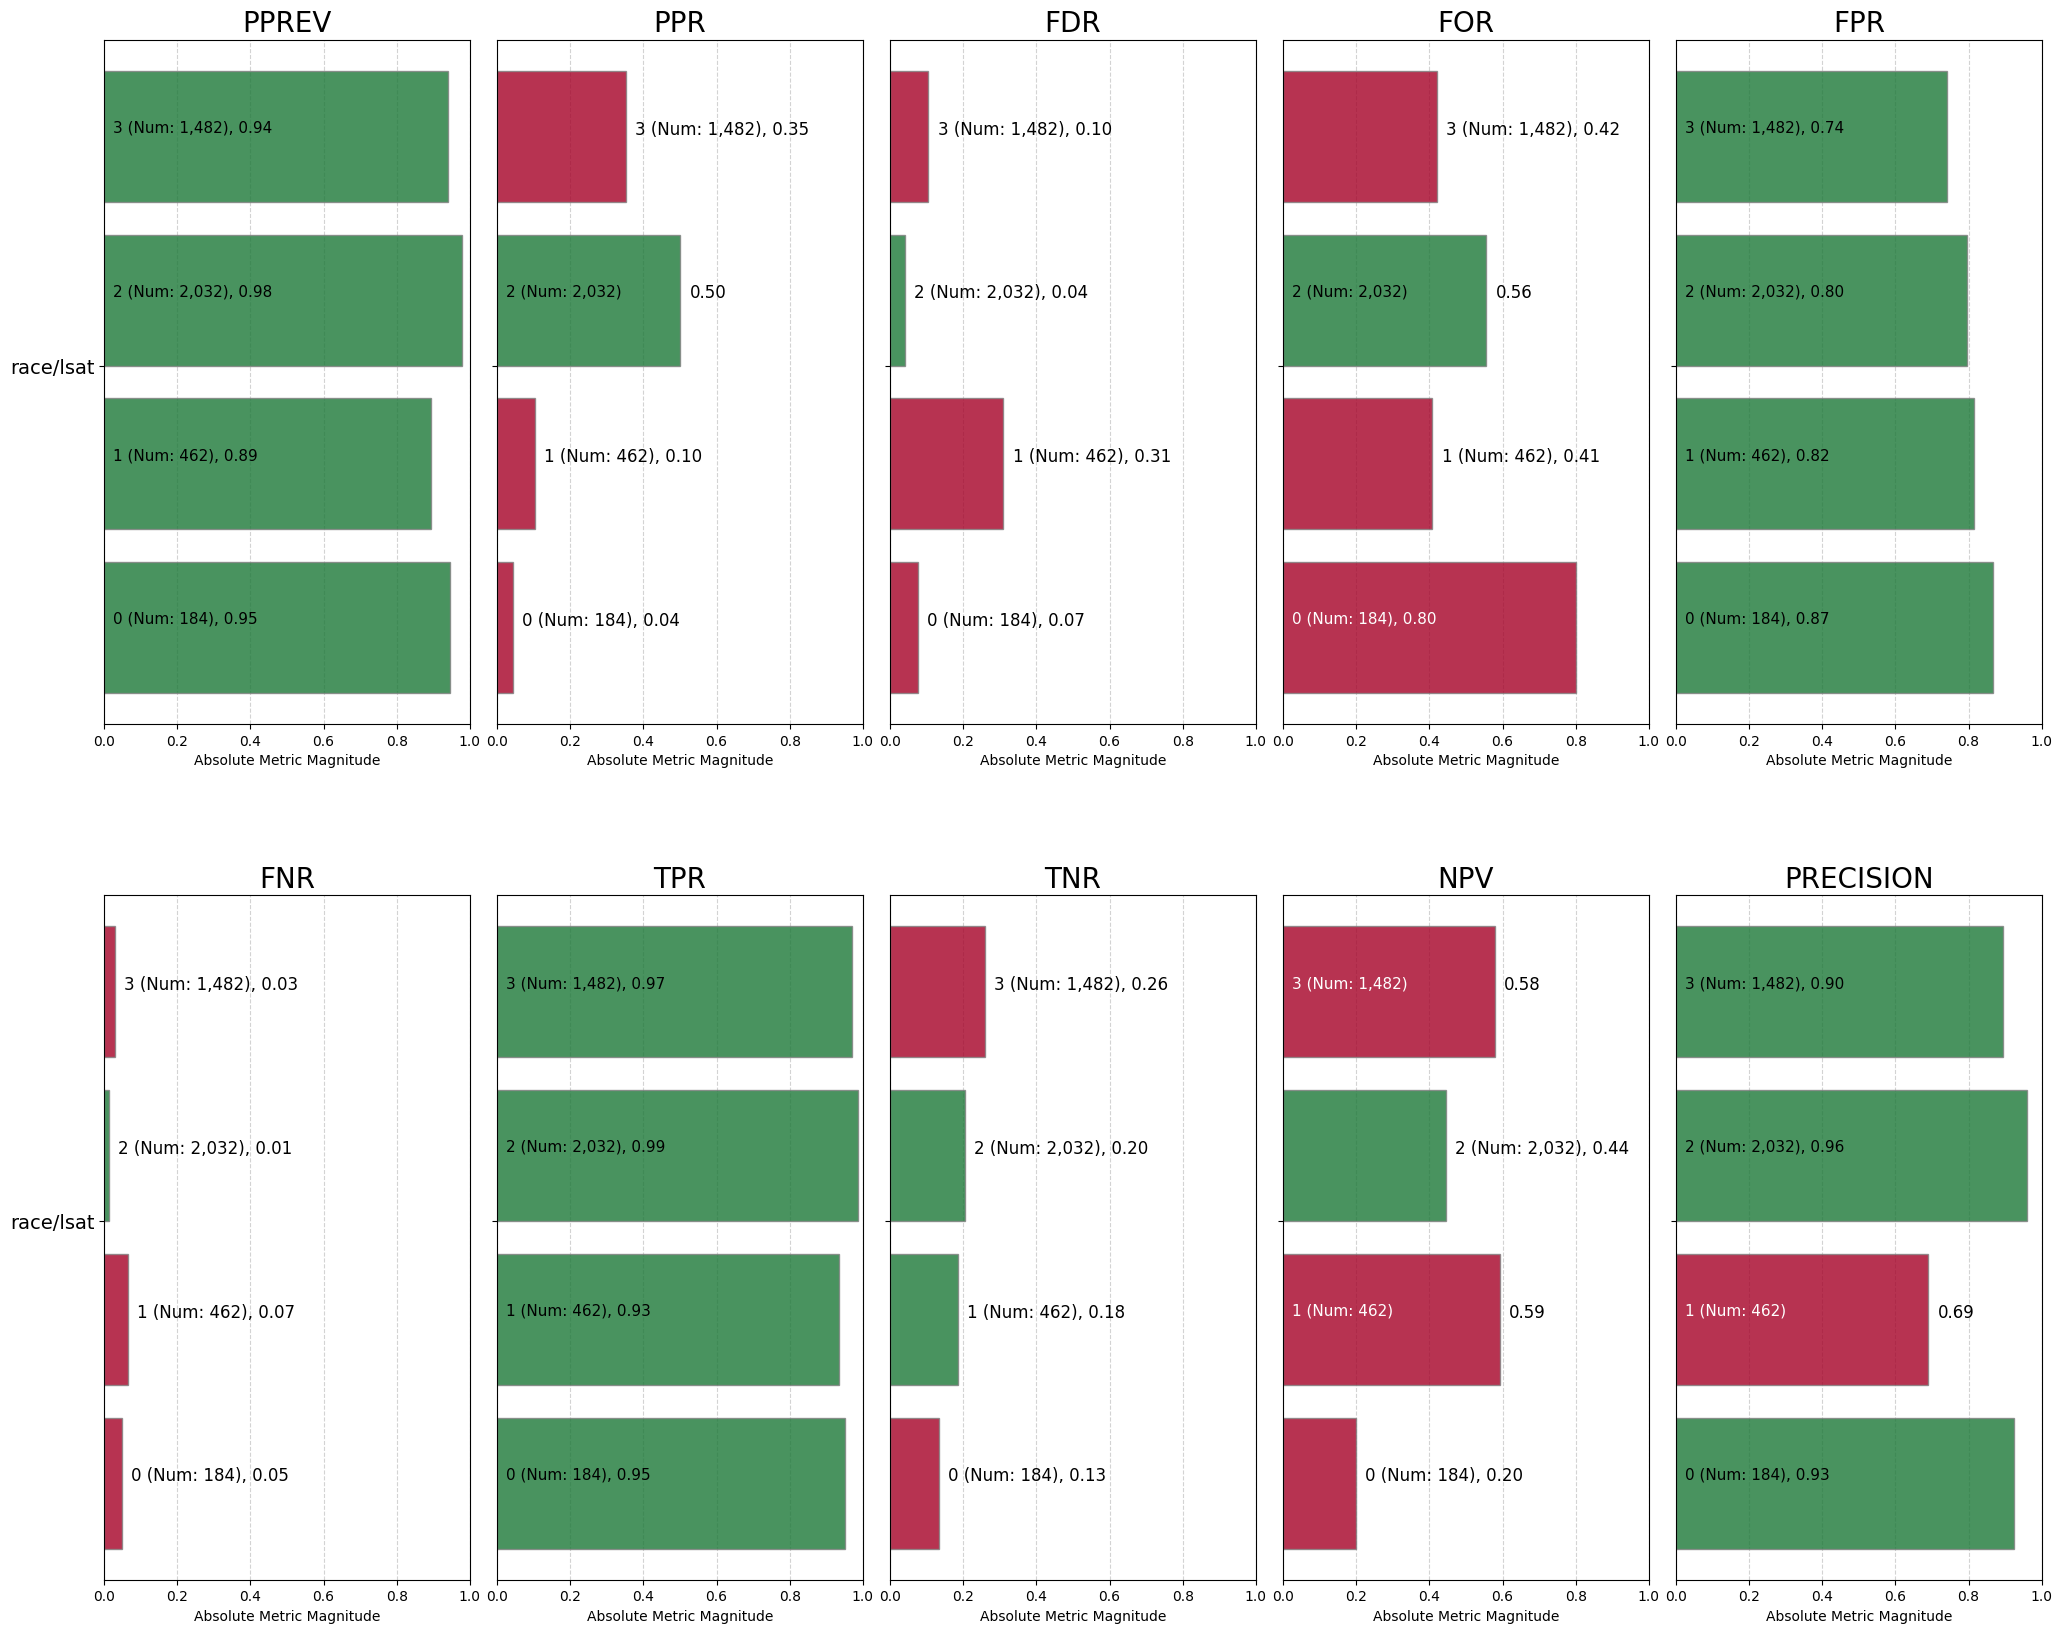

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 20:39:30 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:31 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.8543


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0   race/fam_inc               0      0.67  0.91  0.14  0.60  0.29  0.86   
1   race/fam_inc               1      0.78  0.96  0.07  0.67  0.20  0.93   
2   race/fam_inc               2      0.72  0.92  0.24  0.41  0.27  0.76   
3   race/fam_inc               3      0.80  1.00  0.20  0.00  0.21  0.80   
4   race/fam_inc               4      0.85  1.00  0.20  0.00  0.15  0.80   
5   race/fam_inc               5      0.87  0.98  0.29  0.33  0.11  0.71   
6   race/fam_inc               6      0.94  0.97  0.50  0.47  0.04  0.50   
7   race/fam_inc               7      0.91  0.98  0.31  0.41  0.07  0.69   
8   race/fam_inc               8      0.92  0.99  0.14  0.50  0.07  0.86   
9   race/fam_inc               9      0.91  0.98  0.04  0.86  0.08  0.96   

    fnr   npv  precision   ppr  pprev  prev  
0  0.09  0.40       0.71  0.01   0.89  0.70  
1  0.04  0.33       0.80  0.03   0.95  0.79  
2  0.08  0.59       0.73  0.06   0.87  0.69  
3  0.00  1.00       0.79  0.04   0.95  0.75  
4  0.00  1.00       0.85  0.01   0.96  0.81  
5  0.02  0.67       0.89  0.01   0.94  0.85  
6  0.03  0.53       0.96  0.06   0.94  0.93  
7  0.02  0.59       0.93  0.30   0.95  0.90  
8  0.01  0.50       0.93  0.41   0.98  0.92  
9  0.02  0.14       0.92  0.08   0.98  0.92

Majority class for:  race/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0   race/fam_inc               0           4.33           7.93           1.20   
1   race/fam_inc               1           2.99           3.29           1.33   
2   race/fam_inc               2           3.94           6.40           0.82   
3   race/fam_inc               3           3.10           0.00           0.00   
4   race/fam_inc               4           2.28           0.00           0.00   
5   race/fam_inc               5           1.68           2.12           0.67   
6   race/fam_inc               6           0.54           2.73           0.94   
7   race/fam_inc               7           1.03           1.97           0.83   
8   race/fam_inc               8           1.00           1.00           1.00   
9   race/fam_inc               9           1.11           1.76           1.71   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.00           0.80           0.03             0.91   
1           1.08           0.67           0.08             0.98   
2           0.88           1.18           0.14             0.89   
3           0.93           2.00           0.10             0.97   
4           0.93           2.00           0.02             0.98   
5           0.83           1.33           0.03             0.96   
6           0.58           1.06           0.15             0.96   
7           0.80           1.17           0.73             0.97   
8           1.00           1.00           1.00             1.00   
9           1.12           0.29           0.19             1.00   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.76           1.01           0.92  
1                 0.86           0.52           0.97  
2                 0.79           1.72           0.94  
3                 0.85           1.44           1.01  
4                 0.91           1.41           1.01  
5                 0.95           2.02           0.99  
6                 1.03           3.53           0.98  
7                 1.00           2.19           0.99  
8                 1.00           1.00           1.00  
9                 0.99           0.29           0.99

              fnr_disparity  fpr_disparity
race/fam_inc       2.911111       0.905556
race/lsat               NaN            NaN
lsat/fam_inc            NaN            NaN
Overall average for fnr_disparity:  2.911
Overall average for fpr_disparity:  0.906


<Figure size 640x480 with 0 Axes>

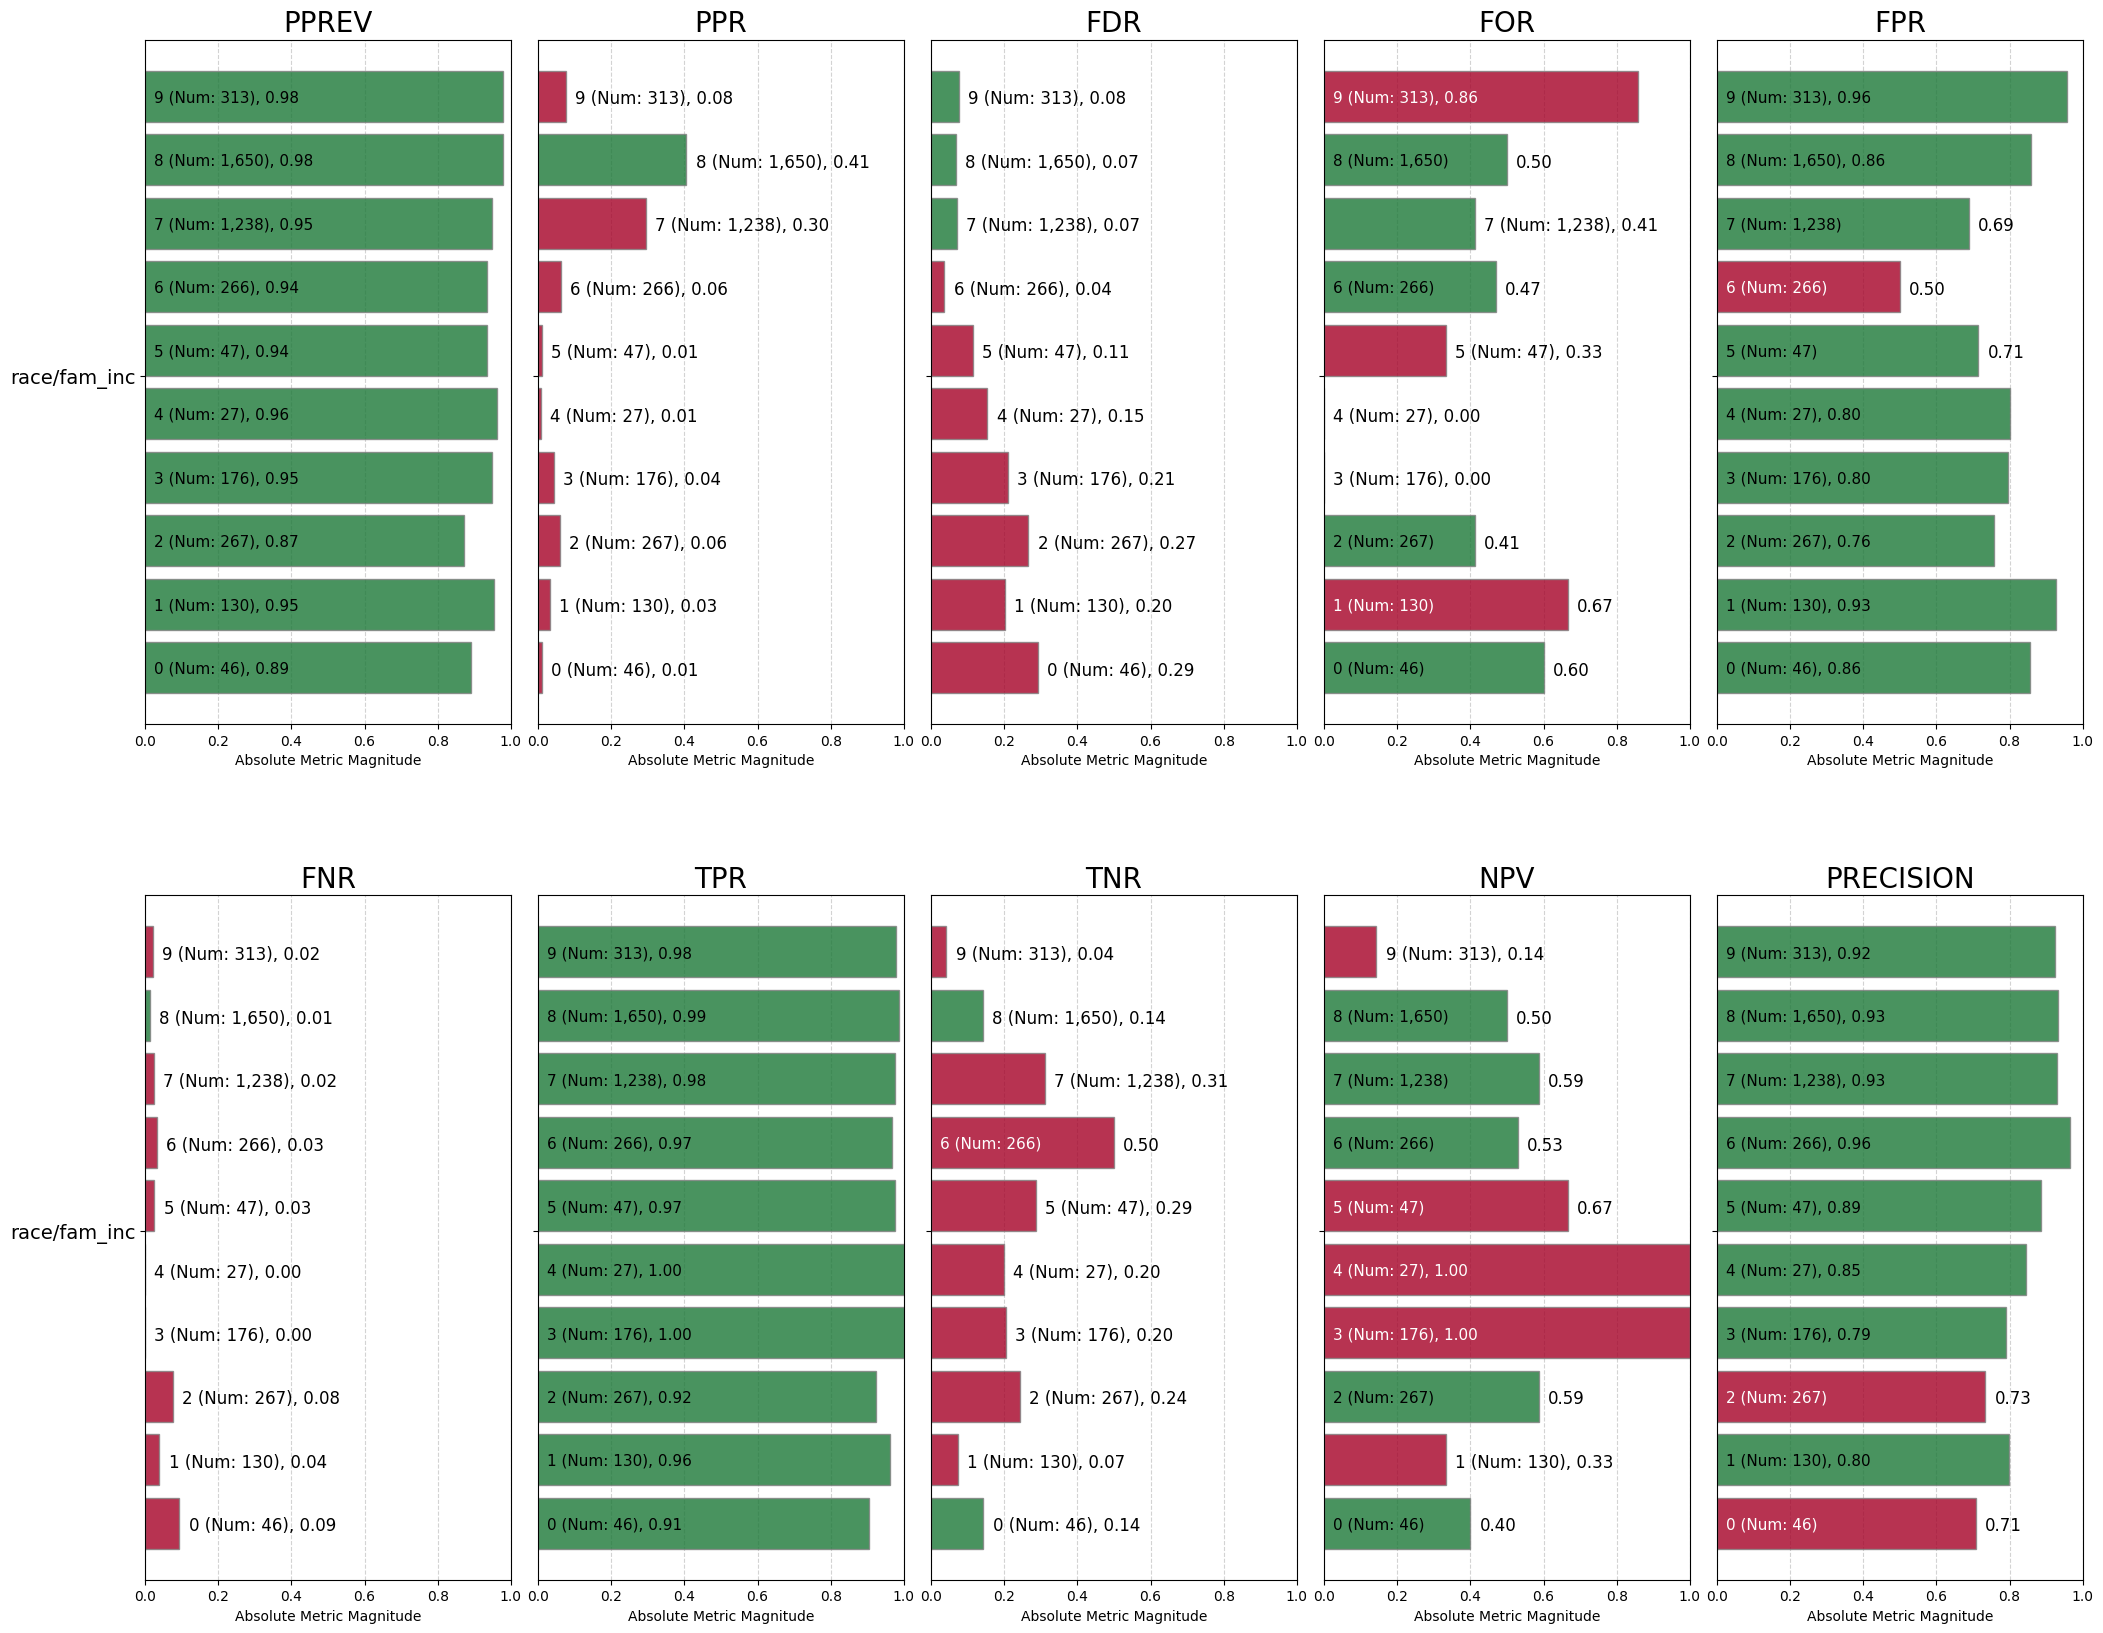

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   race/fam_inc               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 20:39:32 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.8562


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0   lsat/fam_inc               0      0.85  0.96  0.00  1.00  0.12  1.00   
1   lsat/fam_inc               1      0.95  0.96  0.33  0.88  0.01  0.67   
2   lsat/fam_inc               2      0.94  0.98  0.18  0.65  0.05  0.82   
3   lsat/fam_inc               3      0.94  0.99  0.16  0.61  0.05  0.84   
4   lsat/fam_inc               4      0.95  0.99  0.18  0.50  0.04  0.82   
5   lsat/fam_inc               5      0.71  0.94  0.11  0.60  0.26  0.89   
6   lsat/fam_inc               6      0.81  0.98  0.12  0.44  0.18  0.88   
7   lsat/fam_inc               7      0.81  0.96  0.22  0.42  0.17  0.78   
8   lsat/fam_inc               8      0.86  0.99  0.18  0.28  0.13  0.82   
9   lsat/fam_inc               9      0.83  0.93  0.22  0.67  0.12  0.78   

    fnr   npv  precision   ppr  pprev  prev  
0  0.04  0.00       0.88  0.01   0.96  0.89  
1  0.04  0.12       0.99  0.04   0.96  0.98  
2  0.02  0.35       0.95  0.17   0.97  0.95  
3  0.01  0.39       0.95  0.27   0.98  0.95  
4  0.01  0.50       0.96  0.05   0.98  0.95  
5  0.06  0.40       0.74  0.02   0.92  0.73  
6  0.02  0.56       0.82  0.05   0.96  0.80  
7  0.04  0.58       0.83  0.18   0.92  0.79  
8  0.01  0.72       0.87  0.18   0.96  0.85  
9  0.07  0.33       0.88  0.03   0.91  0.86

Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0   lsat/fam_inc               0           2.54           3.05           1.64   
1   lsat/fam_inc               1           0.25           2.88           1.44   
2   lsat/fam_inc               2           1.01           1.41           1.07   
3   lsat/fam_inc               3           1.00           1.00           1.00   
4   lsat/fam_inc               4           0.95           0.73           0.82   
5   lsat/fam_inc               5           5.78           4.57           0.99   
6   lsat/fam_inc               6           3.96           1.69           0.73   
7   lsat/fam_inc               7           3.81           3.03           0.69   
8   lsat/fam_inc               8           2.86           0.93           0.45   
9   lsat/fam_inc               9           2.66           5.32           1.10   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.19           0.00           0.02             0.98   
1           0.79           0.32           0.16             0.98   
2           0.97           0.89           0.66             0.99   
3           1.00           1.00           1.00             1.00   
4           0.97           1.28           0.20             1.00   
5           1.06           1.02           0.06             0.94   
6           1.05           1.42           0.19             0.98   
7           0.92           1.48           0.69             0.94   
8           0.97           1.85           0.68             0.98   
9           0.92           0.85           0.11             0.93   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.93           0.00           0.97  
1                 1.04           2.11           0.97  
2                 1.00           1.14           0.99  
3                 1.00           1.00           1.00  
4                 1.00           1.15           1.00  
5                 0.77           0.70           0.95  
6                 0.86           0.75           0.99  
7                 0.87           1.41           0.97  
8                 0.91           1.17           1.00  
9                 0.92           1.41           0.94

              fnr_disparity  fpr_disparity
race/fam_inc            NaN            NaN
race/lsat               NaN            NaN
lsat/fam_inc       2.623333       0.982222
Overall average for fnr_disparity:  2.623
Overall average for fpr_disparity:  0.982


<Figure size 640x480 with 0 Axes>

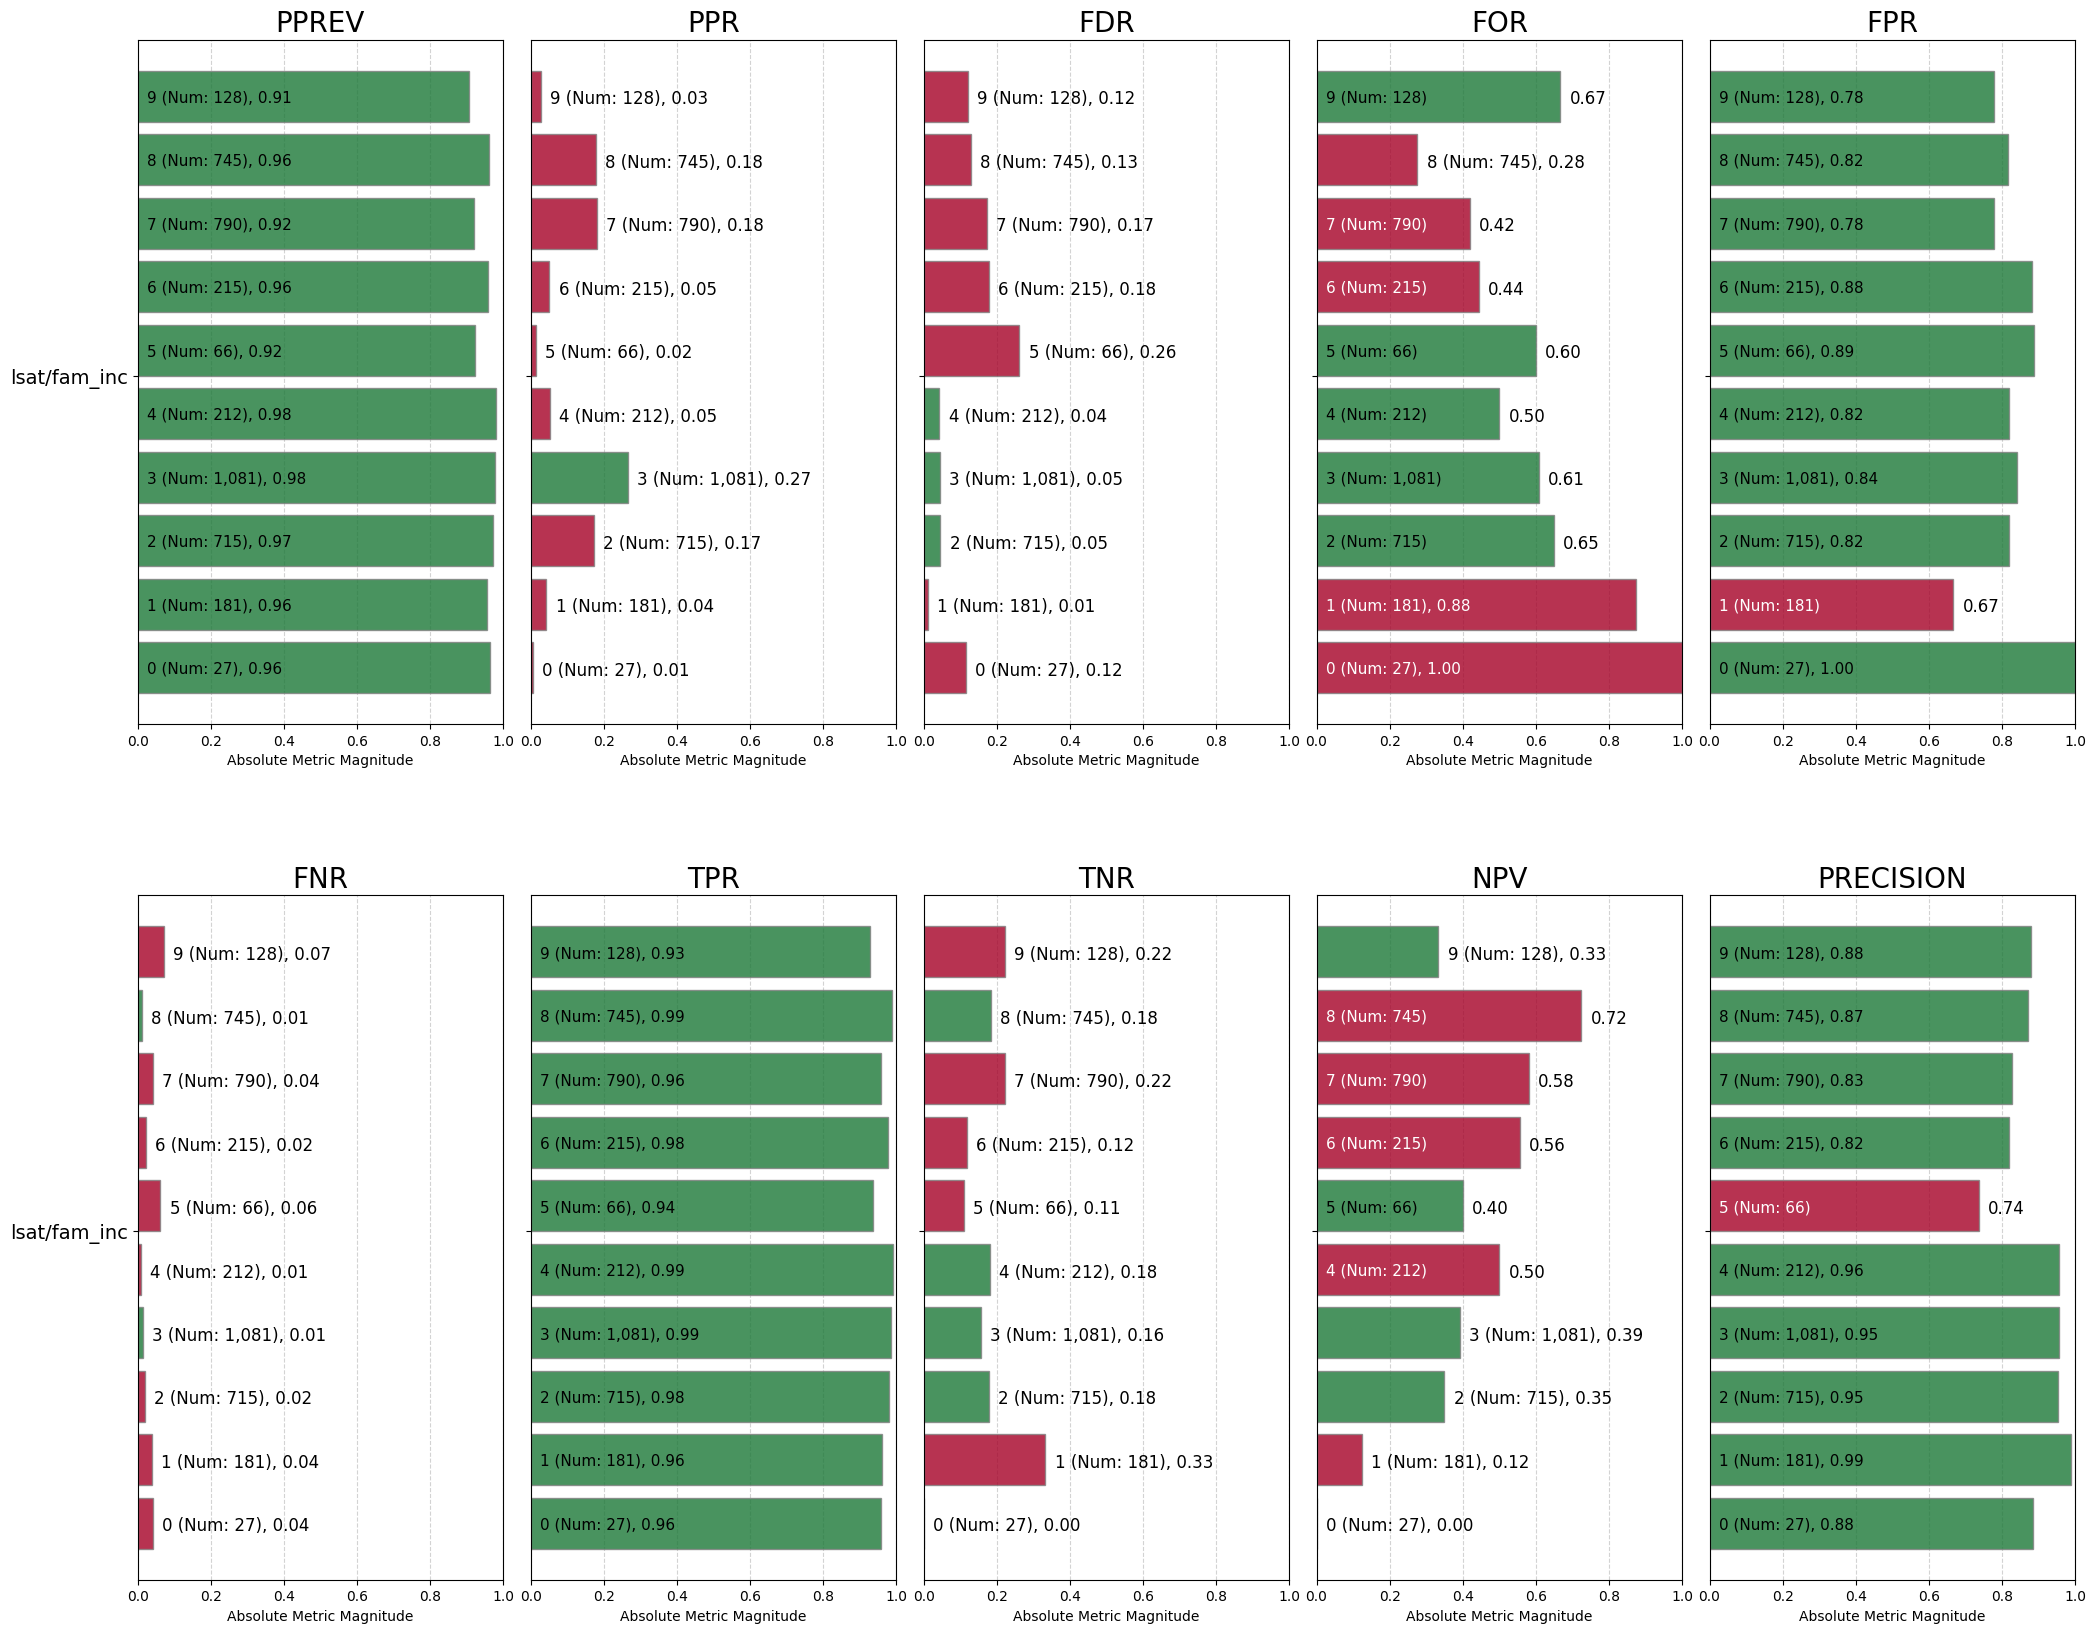

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False           False   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False

<Figure size 640x480 with 0 Axes>

In [34]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'race/lsat', target,list_of_disparities, priv)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'race/fam_inc', target, list_of_disparities, priv)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, 'lsat/fam_inc', target,list_of_disparities, priv)

---------- Model name:  LogisticRegression ----------

Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Accuracy score test corrected:
0.8868
attribute: race/fam_inc
Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
---------- Metrics --------

Disparate Impact Ratio for race/fam_inc: 0.998
Statistical Parity Difference for race/fam_inc: -0.002
equalized opportunity difference for race/fam_inc: 0.000
equalized ods difference for race/fam_inc: 0.005
 FNR ratio for race/fam_inc: 0.983
 FNR privileged for race/fam_inc: 0.006
 FNR unpriv for race/fam_inc: 0.006
 FPR ratio for race/fam_inc

attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.65  0.91  0.07  0.75  0.31  0.93   
1    race/fam_inc               1      0.79  0.97  0.11  0.50  0.19  0.89   
2    race/fam_inc               2      0.71  0.98  0.10  0.33  0.29  0.90   
3    race/fam_inc               3      0.75  0.98  0.05  0.50  0.24  0.95   
4    race/fam_inc               4      0.81  1.00  0.00   NaN  0.19  1.00   
5    race/fam_inc               5      0.85  1.00  0.00   NaN  0.15  1.00   
6    race/fam_inc               6      0.94  1.00  0.06  0.00  0.06  0.94   
7    race/fam_inc               7      0.90  1.00  0.00  1.00  0.10  1.00   
8    race/fam_inc               8      0.92  0.99  0.04  0.67  0.07  0.96   
9    race/fam_inc               9      0.92  1.00  0.00   NaN  0.08  1.00   
10      race/lsat               0      0.92  1.00  0.00   NaN  0.08  1.00   
11      race/lsat               1      0.66  0.96  0.09  0.46  0.33  0.91   
12      race/lsat               2      0.95  1.00  0.00  1.00  0.05  1.00   
13      race/lsat               3      0.87  0.99  0.03  0.54  0.13  0.97   
14   lsat/fam_inc               0      0.89  1.00  0.00   NaN  0.11  1.00   
15   lsat/fam_inc               1      0.98  1.00  0.00   NaN  0.02  1.00   
16   lsat/fam_inc               2      0.95  1.00  0.00   NaN  0.05  1.00   
17   lsat/fam_inc               3      0.94  1.00  0.00  1.00  0.05  1.00   
18   lsat/fam_inc               4      0.95  1.00  0.00   NaN  0.05  1.00   
19   lsat/fam_inc               5      0.70  0.94  0.06  0.75  0.27  0.94   
20   lsat/fam_inc               6      0.81  0.98  0.10  0.43  0.18  0.90   
21   lsat/fam_inc               7      0.80  0.99  0.05  0.43  0.20  0.95   
22   lsat/fam_inc               8      0.85  0.99  0.06  0.50  0.15  0.94   
23   lsat/fam_inc               9      0.86  1.00  0.00   NaN  0.14  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.09  0.25       0.69  0.01   0.91  0.70  
1   0.03  0.50       0.81  0.03   0.95  0.79  
2   0.02  0.67       0.71  0.06   0.96  0.69  
3   0.02  0.50       0.76  0.04   0.98  0.75  
4   0.00   NaN       0.81  0.01   1.00  0.81  
5   0.00   NaN       0.85  0.01   1.00  0.85  
6   0.00  1.00       0.94  0.06   1.00  0.93  
7   0.00  0.00       0.90  0.30   1.00  0.90  
8   0.01  0.33       0.93  0.40   0.99  0.92  
9   0.00   NaN       0.92  0.08   1.00  0.92  
10  0.00   NaN       0.92  0.04   1.00  0.92  
11  0.04  0.54       0.67  0.11   0.94  0.66  
12  0.00  0.00       0.95  0.49   1.00  0.95  
13  0.01  0.46       0.87  0.36   0.99  0.87  
14  0.00   NaN       0.89  0.01   1.00  0.89  
15  0.00   NaN       0.98  0.04   1.00  0.98  
16  0.00   NaN       0.95  0.17   1.00  0.95  
17  0.00  0.00       0.95  0.26   1.00  0.95  
18  0.00   NaN       0.95  0.05   1.00  0.95  
19  0.06  0.25       0.73  0.02   0.94  0.73  
20  0.02  0.57       0.82  0.05   0.97  0.80  
21  0.01  0.57       0.80  0.19   0.98  0.79  
22  0.01  0.50       0.85  0.18   0.98  0.85  
23  0.00   NaN       0.86  0.03   1.00  0.86

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 2
Majority class for:  lsat/fam_inc  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           4.15          14.28   
1    race/fam_inc               1           2.59           4.44   
2    race/fam_inc               2           3.89           3.29   
3    race/fam_inc               3           3.27           2.31   
4    race/fam_inc               4           2.48           0.00   
5    race/fam_inc               5           2.00           0.00   
6    race/fam_inc               6           0.86           0.00   
7    race/fam_inc               7           1.29           0.27   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.03           0.00   
10      race/lsat               0           1.69           0.00   
11      race/lsat               1           6.78          15.22   
12      race/lsat               2           1.00           1.00   
13      race/lsat               3           2.69           2.11   
14   lsat/fam_inc               0           2.10           0.00   
15   lsat/fam_inc               1           0.31           0.00   
16   lsat/fam_inc               2           1.03           0.00   
17   lsat/fam_inc               3           1.00           1.00   
18   lsat/fam_inc               4           0.98           0.00   
19   lsat/fam_inc               5           5.18          12.80   
20   lsat/fam_inc               6           3.45           3.55   
21   lsat/fam_inc               7           3.75           1.96   
22   lsat/fam_inc               8           2.76           2.27   
23   lsat/fam_inc               9           2.65           0.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.12           0.97           0.75           0.03   
1            0.75           0.93           1.50           0.08   
2            0.50           0.94           2.00           0.16   
3            0.75           0.99           1.50           0.11   
4             NaN           1.04            NaN           0.02   
5             NaN           1.04            NaN           0.03   
6            0.00           0.98           3.00           0.16   
7            1.50           1.04           0.00           0.76   
8            1.00           1.00           1.00           1.00   
9             NaN           1.04            NaN           0.19   
10            NaN           1.00            NaN           0.09   
11           0.46           0.91          10.00           0.22   
12           1.00           1.00            NaN           1.00   
13           0.54           0.97          10.00           0.72   
14            NaN           1.00            NaN           0.03   
15            NaN           1.00            NaN           0.17   
16            NaN           1.00            NaN           0.66   
17           1.00           1.00            NaN           1.00   
18            NaN           1.00            NaN           0.20   
19           0.75           0.94          10.00           0.06   
20           0.43           0.90          10.00           0.19   
21           0.43           0.95          10.00           0.72   
22           0.50           0.94          10.00           0.68   
23            NaN           1.00            NaN           0.12   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.92                 0.75           1.81           0.91  
1              0.96                 0.87           2.82           0.98  
2              0.96                 0.77           2.48           0.98  
3              0.99                 0.82           1.15           0.99  
4              1.01                 0.88           0.00           1.01  
5              1.01                 0.92           0.00           1.01  
6              1.01                 1.01           1.41           1.01  
7              1.01                 0.98           0.00           1.00  
8              1.00

              fnr_disparity  fpr_disparity
race/fam_inc       2.732222       0.996667
race/lsat          5.776667       0.960000
lsat/fam_inc       2.286667       0.970000
Overall average for fnr_disparity:  3.599
Overall average for fpr_disparity:  0.976


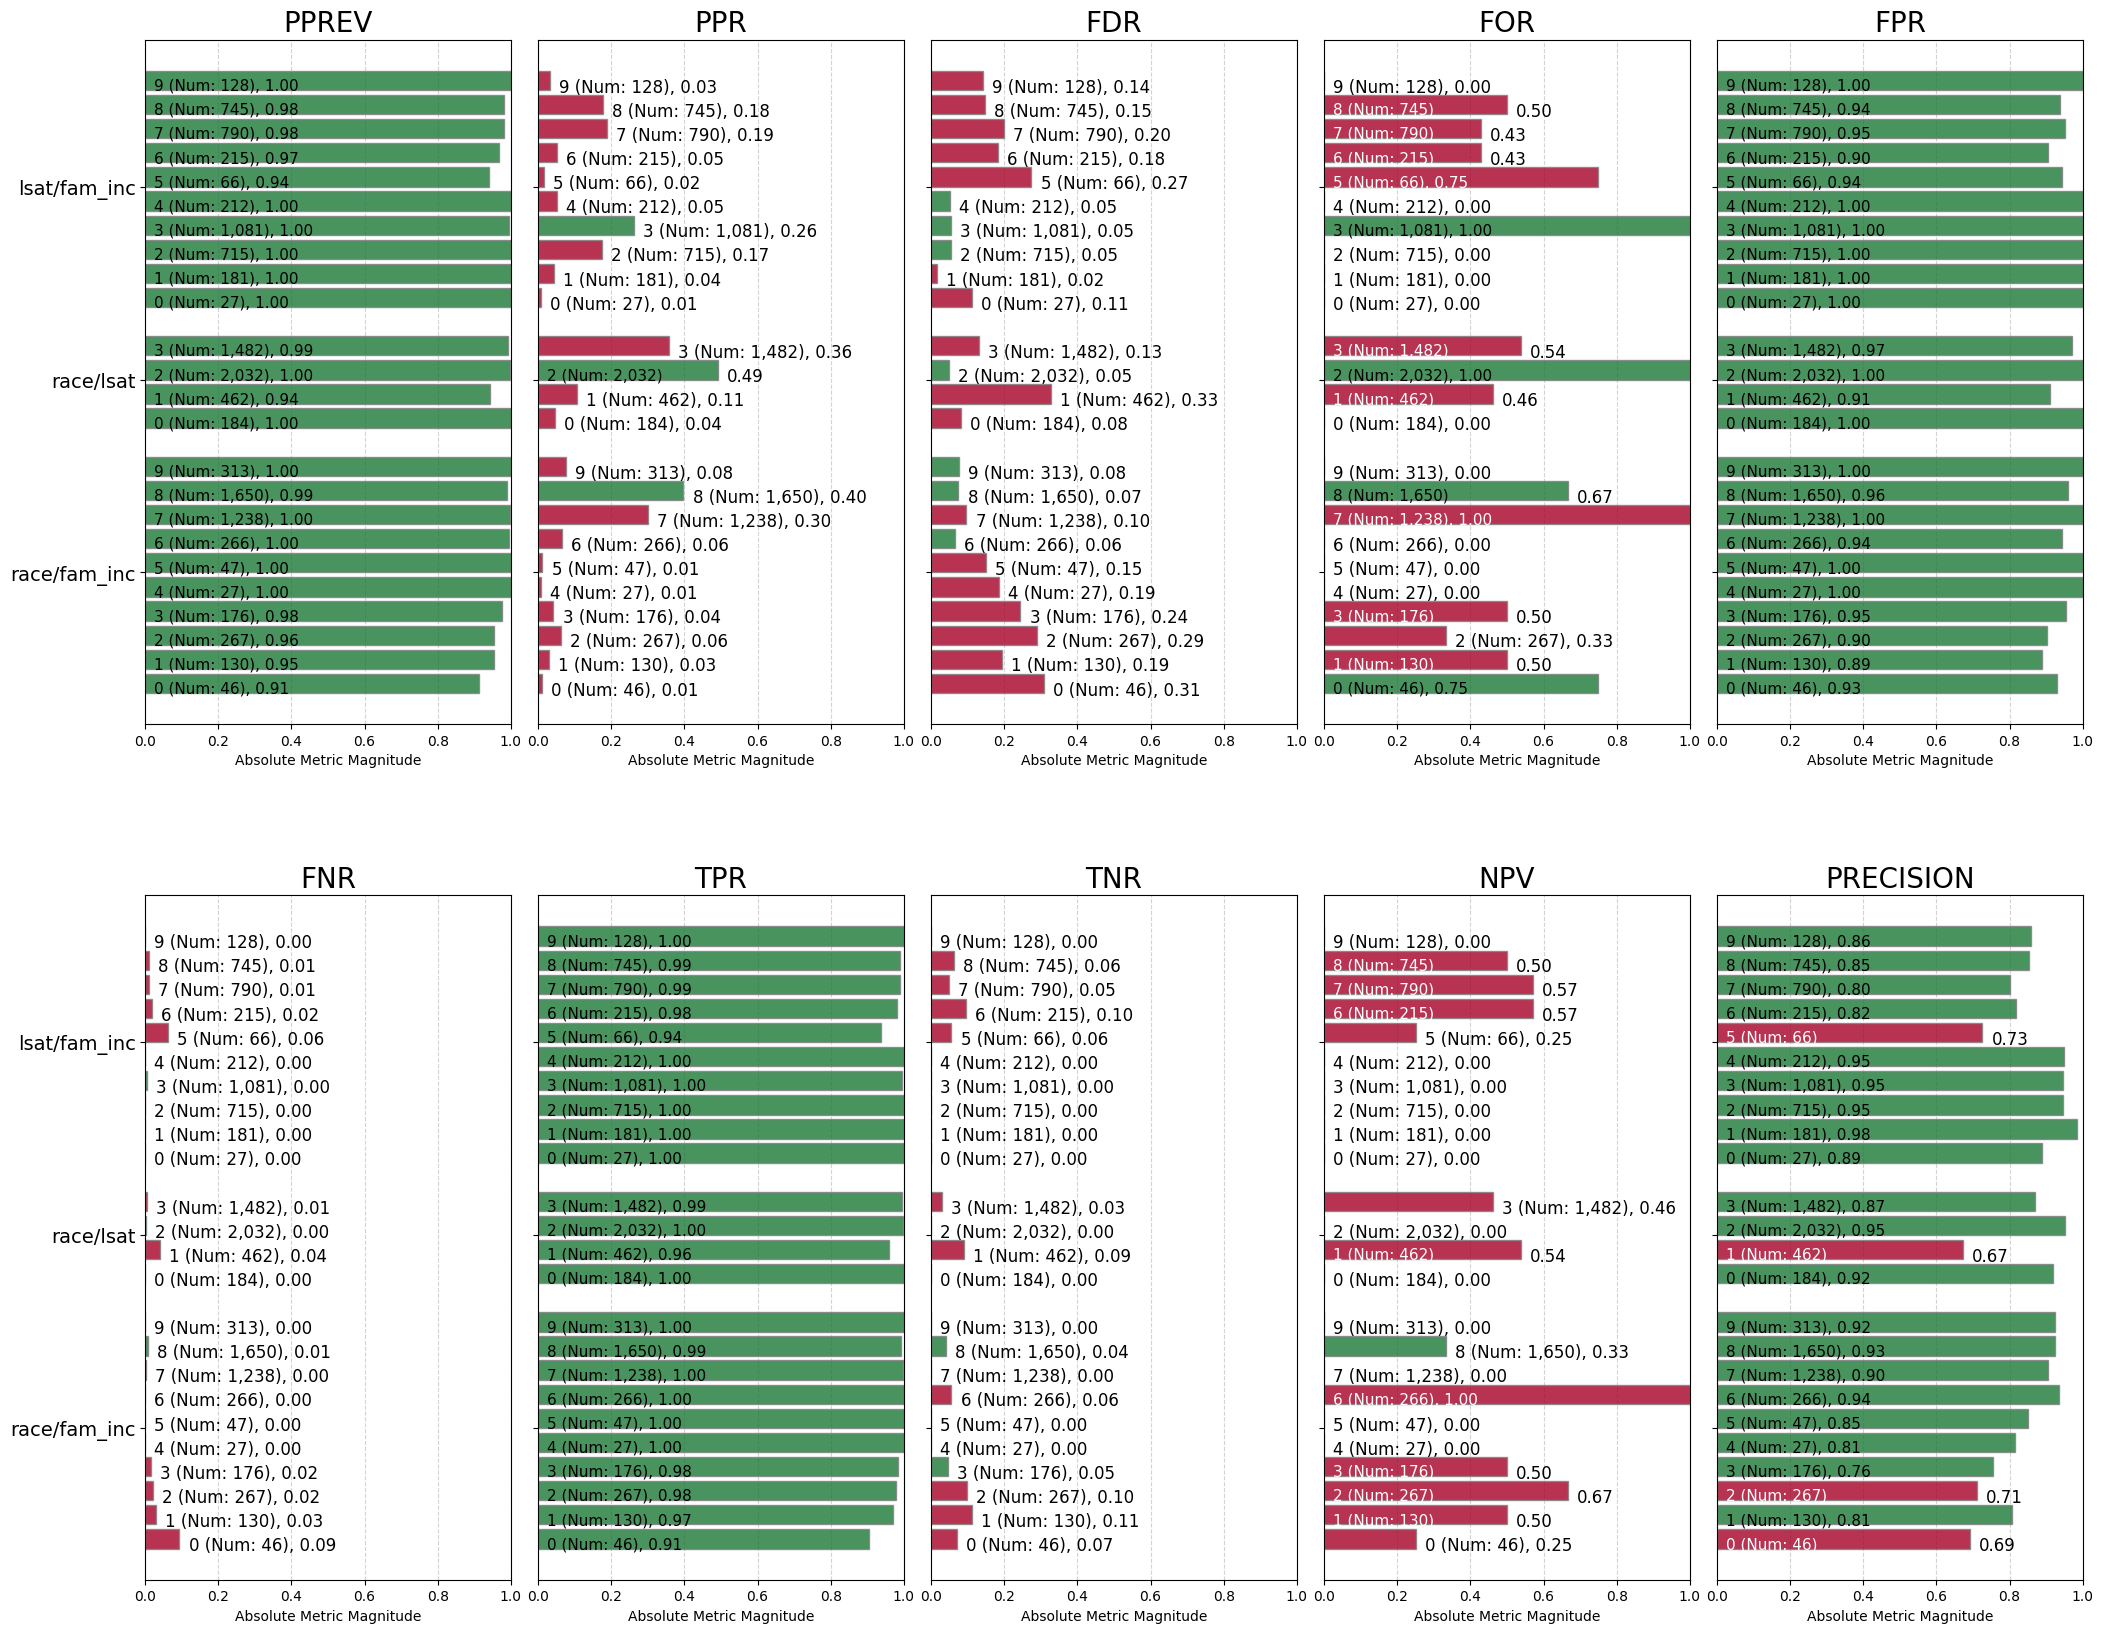

model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1   lsat/fam_inc               False           True   
1         0      binary 0/1   race/fam_inc               False           True   
2         0      binary 0/1      race/lsat               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False        True       False       False        True       False   
1       False        True       False       False        True       False   
2       False        True       False       False        True       False   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False             False         False          False            True   
1       False             False         False          False            True   
2       False             False         False          False            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                False  
2                  False                False

score  label_value race/fam_inc race/lsat lsat/fam_inc  rank_abs  \
20386    1.0            1            6         2            1         1   
2813     1.0            1            9         2            4         2   
10760    1.0            1            7         3            7         3   
10177    1.0            1            2         1            7         4   
16296    1.0            1            9         3            9         5   
...      ...          ...          ...       ...          ...       ...   
8360     0.0            1            8         2            3      4156   
8719     0.0            0            2         1            7      4157   
64       0.0            1            8         3            8      4158   
8152     0.0            1            1         1            6      4159   
7243     0.0            0            8         3            8      4160   

       rank_pct  binary_score  binary_fpr  binary_fnr  binary_ppr  binary_tnr  \
20386  0.000240             1         0.0         NaN           1         0.0   
2813   0.000481             1         0.0         NaN           1         0.0   
10760  0.000721             1         0.0         NaN           1         0.0   
10177  0.000962             1         0.0         NaN           1         0.0   
16296  0.001202             1         0.0         NaN           1         0.0   
...         ...           ...         ...         ...         ...         ...   
8360   0.999038             0         NaN         1.0           0         NaN   
8719   0.999279             0         NaN         0.0           0         NaN   
64     0.999519             0         NaN         1.0           0         NaN   
8152   0.999760             0         NaN         1.0           0         NaN   
7243   1.000000             0         NaN         0.0           0         NaN   

       binary_tpr  binary_precision  binary_fdr  binary_pprev  binary_npv  \
20386         NaN               0.0         0.0             1         NaN   
2813          NaN               0.0         0.0             1         NaN   
10760         NaN               0.0         0.0             1         NaN   
10177         NaN               0.0         0.0             1         NaN   
16296         NaN               0.0         0.0             1         NaN   
...           ...               ...         ...           ...         ...   
8360          1.0               NaN         NaN             0         1.0   
8719          0.0               NaN         NaN             0         0.0   
64            1.0               NaN         NaN             0         1.0   
8152          1.0               NaN         NaN             0         1.0   
7243          0.0               NaN         NaN             0         0.0   

       binary_for  
20386         NaN  
2813          NaN  
10760         NaN  
10177         NaN  
16296         NaN  
...           ...  
8360          1.0  
8719          0.0  
64            1.0  
8152          1.0  
7243          0.0  

[4160 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [30]:
post_process_eq_ods(data=df_num_int, attributes=protected_attributes_int, target=target, list_of_disparities=list_of_disparities, priv=priv)

Plotting FPR
Plotting FDR
Plotting FOR


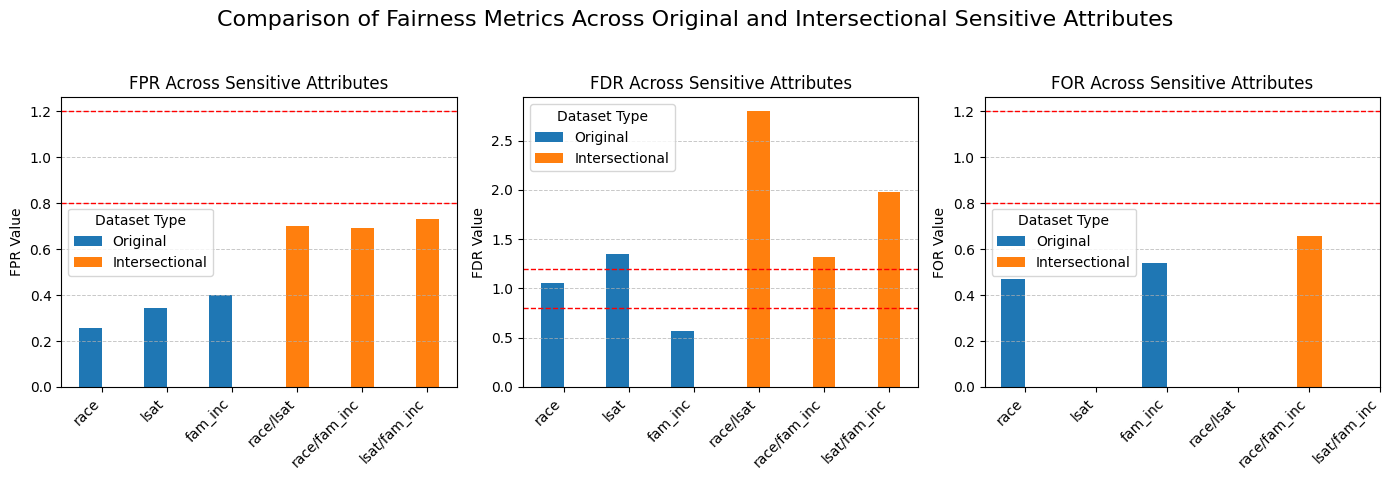

In [114]:

data = {
    'Group/Subgroup': ['race', 'lsat', 'fam_inc', 'race/lsat', 'race/fam_inc', 'lsat/fam_inc'],
    'Dataset Type': ['Original', 'Original', 'Original', 'Intersectional', 'Intersectional', 'Intersectional'],
    'FPR': fpr_list,
    # 'Equalized Odds': [0.449,0.316,0.175,0.298,0.302,0.268],
    'FOR': for_list,
    'FDR':fdr_list,

}

df = pd.DataFrame(data)

# Define the metrics you want to plot
metrics = ['FPR', 'FDR', 'FOR']


# Pivot the DataFrame for easier plotting
# Define the metrics and other parameters
groups = df['Group/Subgroup'].unique()
bar_width = 0.35
x = np.arange(len(groups))

# Set up figure for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14 ,5), sharey=False)
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    print(f"Plotting {metric}")

    # Filter Original and Intersectional values for each metric
    # For 'Original', we only need the values for 'Race', 'LSAT', and 'Income'
    original_values = df[(df['Dataset Type'] == 'Original') & (df['Group/Subgroup'].isin(['race', 'lsat', 'fam_inc']))][metric].values
    intersectional_values = df[(df['Dataset Type'] == 'Intersectional')][metric].values

    # Create arrays to hold values for missing groups (pad with NaN or 0)
    original_padded = np.full(len(groups), np.nan)
    intersectional_padded = np.full(len(groups), np.nan)

    # Assign the values for the relevant groups (indexing them based on 'groups')
    for i, group in enumerate(groups):
        if group in ['race', 'lsat', 'fam_inc']:
            # Fill Original values for these groups
            original_padded[i] = original_values[np.where(np.isin(['race', 'lsat', 'fam_inc'], group))[0][0]]

        # Fill Intersectional values for all groups
        if group in ['race/lsat', 'race/fam_inc', 'lsat/fam_inc']:
            intersectional_padded[i] = intersectional_values[np.where(np.isin(['race/lsat', 'race/fam_inc', 'lsat/fam_inc'], group))[0][0]]

    # Ensure that the lengths of the arrays match
    assert len(original_padded) == len(x)
    assert len(intersectional_padded) == len(x)

    # Plot bars for each dataset type
    ax.bar(x, original_padded/2, width=bar_width, label='Original')
    ax.bar(x + bar_width/2, intersectional_padded, width=bar_width, label='Intersectional')

    # Customize the subplot
    ax.set_title(f"{metric} Across Sensitive Attributes", fontsize=12)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    ax.set_ylabel(f"{metric} Value")
    ax.legend(title="Dataset Type")
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=1.2, color='red', linestyle='--', linewidth=1)


# Layout adjustment and main title
plt.suptitle('Comparison of Fairness Metrics Across Original and Intersectional Sensitive Attributes', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()

x

In [56]:
fpr_list = [metrics_dict["DecisionTree"]["race"][5],metrics_dict["DecisionTree"]["lsat"][5],metrics_dict["DecisionTree"]["fam_inc"][5]]
fpr_list = fpr_list + [metrics_dict_int["DecisionTree"]["race/lsat"][5],metrics_dict_int["DecisionTree"]["race/fam_inc"][5],metrics_dict_int["DecisionTree"]["lsat/fam_inc"][5]]

for_list = [metrics_dict["DecisionTree"]["race"][6],metrics_dict["DecisionTree"]["lsat"][6],metrics_dict["DecisionTree"]["fam_inc"][6]]
for_list = for_list + [metrics_dict_int["DecisionTree"]["race/lsat"][6],metrics_dict_int["DecisionTree"]["race/fam_inc"][6],metrics_dict_int["DecisionTree"]["lsat/fam_inc"][6]]

fdr_list = [metrics_dict["DecisionTree"]["race"][7],metrics_dict["DecisionTree"]["lsat"][7],metrics_dict["DecisionTree"]["fam_inc"][7]]
fdr_list = fdr_list + [metrics_dict_int["DecisionTree"]["race/lsat"][7],metrics_dict_int["DecisionTree"]["race/fam_inc"][7],metrics_dict_int["DecisionTree"]["lsat/fam_inc"][7]]



In [113]:
for_list

[0.9357585139318885, inf, 1.0783410138248848, inf, 0.6551724137931034, inf]